## Relevant Package installations

In [14]:
%pip install datasets
%pip install transformers
%pip install optuna

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Relevant imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import optuna
from functools import partial
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
from optuna.trial import TrialState

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertModel

### Cleaning Data

In [17]:
df = pd.read_csv("all_tickers_merged.csv")
df = df.drop(columns=["date", "source", "url","Date_","Close_AAPL","Next_Close","Direction_Label","Close_AMZN","Close_TSLA","Close_NVDA","Close_PLTR","Close_SOFI","Close_F","Close_SNAP","Close_BTC-USD","Close_INTC","Close_AAL","Close_PFE","Close_BAC","Close_WBD","Close_RIVN","Close_PYPL","Close_HIMS","Close_GOOG","Close_META","Close_^GSPC","Close_^IXIC","Close_JPM"])
df.to_csv("all_tickers_headline_direction.csv", index=False)

### Loading the dataset
*   Import the dataset from directory
*   Combine the test, train and validation split they provide so that we can create our own split



In [5]:
from datasets import load_dataset


class ClassifierDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['headline']
        label = self.data.iloc[idx]['label']
        return {'text': text, 'label': label}

In [6]:
def collate_fn(batch, tokenizer):
    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]

    # Tokenize and dynamically pad
    encoding = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    labels = torch.tensor(labels, dtype=torch.float)  # float for BCEWithLogitsLoss

    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'label': labels
    }

In [7]:
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
dataset = ClassifierDataset("all_tickers_headline_direction.csv")

In [8]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size  # handles rounding

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, tokenizer)
)

### Validation Set Batch

In [10]:
def val_collate_fn(batch, tokenizer, max_length=128):
    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]

    # Tokenize and dynamically pad
    encoding = tokenizer(
        texts,
        padding=True,          # Pad dynamically to longest in batch
        truncation=False,
        max_length=max_length,
        return_tensors="pt"
    )

    labels = torch.tensor(labels, dtype=torch.float)  # float for BCEWithLogitsLoss

    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'label': labels
    }

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,  # No shuffle during validation
    collate_fn=lambda batch: val_collate_fn(batch, tokenizer, max_length=128)
)


In [11]:
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,  # No shuffle during validation
    collate_fn=lambda batch: val_collate_fn(batch, tokenizer, max_length=128)
)

### EDA on the dataset
*   Conduct an Exploratory Data Analysis on this dataset. Some graphics include:
  * Number of entries
  * Distribution of companies
  * Distribution of "score" values
  * Distribution of character and word count
  * Correlation between character and word count vs. score



In [17]:
row_count = len(combined_df)
print(f"Number of entries: {row_count}")

Number of entries: 1173


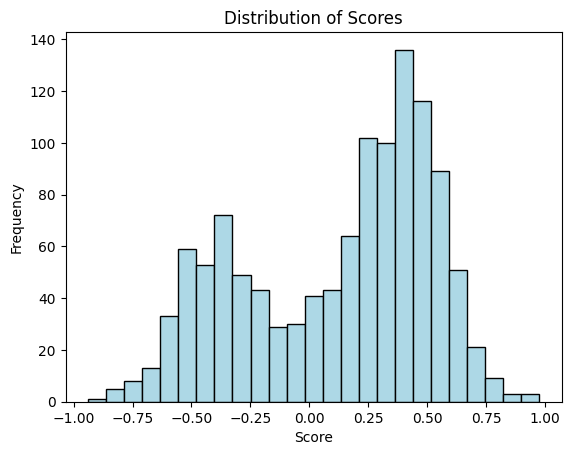

In [18]:
#Plotting the distribution of "score" values
combined_df['score'].hist(bins=25, color="lightblue", edgecolor="black", grid = False)

#Adding labels and title
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

#Display the plot
plt.show()

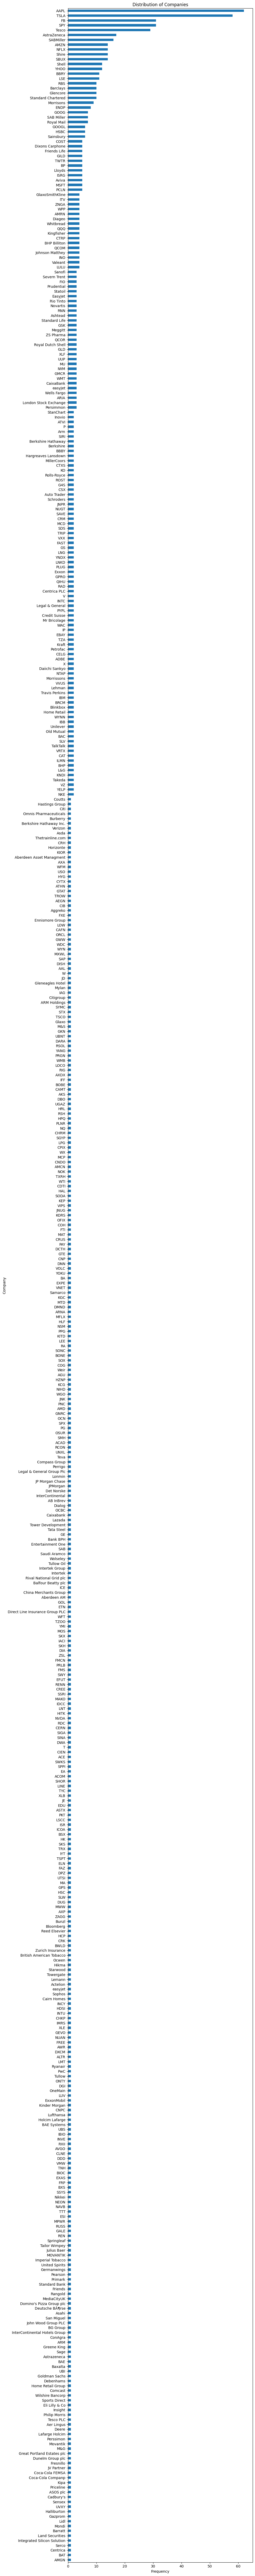

In [ ]:
#Plotting the distribution of "score" values
plt.figure(figsize=(10, 100))
combined_df['target'].value_counts().head(combined_df['target'].nunique()).sort_values().plot(kind='barh')

#Adding Labels
plt.xlabel('Frequency')
plt.ylabel("Company")
plt.title(f'Distribution of Companies')

#Showing the plot
plt.tight_layout()
plt.show()

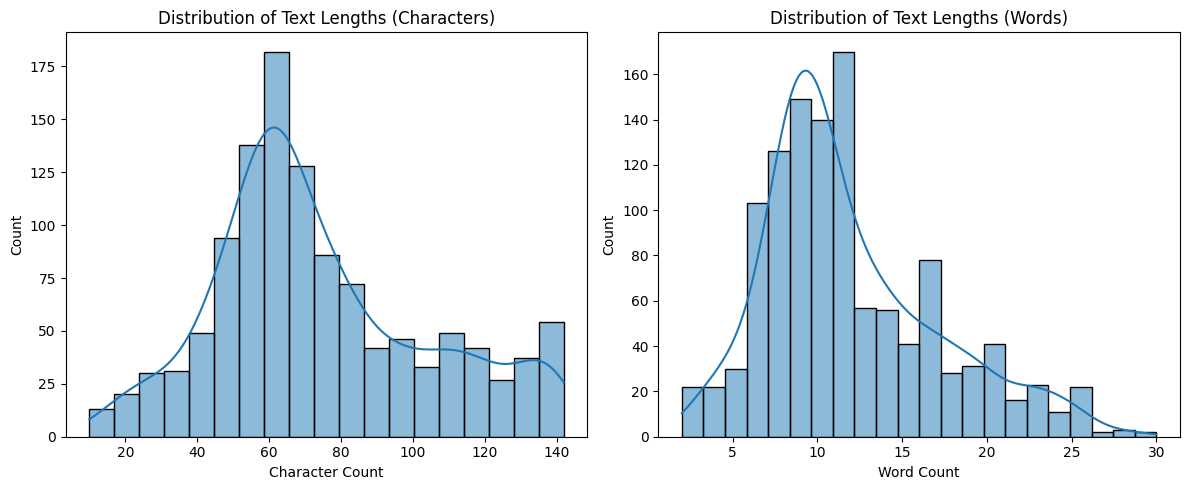

In [20]:
# Add columns for text length analysis
combined_df['text_length'] = combined_df['sentence'].apply(len)
combined_df['word_count'] = combined_df['sentence'].apply(lambda x: len(str(x).split()))

# Plot distribution of text lengths
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(combined_df['text_length'], kde=True)
plt.title('Distribution of Text Lengths (Characters)')
plt.xlabel('Character Count')

plt.subplot(1, 2, 2)
sns.histplot(combined_df['word_count'], kde=True)
plt.title('Distribution of Text Lengths (Words)')
plt.xlabel('Word Count')
plt.tight_layout()
plt.show()

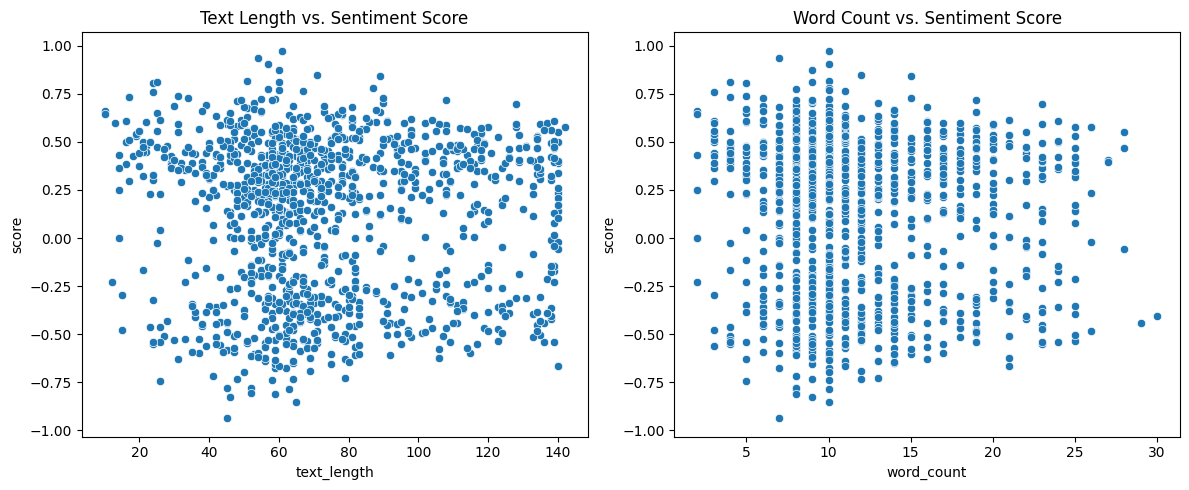

In [21]:
#Examine if text length correlates with sentiment score
#Subplot for text_length vs. score
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='text_length', y='score', data=combined_df)
plt.title('Text Length vs. Sentiment Score')

#Subplot for word_count vs. score
plt.subplot(1, 2, 2)
sns.scatterplot(x='word_count', y='score', data=combined_df)
plt.title('Word Count vs. Sentiment Score')
plt.tight_layout()
plt.show()

### FinBERT + Classifier Head
Here we use the pretrained FinBERT model and add a classifier head to it in order to take the [CLS] embedding from FinBERT and ensure binary classification between stock rise or fall.

In [73]:
#Model Architecture: Basic Tokenizer + Sequence Classification
class FinBERTClassifier(nn.Module):
  def __init__(self, pretrained_model_name="yiyanghkust/finbert-tone", dropout=0.1421205964670695):
      super(FinBERTClassifier, self).__init__()
      self.bert = BertModel.from_pretrained(pretrained_model_name)
      self.dropout = nn.Dropout(dropout)
      self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

  def forward(self, input_ids, attention_mask):
      bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      cls_output = bert_output.pooler_output  # Use CLS token
      
      cls_output = self.dropout(cls_output)
      logits = self.classifier(cls_output)
      return logits
  
  

In [74]:
# Load the tokenizer for FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

In [14]:
#Calculating Maximum token length
max_token_lengths = []

for sentence in combined_df['sentence']:
    # Tokenize without padding or truncation
    tokens = tokenizer(sentence, padding=False, truncation=False)
    max_token_lengths.append(len(tokens['input_ids']))

# Find the maximum length
max_length = max(max_token_lengths)

# Add a small buffer (optional) to account for special tokens like [CLS] and [SEP]
MAX_LENGTH = max_length + 6

print(f"Maximum token length in dataset: {max_length}")
print(f"Setting MAX_LENGTH to: {MAX_LENGTH}")

NameError: name 'combined_df' is not defined

### Training Function
Here we train the model using 10-fold cross-validation. First, 10-fold cross-validation provides a comprehensive assessment of model performance by partitioning the dataset into ten equally sized subsets. In each iteration, one subset is used as the validation set while the remaining nine are used for training. This process is repeated ten times, allowing every data point to serve as both a training and a validation instance exactly once. As a result, the evaluation metrics (e.g., MSE) are averaged over the ten folds, reducing variance and yielding a more stable estimate of the model's true predictive performance.

Second, financial text datasets used with FinBERT often suffer from issues such as limited size, class imbalance, and temporal distributional shifts. The use of 10-fold cross-validation helps mitigate the impact of these limitations by ensuring that the model is tested on diverse subsets of data. This is especially important in the context of sentiment-driven financial modeling, where overfitting to specific language patterns or news contexts can lead to poor generalization in real-world settings.

Finally, 10-fold cross-validation facilitates fair model comparison and hyperparameter tuning, as it allows consistent benchmarking across different configurations. This is critical when fine-tuning pre-trained transformers like FinBERT, where small changes in parameters can lead to significant differences in performance.

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FinBERTClassifier().to(device)
print(device)

cuda


In [76]:
def get_validation_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [77]:
def train_model(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=3,
    lr=4.6814788274326404e-05,
    patience=2,                    # ← early stopping patience
    restore_best=True,            # ← restore best model weights
    save_path="finbert_classifier_best.pt"
):
    optimizer = AdamW(model.parameters(), lr=lr)
    pos_weight = torch.tensor([0.33], device=device)
    loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight)

    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_examples = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)

            optimizer.zero_grad()

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            with torch.no_grad():
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()
                total_correct += (preds == labels).sum().item()
                total_examples += labels.size(0)

            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        train_acc = total_correct / total_examples
        val_acc = get_validation_accuracy(model, val_loader, device)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Early Stopping Logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
            if restore_best:
                best_model_state = model.state_dict()
                torch.save(best_model_state, save_path)
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Optionally restore best model weights
    if restore_best and best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Restored model with best validation accuracy: {best_val_acc:.4f}")
        print(f"Best model saved to: {save_path}")


In [78]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=10,
    lr=4.6814788274326404e-05,
    patience=3,
    restore_best=True,
    save_path="finbert_classifier_attempt_weighted.pt"
)

Epoch 1: 100%|██████████| 114/114 [00:06<00:00, 17.06it/s, loss=0.267]


Epoch 1, Loss: 0.3360, Train Acc: 0.5697, Val Acc: 0.5929


Epoch 2: 100%|██████████| 114/114 [00:06<00:00, 17.90it/s, loss=0.343]


Epoch 2, Loss: 0.2638, Train Acc: 0.7357, Val Acc: 0.6748


Epoch 3: 100%|██████████| 114/114 [00:06<00:00, 17.93it/s, loss=0.0428]


Epoch 3, Loss: 0.1655, Train Acc: 0.8531, Val Acc: 0.8053


Epoch 4: 100%|██████████| 114/114 [00:06<00:00, 17.80it/s, loss=0.0258]


Epoch 4, Loss: 0.1067, Train Acc: 0.9202, Val Acc: 0.7146


Epoch 5: 100%|██████████| 114/114 [00:06<00:00, 17.29it/s, loss=0.262] 


Epoch 5, Loss: 0.0817, Train Acc: 0.9304, Val Acc: 0.8009


Epoch 6: 100%|██████████| 114/114 [00:06<00:00, 17.73it/s, loss=0.203]  


Epoch 6, Loss: 0.0655, Train Acc: 0.9464, Val Acc: 0.7633
Early stopping triggered after 6 epochs.
Restored model with best validation accuracy: 0.8053
Best model saved to: finbert_classifier_attempt_weighted.pt


### Testing

In [79]:
def plot_confusion_matrix(cm, class_names=["Down", "Up"], title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [80]:
def test_model(model, test_loader, device, print_report=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels).flatten()
    y_pred = np.array(all_preds).flatten()

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    cm = confusion_matrix(y_true, y_pred)

    if print_report:
        print("Test Results:")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall   : {recall:.4f}")
        print(f"  F1 Score : {f1:.4f}")
        print(f"  Confusion Matrix:\n{cm}")
        plot_confusion_matrix(cm)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }


c:\Users\joshu\anaconda3\envs\ece556\Lib\site-packages\transformers\tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Test Results:
  Accuracy : 0.7753
  Precision: 0.8226
  Recall   : 0.8947
  F1 Score : 0.8571
  Confusion Matrix:
[[ 46  66]
 [ 36 306]]


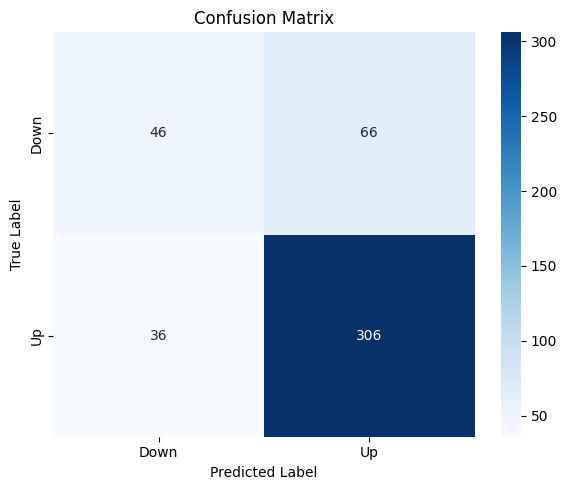

In [82]:
model.load_state_dict(torch.load("finbert_classifier_attempt_weighted.pt"))
model.eval()

results = test_model(model, test_loader, device)


### Hyperparameter Tuning

In [51]:
def smart_val_collate_fn(batch, tokenizer, safe_max_length=128):
    # Extract text and labels from batch
    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]

    # First pass: tokenize to measure max length (no tensors yet)
    encoding_raw = tokenizer(
        texts,
        padding=False,
        truncation=False,
        return_tensors=None  # ← avoid Tensor error here
    )

    # Compute the max sequence length in the batch
    batch_max_len = max(len(ids) for ids in encoding_raw["input_ids"])
    dynamic_max_len = min(batch_max_len, safe_max_length)

    # Second pass: re-tokenize with correct padding and truncation
    encoding = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=dynamic_max_len,
        return_tensors="pt"
    )

    return {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"],
        "label": torch.tensor(labels, dtype=torch.float)
    }

In [52]:
def tokenize_entire_dataset(dataset, tokenizer, max_length=128):
    all_input_ids = []
    all_attention_masks = []
    all_labels = []

    for item in dataset:
        text = item['text']
        label = item['label']

        encoding = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        all_input_ids.append(encoding['input_ids'].squeeze(0))
        all_attention_masks.append(encoding['attention_mask'].squeeze(0))
        all_labels.append(torch.tensor(label, dtype=torch.float))

    return (
        torch.stack(all_input_ids),
        torch.stack(all_attention_masks),
        torch.stack(all_labels)
    )


In [53]:
class CachedTensorDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "label": self.labels[idx]
        }

In [54]:
# Full raw dataset
full_raw_dataset = ClassifierDataset("all_tickers_headline_direction.csv")

# Tokenize everything first
input_ids, attn_masks, labels = tokenize_entire_dataset(full_raw_dataset, tokenizer)

# Wrap into a TensorDataset so we can split it
full_tensor_dataset = CachedTensorDataset(input_ids, attn_masks, labels)

# Split into train and val
train_size = int(0.8 * len(full_tensor_dataset))
val_size = len(full_tensor_dataset) - train_size

train_hyper_dataset, val_hyper_dataset = random_split(full_tensor_dataset, [train_size, val_size])


In [59]:
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FinBERTClassifier().to(device)
    print(device)
    lr = trial.suggest_float("lr", 1e-6, 5e-5, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])

    train_loader = DataLoader(train_hyper_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_hyper_dataset, batch_size=batch_size, shuffle=False)

    model = FinBERTClassifier(dropout=dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    pos_weight = torch.tensor([0.33], device=device)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_val_acc = 0

    for epoch in tqdm(range(5)):
        model.train()
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)

            optimizer.zero_grad()
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

        val_acc = get_validation_accuracy(model, val_loader, device)
        trial.report(val_acc, step=epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc


In [60]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.4f}")
for key, value in trial.params.items():
    print(f"  {key}: {value}")


[I 2025-05-07 10:57:39,170] A new study created in memory with name: no-name-b0cbf8ec-9349-4528-8ffc-f1343d998b54


cuda


100%|██████████| 5/5 [01:29<00:00, 17.95s/it]
[I 2025-05-07 10:59:09,641] Trial 0 finished with value: 0.7207505518763797 and parameters: {'lr': 3.6947251691746003e-06, 'dropout': 0.28084175243281334, 'batch_size': 16}. Best is trial 0 with value: 0.7207505518763797.


cuda


100%|██████████| 5/5 [00:59<00:00, 11.89s/it]
[I 2025-05-07 11:00:09,861] Trial 1 finished with value: 0.7560706401766004 and parameters: {'lr': 4.6814788274326404e-05, 'dropout': 0.1421205964670695, 'batch_size': 32}. Best is trial 1 with value: 0.7560706401766004.


cuda


100%|██████████| 5/5 [01:29<00:00, 17.92s/it]
[I 2025-05-07 11:01:40,316] Trial 2 finished with value: 0.7461368653421634 and parameters: {'lr': 2.4434691706478957e-05, 'dropout': 0.29682750979811, 'batch_size': 16}. Best is trial 1 with value: 0.7560706401766004.


cuda


100%|██████████| 5/5 [01:29<00:00, 17.93s/it]
[I 2025-05-07 11:03:10,810] Trial 3 finished with value: 0.7229580573951435 and parameters: {'lr': 4.0393961440717626e-06, 'dropout': 0.34425536611716734, 'batch_size': 16}. Best is trial 1 with value: 0.7560706401766004.


cuda


100%|██████████| 5/5 [01:29<00:00, 17.96s/it]
[I 2025-05-07 11:04:41,393] Trial 4 finished with value: 0.7163355408388521 and parameters: {'lr': 4.103369267177373e-06, 'dropout': 0.42174121593294245, 'batch_size': 16}. Best is trial 1 with value: 0.7560706401766004.


cuda


 60%|██████    | 3/5 [00:47<00:31, 15.93s/it]
[I 2025-05-07 11:05:29,956] Trial 5 pruned. 


cuda


  0%|          | 0/5 [00:12<?, ?it/s]
[I 2025-05-07 11:05:42,872] Trial 6 pruned. 


cuda


  0%|          | 0/5 [00:12<?, ?it/s]
[I 2025-05-07 11:05:55,715] Trial 7 pruned. 


cuda


  0%|          | 0/5 [00:18<?, ?it/s]
[I 2025-05-07 11:06:14,820] Trial 8 pruned. 


cuda


  0%|          | 0/5 [00:18<?, ?it/s]
[I 2025-05-07 11:06:34,138] Trial 9 pruned. 


cuda


100%|██████████| 5/5 [01:00<00:00, 12.02s/it]
[I 2025-05-07 11:07:35,014] Trial 10 finished with value: 0.7505518763796909 and parameters: {'lr': 4.529174773793426e-05, 'dropout': 0.10248374341028271, 'batch_size': 32}. Best is trial 1 with value: 0.7560706401766004.


cuda


100%|██████████| 5/5 [01:00<00:00, 12.10s/it]
[I 2025-05-07 11:08:36,243] Trial 11 finished with value: 0.7549668874172185 and parameters: {'lr': 4.505749638047726e-05, 'dropout': 0.1061304542799176, 'batch_size': 32}. Best is trial 1 with value: 0.7560706401766004.


cuda


  0%|          | 0/5 [00:12<?, ?it/s]
[I 2025-05-07 11:08:49,211] Trial 12 pruned. 


cuda


  0%|          | 0/5 [00:12<?, ?it/s]
[I 2025-05-07 11:09:02,016] Trial 13 pruned. 


cuda


100%|██████████| 5/5 [00:59<00:00, 11.99s/it]
[I 2025-05-07 11:10:02,944] Trial 14 finished with value: 0.7262693156732892 and parameters: {'lr': 1.1723160042196268e-05, 'dropout': 0.18599902490751993, 'batch_size': 32}. Best is trial 1 with value: 0.7560706401766004.


cuda


 20%|██        | 1/5 [00:24<01:37, 24.37s/it]
[I 2025-05-07 11:10:28,121] Trial 15 pruned. 


cuda


100%|██████████| 5/5 [00:59<00:00, 11.84s/it]
[I 2025-05-07 11:11:28,078] Trial 16 finished with value: 0.7417218543046358 and parameters: {'lr': 1.2313191347263794e-05, 'dropout': 0.14252519722142473, 'batch_size': 32}. Best is trial 1 with value: 0.7560706401766004.


cuda


100%|██████████| 5/5 [00:58<00:00, 11.76s/it]
[I 2025-05-07 11:12:27,624] Trial 17 finished with value: 0.7494481236203091 and parameters: {'lr': 2.889795811369691e-05, 'dropout': 0.2268751531076611, 'batch_size': 32}. Best is trial 1 with value: 0.7560706401766004.


cuda


100%|██████████| 5/5 [00:58<00:00, 11.70s/it]
[I 2025-05-07 11:13:26,914] Trial 18 finished with value: 0.7494481236203091 and parameters: {'lr': 1.720895608980268e-05, 'dropout': 0.13985627931039293, 'batch_size': 32}. Best is trial 1 with value: 0.7560706401766004.


cuda


  0%|          | 0/5 [00:11<?, ?it/s]
[I 2025-05-07 11:13:39,373] Trial 19 pruned. 


Best trial:
  Accuracy: 0.7561
  lr: 4.6814788274326404e-05
  dropout: 0.1421205964670695
  batch_size: 32


In [ ]:
# #Define Hyperparameters
# BATCH_SIZE = 16
# LEARNING_RATE = 2e-5
# EPOCHS = 10
# NUM_FOLDS = 10
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# #Function to train model for one epoch
# def train_epoch(model, data_loader, optimizer, device):
#   model.train()
#   total_loss = 0

#   progress_bar = tqdm(data_loader, desc="Training")
#   for batch in progress_bar:

#         # Move batch to device
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         scores = batch['score'].to(device)

#         #Clear Gradients
#         optimizer.zero_grad()

#         #Forward Pass
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)

#         #Calculate Loss (MSE)
#         loss = torch.nn.MSELoss()(outputs.squeeze(), scores)

#         #Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

#   return total_loss / len(data_loader)

# #Function to evaluate
# def evaluate(model, data_loader, device):
#   model.eval()
#   predictions = []
#   actual_values = []

#   with torch.no_grad():
#     for batch in data_loader:
#       input_ids = batch['input_ids'].to(device)
#       attention_mask = batch['attention_mask'].to(device)
#       scores = batch['score'].to(device)

#       outputs = model(input_ids=input_ids, attention_mask=attention_mask)

#       # Move tensors to CPU before converting to numpy
#       predictions.extend(outputs.squeeze().cpu().numpy())
#       actual_values.extend(scores.cpu().numpy())  # Add .cpu() here

#   mse = mean_squared_error(actual_values, predictions)
#   mae = mean_absolute_error(actual_values, predictions)

#   return mse, mae, predictions, actual_values

# #Main cross validation function
# def run_k_fold_cross_validation(arch, k=10, batch_size=16, learning_rate=2e-5, epochs=10):
#   #Prepare data
#   sentences = combined_df['sentence'].tolist()
#   scores = combined_df['score'].tolist()

#   #Initialize K-fold cross validation
#   kf = KFold(n_splits=k, shuffle=True, random_state=42)

#   # Track metrics across folds
#   fold_results = []
#   all_predictions = []
#   all_actuals = []

#   # Loop through each fold
#   for fold, (train_idx, val_idx) in enumerate(kf.split(sentences)):
#       print(f"\n{'='*50}")
#       print(f"Starting Fold {fold+1}/{k}")
#       print(f"{'='*50}")

#       # Split data for this fold
#       train_sentences = [sentences[i] for i in train_idx]
#       train_scores = [scores[i] for i in train_idx]
#       val_sentences = [sentences[i] for i in val_idx]
#       val_scores = [scores[i] for i in val_idx]

#       # Create datasets
#       # train_dataset = FinBERTDataset(
#       #     train_sentences, train_scores, tokenizer, MAX_LENGTH
#       # )
#       # val_dataset = FinBERTDataset(
#       #     val_sentences, val_scores, tokenizer, MAX_LENGTH
#       # )

#       # Create data loaders
#       # train_loader = DataLoader(
#       #     train_dataset, batch_size=batch_size, shuffle=True
#       # )
#       # val_loader = DataLoader(
#       #     val_dataset, batch_size=batch_size
#       # )

#       # Initialize model and optimizer
#       if arch == "FinBERTegressor":
#         model = FinBERTegressor().to(DEVICE)
#       elif arch == "FinBERTRegressorB":
#         model = FinBERTRegressorB().to(DEVICE)
#       optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

#       # Training loop
#       best_val_mse = float('inf')
#       best_model_state = None

#       for epoch in range(EPOCHS):
#           # Train
#           train_loss = train_epoch(model, train_loader, optimizer, DEVICE)

#           # Evaluate
#           val_mse, val_mae, _, _ = evaluate(model, val_loader, DEVICE)

#           print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}")

#           # Save best model
#           if val_mse < best_val_mse:
#               best_val_mse = val_mse
#               best_model_state = model.state_dict().copy()

#       # Load best model and evaluate final performance
#       model.load_state_dict(best_model_state)
#       val_mse, val_mae, fold_preds, fold_actuals = evaluate(model, val_loader, DEVICE)

#       # Store results
#       fold_results.append({
#           'fold': fold + 1,
#           'mse': val_mse,
#           'mae': val_mae
#       })

#       all_predictions.extend(fold_preds)
#       all_actuals.extend(fold_actuals)

#       # Optional: Save model for each fold
#       #torch.save(model.state_dict(), f'finbert_regressor_fold_{fold+1}.pt')

#       print(f"Fold {fold+1} Results - MSE: {val_mse:.4f}, MAE: {val_mae:.4f}")

#   # Print overall results
#   results_df = pd.DataFrame(fold_results)
#   print(f"\n{'='*50}")
#   print("Cross-Validation Results:")
#   print(f"Average MSE: {results_df['mse'].mean():.4f} ± {results_df['mse'].std():.4f}")
#   print(f"Average MAE: {results_df['mae'].mean():.4f} ± {results_df['mae'].std():.4f}")

#   # Visualize predictions vs actual
#   plt.figure(figsize=(10, 6))
#   plt.scatter(all_actuals, all_predictions, alpha=0.5)
#   plt.plot([-1, 1], [-1, 1], 'r--')  # Perfect prediction line
#   plt.xlabel('Actual Scores')
#   plt.ylabel('Predicted Scores')
#   plt.title('Predicted vs Actual Scores (All Folds)')
#   plt.grid(True, alpha=0.3)
#   plt.savefig('prediction_vs_actual.png')
#   plt.show()

#   return results_df, all_predictions, all_actuals


### Hyperparameter Tuning with Optuna

In [41]:
# param_grid = {
#     "learning_rate": [1e-5, 2e-5, 3e-5],
#     "per_device_train_batch_size": [16, 32, 64],
#     "num_train_epochs": [10, 15, 20]
# }
# grid = ParameterGrid(param_grid)

def objective(trial):
    # Hyperparameters to search
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 5, 30)

    # Call cross-validation
    results_df, _, _ = run_k_fold_cross_validation(
        arch="FinBERTegressor",           # or your model class name,
        k=NUM_FOLDS,
        batch_size=batch_size,
        learning_rate=learning_rate,
        epochs=epochs
    )

    # Return the average MSE (lower is better)
    return results_df['mse'].mean()

[I 2025-04-23 05:33:19,281] A new study created in memory with name: no-name-8001958d-a0ad-43ca-95fe-eb443dac40e8



Starting Fold 1/10


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

c:\Users\joshu\anaconda3\envs\ece556\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\joshu\.cache\huggingface\hub\models--yiyanghkust--finbert-tone. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Training:   3%|▎         | 1/33 [00:00<00:13,  2.40it/s, loss=0.1645]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Training: 100%|██████████| 33/33 [00:03<00:00, 10.26it/s, loss=0.0714]


Epoch 1/10 - Train Loss: 0.1169, Val MSE: 0.0786, Val MAE: 0.2154


Training: 100%|██████████| 33/33 [00:02<00:00, 11.61it/s, loss=0.0719]


Epoch 2/10 - Train Loss: 0.0629, Val MSE: 0.0757, Val MAE: 0.2046


Training: 100%|██████████| 33/33 [00:02<00:00, 11.65it/s, loss=0.0339]


Epoch 3/10 - Train Loss: 0.0422, Val MSE: 0.0670, Val MAE: 0.1920


Training: 100%|██████████| 33/33 [00:02<00:00, 11.46it/s, loss=0.0186]


Epoch 4/10 - Train Loss: 0.0314, Val MSE: 0.0654, Val MAE: 0.1894


Training: 100%|██████████| 33/33 [00:02<00:00, 11.50it/s, loss=0.0642]


Epoch 5/10 - Train Loss: 0.0236, Val MSE: 0.0635, Val MAE: 0.1862


Training: 100%|██████████| 33/33 [00:02<00:00, 11.68it/s, loss=0.0200]


Epoch 6/10 - Train Loss: 0.0194, Val MSE: 0.0649, Val MAE: 0.1869


Training: 100%|██████████| 33/33 [00:02<00:00, 11.74it/s, loss=0.0221]


Epoch 7/10 - Train Loss: 0.0148, Val MSE: 0.0729, Val MAE: 0.1996


Training: 100%|██████████| 33/33 [00:02<00:00, 11.75it/s, loss=0.0447]


Epoch 8/10 - Train Loss: 0.0144, Val MSE: 0.0643, Val MAE: 0.1867


Training: 100%|██████████| 33/33 [00:02<00:00, 11.81it/s, loss=0.0090]


Epoch 9/10 - Train Loss: 0.0132, Val MSE: 0.0655, Val MAE: 0.1957


Training: 100%|██████████| 33/33 [00:02<00:00, 11.78it/s, loss=0.0118]


Epoch 10/10 - Train Loss: 0.0126, Val MSE: 0.0650, Val MAE: 0.1896
Fold 1 Results - MSE: 0.0650, MAE: 0.1896

Starting Fold 2/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.80it/s, loss=0.1002]


Epoch 1/10 - Train Loss: 0.1373, Val MSE: 0.0976, Val MAE: 0.2443


Training: 100%|██████████| 33/33 [00:02<00:00, 11.82it/s, loss=0.0352]


Epoch 2/10 - Train Loss: 0.0717, Val MSE: 0.0848, Val MAE: 0.2211


Training: 100%|██████████| 33/33 [00:02<00:00, 11.79it/s, loss=0.0704]


Epoch 3/10 - Train Loss: 0.0478, Val MSE: 0.0800, Val MAE: 0.2124


Training: 100%|██████████| 33/33 [00:02<00:00, 11.78it/s, loss=0.0287]


Epoch 4/10 - Train Loss: 0.0328, Val MSE: 0.0726, Val MAE: 0.1991


Training: 100%|██████████| 33/33 [00:02<00:00, 11.77it/s, loss=0.0384]


Epoch 5/10 - Train Loss: 0.0246, Val MSE: 0.0732, Val MAE: 0.2010


Training: 100%|██████████| 33/33 [00:02<00:00, 11.77it/s, loss=0.0176]


Epoch 6/10 - Train Loss: 0.0190, Val MSE: 0.0761, Val MAE: 0.2034


Training: 100%|██████████| 33/33 [00:02<00:00, 11.80it/s, loss=0.0165]


Epoch 7/10 - Train Loss: 0.0164, Val MSE: 0.0737, Val MAE: 0.1989


Training: 100%|██████████| 33/33 [00:02<00:00, 11.79it/s, loss=0.0200]


Epoch 8/10 - Train Loss: 0.0151, Val MSE: 0.0789, Val MAE: 0.2035


Training: 100%|██████████| 33/33 [00:02<00:00, 11.78it/s, loss=0.0165]


Epoch 9/10 - Train Loss: 0.0126, Val MSE: 0.0792, Val MAE: 0.2041


Training: 100%|██████████| 33/33 [00:02<00:00, 11.78it/s, loss=0.0115]


Epoch 10/10 - Train Loss: 0.0122, Val MSE: 0.0737, Val MAE: 0.1938
Fold 2 Results - MSE: 0.0737, MAE: 0.1938

Starting Fold 3/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.74it/s, loss=0.1027]


Epoch 1/10 - Train Loss: 0.1106, Val MSE: 0.0969, Val MAE: 0.2348


Training: 100%|██████████| 33/33 [00:02<00:00, 11.78it/s, loss=0.1298]


Epoch 2/10 - Train Loss: 0.0637, Val MSE: 0.0865, Val MAE: 0.2123


Training: 100%|██████████| 33/33 [00:02<00:00, 11.77it/s, loss=0.0252]


Epoch 3/10 - Train Loss: 0.0432, Val MSE: 0.0863, Val MAE: 0.2048


Training: 100%|██████████| 33/33 [00:02<00:00, 11.77it/s, loss=0.0350]


Epoch 4/10 - Train Loss: 0.0322, Val MSE: 0.0861, Val MAE: 0.2033


Training: 100%|██████████| 33/33 [00:02<00:00, 11.77it/s, loss=0.0148]


Epoch 5/10 - Train Loss: 0.0223, Val MSE: 0.0885, Val MAE: 0.2114


Training: 100%|██████████| 33/33 [00:02<00:00, 11.76it/s, loss=0.0145]


Epoch 6/10 - Train Loss: 0.0172, Val MSE: 0.0848, Val MAE: 0.1989


Training: 100%|██████████| 33/33 [00:02<00:00, 11.76it/s, loss=0.0140]


Epoch 7/10 - Train Loss: 0.0164, Val MSE: 0.0887, Val MAE: 0.2120


Training: 100%|██████████| 33/33 [00:02<00:00, 11.78it/s, loss=0.0246]


Epoch 8/10 - Train Loss: 0.0146, Val MSE: 0.0865, Val MAE: 0.2070


Training: 100%|██████████| 33/33 [00:02<00:00, 11.67it/s, loss=0.0134]


Epoch 9/10 - Train Loss: 0.0138, Val MSE: 0.0867, Val MAE: 0.2060


Training: 100%|██████████| 33/33 [00:02<00:00, 12.17it/s, loss=0.0128]


Epoch 10/10 - Train Loss: 0.0116, Val MSE: 0.0842, Val MAE: 0.2030
Fold 3 Results - MSE: 0.0842, MAE: 0.2030

Starting Fold 4/10


Training: 100%|██████████| 33/33 [00:02<00:00, 12.09it/s, loss=0.0743]


Epoch 1/10 - Train Loss: 0.1119, Val MSE: 0.0822, Val MAE: 0.2268


Training: 100%|██████████| 33/33 [00:02<00:00, 12.07it/s, loss=0.0467]


Epoch 2/10 - Train Loss: 0.0604, Val MSE: 0.0699, Val MAE: 0.2019


Training: 100%|██████████| 33/33 [00:02<00:00, 12.08it/s, loss=0.0233]


Epoch 3/10 - Train Loss: 0.0417, Val MSE: 0.0752, Val MAE: 0.2049


Training: 100%|██████████| 33/33 [00:02<00:00, 12.08it/s, loss=0.0476]


Epoch 4/10 - Train Loss: 0.0309, Val MSE: 0.0684, Val MAE: 0.1959


Training: 100%|██████████| 33/33 [00:02<00:00, 12.04it/s, loss=0.0158]


Epoch 5/10 - Train Loss: 0.0239, Val MSE: 0.0742, Val MAE: 0.2023


Training: 100%|██████████| 33/33 [00:02<00:00, 12.07it/s, loss=0.0185]


Epoch 6/10 - Train Loss: 0.0194, Val MSE: 0.0779, Val MAE: 0.2017


Training: 100%|██████████| 33/33 [00:02<00:00, 12.07it/s, loss=0.0130]


Epoch 7/10 - Train Loss: 0.0171, Val MSE: 0.0721, Val MAE: 0.1938


Training: 100%|██████████| 33/33 [00:02<00:00, 12.07it/s, loss=0.0165]


Epoch 8/10 - Train Loss: 0.0145, Val MSE: 0.0752, Val MAE: 0.2013


Training: 100%|██████████| 33/33 [00:02<00:00, 12.07it/s, loss=0.0093]


Epoch 9/10 - Train Loss: 0.0130, Val MSE: 0.0703, Val MAE: 0.1884


Training: 100%|██████████| 33/33 [00:02<00:00, 12.08it/s, loss=0.0071]


Epoch 10/10 - Train Loss: 0.0112, Val MSE: 0.0710, Val MAE: 0.1897
Fold 4 Results - MSE: 0.0710, MAE: 0.1897

Starting Fold 5/10


Training: 100%|██████████| 33/33 [00:02<00:00, 12.05it/s, loss=0.0740]


Epoch 1/10 - Train Loss: 0.1156, Val MSE: 0.0693, Val MAE: 0.2044


Training: 100%|██████████| 33/33 [00:02<00:00, 12.05it/s, loss=0.1238]


Epoch 2/10 - Train Loss: 0.0646, Val MSE: 0.0524, Val MAE: 0.1771


Training: 100%|██████████| 33/33 [00:02<00:00, 12.08it/s, loss=0.0512]


Epoch 3/10 - Train Loss: 0.0425, Val MSE: 0.0482, Val MAE: 0.1742


Training: 100%|██████████| 33/33 [00:02<00:00, 12.07it/s, loss=0.0212]


Epoch 4/10 - Train Loss: 0.0317, Val MSE: 0.0454, Val MAE: 0.1647


Training: 100%|██████████| 33/33 [00:02<00:00, 12.08it/s, loss=0.0174]


Epoch 5/10 - Train Loss: 0.0226, Val MSE: 0.0427, Val MAE: 0.1617


Training: 100%|██████████| 33/33 [00:02<00:00, 12.08it/s, loss=0.0195]


Epoch 6/10 - Train Loss: 0.0181, Val MSE: 0.0422, Val MAE: 0.1601


Training: 100%|██████████| 33/33 [00:02<00:00, 12.08it/s, loss=0.0136]


Epoch 7/10 - Train Loss: 0.0158, Val MSE: 0.0409, Val MAE: 0.1546


Training: 100%|██████████| 33/33 [00:02<00:00, 12.10it/s, loss=0.0196]


Epoch 8/10 - Train Loss: 0.0143, Val MSE: 0.0431, Val MAE: 0.1583


Training: 100%|██████████| 33/33 [00:02<00:00, 12.04it/s, loss=0.0119]


Epoch 9/10 - Train Loss: 0.0137, Val MSE: 0.0449, Val MAE: 0.1597


Training: 100%|██████████| 33/33 [00:02<00:00, 12.06it/s, loss=0.0103]


Epoch 10/10 - Train Loss: 0.0123, Val MSE: 0.0417, Val MAE: 0.1571
Fold 5 Results - MSE: 0.0417, MAE: 0.1571

Starting Fold 6/10


Training: 100%|██████████| 33/33 [00:02<00:00, 12.08it/s, loss=0.1282]


Epoch 1/10 - Train Loss: 0.1080, Val MSE: 0.0722, Val MAE: 0.2051


Training: 100%|██████████| 33/33 [00:02<00:00, 12.05it/s, loss=0.0753]


Epoch 2/10 - Train Loss: 0.0602, Val MSE: 0.0745, Val MAE: 0.2009


Training: 100%|██████████| 33/33 [00:02<00:00, 11.30it/s, loss=0.0378]


Epoch 3/10 - Train Loss: 0.0418, Val MSE: 0.0710, Val MAE: 0.1930


Training: 100%|██████████| 33/33 [00:02<00:00, 12.05it/s, loss=0.0243]


Epoch 4/10 - Train Loss: 0.0305, Val MSE: 0.0671, Val MAE: 0.1882


Training: 100%|██████████| 33/33 [00:02<00:00, 11.65it/s, loss=0.0157]


Epoch 5/10 - Train Loss: 0.0216, Val MSE: 0.0666, Val MAE: 0.1871


Training: 100%|██████████| 33/33 [00:02<00:00, 11.51it/s, loss=0.0161]


Epoch 6/10 - Train Loss: 0.0180, Val MSE: 0.0724, Val MAE: 0.1947


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0239]


Epoch 7/10 - Train Loss: 0.0140, Val MSE: 0.0707, Val MAE: 0.1927


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0181]


Epoch 8/10 - Train Loss: 0.0147, Val MSE: 0.0722, Val MAE: 0.1900


Training: 100%|██████████| 33/33 [00:02<00:00, 11.58it/s, loss=0.0128]


Epoch 9/10 - Train Loss: 0.0120, Val MSE: 0.0735, Val MAE: 0.1935


Training: 100%|██████████| 33/33 [00:02<00:00, 11.82it/s, loss=0.0111]


Epoch 10/10 - Train Loss: 0.0111, Val MSE: 0.0729, Val MAE: 0.1915
Fold 6 Results - MSE: 0.0729, MAE: 0.1915

Starting Fold 7/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.61it/s, loss=0.1270]


Epoch 1/10 - Train Loss: 0.1109, Val MSE: 0.1069, Val MAE: 0.2468


Training: 100%|██████████| 33/33 [00:02<00:00, 11.63it/s, loss=0.0451]


Epoch 2/10 - Train Loss: 0.0623, Val MSE: 0.0940, Val MAE: 0.2278


Training: 100%|██████████| 33/33 [00:02<00:00, 11.47it/s, loss=0.0407]


Epoch 3/10 - Train Loss: 0.0418, Val MSE: 0.0956, Val MAE: 0.2239


Training: 100%|██████████| 33/33 [00:02<00:00, 11.61it/s, loss=0.0482]


Epoch 4/10 - Train Loss: 0.0329, Val MSE: 0.1034, Val MAE: 0.2347


Training: 100%|██████████| 33/33 [00:02<00:00, 11.58it/s, loss=0.0192]


Epoch 5/10 - Train Loss: 0.0232, Val MSE: 0.0944, Val MAE: 0.2187


Training: 100%|██████████| 33/33 [00:02<00:00, 11.35it/s, loss=0.0199]


Epoch 6/10 - Train Loss: 0.0185, Val MSE: 0.0947, Val MAE: 0.2160


Training: 100%|██████████| 33/33 [00:02<00:00, 11.52it/s, loss=0.0117]


Epoch 7/10 - Train Loss: 0.0165, Val MSE: 0.0978, Val MAE: 0.2178


Training: 100%|██████████| 33/33 [00:02<00:00, 12.07it/s, loss=0.0129]


Epoch 8/10 - Train Loss: 0.0151, Val MSE: 0.0909, Val MAE: 0.2130


Training: 100%|██████████| 33/33 [00:02<00:00, 11.53it/s, loss=0.0085]


Epoch 9/10 - Train Loss: 0.0126, Val MSE: 0.0867, Val MAE: 0.2075


Training: 100%|██████████| 33/33 [00:02<00:00, 11.71it/s, loss=0.0123]


Epoch 10/10 - Train Loss: 0.0116, Val MSE: 0.0935, Val MAE: 0.2198
Fold 7 Results - MSE: 0.0935, MAE: 0.2198

Starting Fold 8/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.27it/s, loss=0.1081]


Epoch 1/10 - Train Loss: 0.1064, Val MSE: 0.0734, Val MAE: 0.2029


Training: 100%|██████████| 33/33 [00:02<00:00, 11.86it/s, loss=0.0944]


Epoch 2/10 - Train Loss: 0.0614, Val MSE: 0.0725, Val MAE: 0.2017


Training: 100%|██████████| 33/33 [00:02<00:00, 11.01it/s, loss=0.0206]


Epoch 3/10 - Train Loss: 0.0432, Val MSE: 0.0685, Val MAE: 0.1895


Training: 100%|██████████| 33/33 [00:02<00:00, 11.05it/s, loss=0.0273]


Epoch 4/10 - Train Loss: 0.0322, Val MSE: 0.0650, Val MAE: 0.1823


Training: 100%|██████████| 33/33 [00:03<00:00, 10.91it/s, loss=0.0191]


Epoch 5/10 - Train Loss: 0.0242, Val MSE: 0.0680, Val MAE: 0.1829


Training: 100%|██████████| 33/33 [00:02<00:00, 11.14it/s, loss=0.0224]


Epoch 6/10 - Train Loss: 0.0196, Val MSE: 0.0657, Val MAE: 0.1813


Training: 100%|██████████| 33/33 [00:02<00:00, 11.72it/s, loss=0.0150]


Epoch 7/10 - Train Loss: 0.0172, Val MSE: 0.0641, Val MAE: 0.1799


Training: 100%|██████████| 33/33 [00:02<00:00, 11.71it/s, loss=0.0143]


Epoch 8/10 - Train Loss: 0.0144, Val MSE: 0.0641, Val MAE: 0.1780


Training: 100%|██████████| 33/33 [00:02<00:00, 11.88it/s, loss=0.0110]


Epoch 9/10 - Train Loss: 0.0132, Val MSE: 0.0713, Val MAE: 0.1867


Training: 100%|██████████| 33/33 [00:02<00:00, 11.75it/s, loss=0.0115]


Epoch 10/10 - Train Loss: 0.0131, Val MSE: 0.0633, Val MAE: 0.1778
Fold 8 Results - MSE: 0.0633, MAE: 0.1778

Starting Fold 9/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.72it/s, loss=0.0657]


Epoch 1/10 - Train Loss: 0.1065, Val MSE: 0.0876, Val MAE: 0.2163


Training: 100%|██████████| 33/33 [00:02<00:00, 11.75it/s, loss=0.0518]


Epoch 2/10 - Train Loss: 0.0579, Val MSE: 0.0784, Val MAE: 0.2049


Training: 100%|██████████| 33/33 [00:02<00:00, 11.75it/s, loss=0.0407]


Epoch 3/10 - Train Loss: 0.0401, Val MSE: 0.0838, Val MAE: 0.2076


Training: 100%|██████████| 33/33 [00:02<00:00, 11.76it/s, loss=0.0236]


Epoch 4/10 - Train Loss: 0.0287, Val MSE: 0.0797, Val MAE: 0.2029


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0138]


Epoch 5/10 - Train Loss: 0.0215, Val MSE: 0.0801, Val MAE: 0.1995


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0118]


Epoch 6/10 - Train Loss: 0.0176, Val MSE: 0.0787, Val MAE: 0.1985


Training: 100%|██████████| 33/33 [00:03<00:00, 10.92it/s, loss=0.0416]


Epoch 7/10 - Train Loss: 0.0157, Val MSE: 0.0772, Val MAE: 0.1953


Training: 100%|██████████| 33/33 [00:02<00:00, 11.69it/s, loss=0.0101]


Epoch 8/10 - Train Loss: 0.0140, Val MSE: 0.0756, Val MAE: 0.1930


Training: 100%|██████████| 33/33 [00:02<00:00, 11.70it/s, loss=0.0107]


Epoch 9/10 - Train Loss: 0.0119, Val MSE: 0.0745, Val MAE: 0.1898


Training: 100%|██████████| 33/33 [00:02<00:00, 11.69it/s, loss=0.0112]


Epoch 10/10 - Train Loss: 0.0107, Val MSE: 0.0720, Val MAE: 0.1877
Fold 9 Results - MSE: 0.0720, MAE: 0.1877

Starting Fold 10/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.70it/s, loss=0.0743]


Epoch 1/10 - Train Loss: 0.1008, Val MSE: 0.0774, Val MAE: 0.2135


Training: 100%|██████████| 33/33 [00:03<00:00, 10.99it/s, loss=0.0614]


Epoch 2/10 - Train Loss: 0.0586, Val MSE: 0.0662, Val MAE: 0.1978


Training: 100%|██████████| 33/33 [00:02<00:00, 11.38it/s, loss=0.0331]


Epoch 3/10 - Train Loss: 0.0408, Val MSE: 0.0669, Val MAE: 0.1956


Training: 100%|██████████| 33/33 [00:02<00:00, 11.67it/s, loss=0.0304]


Epoch 4/10 - Train Loss: 0.0306, Val MSE: 0.0656, Val MAE: 0.1903


Training: 100%|██████████| 33/33 [00:02<00:00, 11.48it/s, loss=0.0239]


Epoch 5/10 - Train Loss: 0.0242, Val MSE: 0.0657, Val MAE: 0.1883


Training: 100%|██████████| 33/33 [00:02<00:00, 11.67it/s, loss=0.0150]


Epoch 6/10 - Train Loss: 0.0185, Val MSE: 0.0629, Val MAE: 0.1844


Training: 100%|██████████| 33/33 [00:02<00:00, 11.67it/s, loss=0.0143]


Epoch 7/10 - Train Loss: 0.0147, Val MSE: 0.0626, Val MAE: 0.1875


Training: 100%|██████████| 33/33 [00:02<00:00, 11.75it/s, loss=0.0124]


Epoch 8/10 - Train Loss: 0.0128, Val MSE: 0.0648, Val MAE: 0.1883


Training: 100%|██████████| 33/33 [00:02<00:00, 11.74it/s, loss=0.0209]


Epoch 9/10 - Train Loss: 0.0124, Val MSE: 0.0608, Val MAE: 0.1806


Training: 100%|██████████| 33/33 [00:02<00:00, 11.63it/s, loss=0.0291]


Epoch 10/10 - Train Loss: 0.0114, Val MSE: 0.0626, Val MAE: 0.1847
Fold 10 Results - MSE: 0.0626, MAE: 0.1847

Cross-Validation Results:
Average MSE: 0.0700 ± 0.0138
Average MAE: 0.1895 ± 0.0161


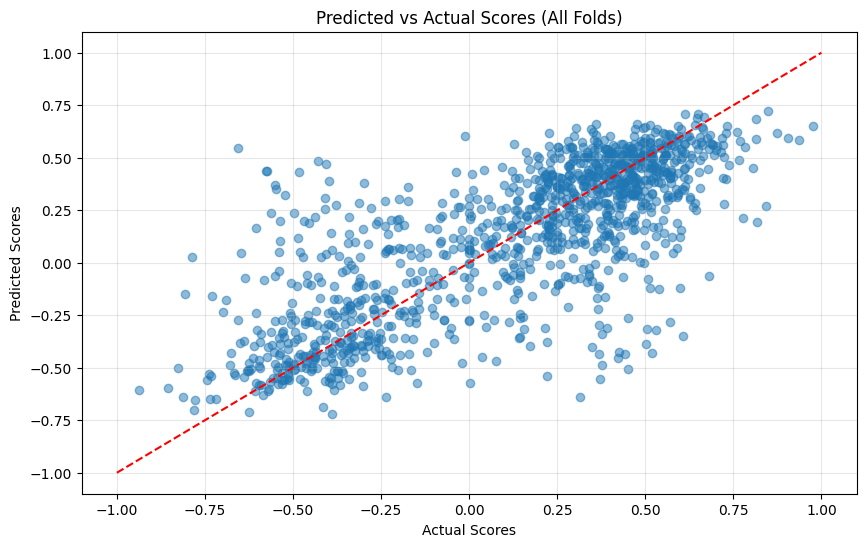

[I 2025-04-23 05:38:43,415] Trial 0 finished with value: 0.06998096380782211 and parameters: {'learning_rate': 1.1438059782109667e-05, 'batch_size': 32, 'epochs': 24}. Best is trial 0 with value: 0.06998096380782211.



Starting Fold 1/10


Training: 100%|██████████| 66/66 [00:03<00:00, 19.61it/s, loss=0.0322]


Epoch 1/10 - Train Loss: 0.0953, Val MSE: 0.0701, Val MAE: 0.1983


Training: 100%|██████████| 66/66 [00:03<00:00, 19.60it/s, loss=0.0978]


Epoch 2/10 - Train Loss: 0.0427, Val MSE: 0.0533, Val MAE: 0.1687


Training: 100%|██████████| 66/66 [00:03<00:00, 19.64it/s, loss=0.0186]


Epoch 3/10 - Train Loss: 0.0260, Val MSE: 0.0545, Val MAE: 0.1659


Training: 100%|██████████| 66/66 [00:03<00:00, 19.70it/s, loss=0.0548]


Epoch 4/10 - Train Loss: 0.0166, Val MSE: 0.0541, Val MAE: 0.1715


Training: 100%|██████████| 66/66 [00:03<00:00, 19.65it/s, loss=0.0093]


Epoch 5/10 - Train Loss: 0.0142, Val MSE: 0.0524, Val MAE: 0.1697


Training: 100%|██████████| 66/66 [00:03<00:00, 19.71it/s, loss=0.0091]


Epoch 6/10 - Train Loss: 0.0128, Val MSE: 0.0510, Val MAE: 0.1677


Training: 100%|██████████| 66/66 [00:03<00:00, 19.59it/s, loss=0.0061]


Epoch 7/10 - Train Loss: 0.0107, Val MSE: 0.0527, Val MAE: 0.1718


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0063]


Epoch 8/10 - Train Loss: 0.0109, Val MSE: 0.0526, Val MAE: 0.1736


Training: 100%|██████████| 66/66 [00:03<00:00, 19.70it/s, loss=0.0131]


Epoch 9/10 - Train Loss: 0.0094, Val MSE: 0.0494, Val MAE: 0.1693


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0062]


Epoch 10/10 - Train Loss: 0.0089, Val MSE: 0.0499, Val MAE: 0.1653
Fold 1 Results - MSE: 0.0499, MAE: 0.1653

Starting Fold 2/10


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0522]


Epoch 1/10 - Train Loss: 0.1056, Val MSE: 0.0713, Val MAE: 0.1975


Training: 100%|██████████| 66/66 [00:03<00:00, 19.59it/s, loss=0.0267]


Epoch 2/10 - Train Loss: 0.0463, Val MSE: 0.0741, Val MAE: 0.1913


Training: 100%|██████████| 66/66 [00:03<00:00, 19.64it/s, loss=0.0312]


Epoch 3/10 - Train Loss: 0.0279, Val MSE: 0.0815, Val MAE: 0.1974


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0104]


Epoch 4/10 - Train Loss: 0.0174, Val MSE: 0.0672, Val MAE: 0.1898


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0060]


Epoch 5/10 - Train Loss: 0.0146, Val MSE: 0.0710, Val MAE: 0.1915


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.0080]


Epoch 6/10 - Train Loss: 0.0116, Val MSE: 0.0804, Val MAE: 0.1986


Training: 100%|██████████| 66/66 [00:03<00:00, 19.59it/s, loss=0.0113]


Epoch 7/10 - Train Loss: 0.0109, Val MSE: 0.0761, Val MAE: 0.1924


Training: 100%|██████████| 66/66 [00:03<00:00, 19.62it/s, loss=0.0071]


Epoch 8/10 - Train Loss: 0.0102, Val MSE: 0.0714, Val MAE: 0.1958


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.0085]


Epoch 9/10 - Train Loss: 0.0093, Val MSE: 0.0674, Val MAE: 0.1874


Training: 100%|██████████| 66/66 [00:03<00:00, 19.63it/s, loss=0.0135]


Epoch 10/10 - Train Loss: 0.0084, Val MSE: 0.0666, Val MAE: 0.1858
Fold 2 Results - MSE: 0.0666, MAE: 0.1858

Starting Fold 3/10


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.1141]


Epoch 1/10 - Train Loss: 0.0958, Val MSE: 0.0832, Val MAE: 0.2120


Training: 100%|██████████| 66/66 [00:03<00:00, 19.60it/s, loss=0.0316]


Epoch 2/10 - Train Loss: 0.0435, Val MSE: 0.0798, Val MAE: 0.2041


Training: 100%|██████████| 66/66 [00:03<00:00, 19.63it/s, loss=0.0260]


Epoch 3/10 - Train Loss: 0.0247, Val MSE: 0.0772, Val MAE: 0.2040


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0137]


Epoch 4/10 - Train Loss: 0.0180, Val MSE: 0.0774, Val MAE: 0.1945


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0101]


Epoch 5/10 - Train Loss: 0.0135, Val MSE: 0.0784, Val MAE: 0.2004


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.0096]


Epoch 6/10 - Train Loss: 0.0130, Val MSE: 0.0758, Val MAE: 0.1953


Training: 100%|██████████| 66/66 [00:03<00:00, 19.64it/s, loss=0.0095]


Epoch 7/10 - Train Loss: 0.0120, Val MSE: 0.0785, Val MAE: 0.1973


Training: 100%|██████████| 66/66 [00:03<00:00, 19.61it/s, loss=0.0153]


Epoch 8/10 - Train Loss: 0.0102, Val MSE: 0.0751, Val MAE: 0.1926


Training: 100%|██████████| 66/66 [00:03<00:00, 19.69it/s, loss=0.0184]


Epoch 9/10 - Train Loss: 0.0101, Val MSE: 0.0736, Val MAE: 0.1929


Training: 100%|██████████| 66/66 [00:03<00:00, 19.60it/s, loss=0.0109]


Epoch 10/10 - Train Loss: 0.0085, Val MSE: 0.0754, Val MAE: 0.1932
Fold 3 Results - MSE: 0.0754, MAE: 0.1932

Starting Fold 4/10


Training: 100%|██████████| 66/66 [00:03<00:00, 19.63it/s, loss=0.0401]


Epoch 1/10 - Train Loss: 0.0957, Val MSE: 0.0805, Val MAE: 0.2250


Training: 100%|██████████| 66/66 [00:03<00:00, 19.64it/s, loss=0.0810]


Epoch 2/10 - Train Loss: 0.0471, Val MSE: 0.0599, Val MAE: 0.1829


Training: 100%|██████████| 66/66 [00:03<00:00, 19.61it/s, loss=0.0110]


Epoch 3/10 - Train Loss: 0.0289, Val MSE: 0.0734, Val MAE: 0.1938


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0190]


Epoch 4/10 - Train Loss: 0.0192, Val MSE: 0.0744, Val MAE: 0.1932


Training: 100%|██████████| 66/66 [00:03<00:00, 19.59it/s, loss=0.0192]


Epoch 5/10 - Train Loss: 0.0145, Val MSE: 0.0700, Val MAE: 0.1871


Training: 100%|██████████| 66/66 [00:03<00:00, 19.69it/s, loss=0.0083]


Epoch 6/10 - Train Loss: 0.0130, Val MSE: 0.0667, Val MAE: 0.1811


Training: 100%|██████████| 66/66 [00:03<00:00, 19.64it/s, loss=0.0109]


Epoch 7/10 - Train Loss: 0.0115, Val MSE: 0.0686, Val MAE: 0.1843


Training: 100%|██████████| 66/66 [00:03<00:00, 19.61it/s, loss=0.0556]


Epoch 8/10 - Train Loss: 0.0104, Val MSE: 0.0592, Val MAE: 0.1750


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.0243]


Epoch 9/10 - Train Loss: 0.0096, Val MSE: 0.0649, Val MAE: 0.1776


Training: 100%|██████████| 66/66 [00:03<00:00, 19.65it/s, loss=0.0120]


Epoch 10/10 - Train Loss: 0.0092, Val MSE: 0.0620, Val MAE: 0.1767
Fold 4 Results - MSE: 0.0620, MAE: 0.1767

Starting Fold 5/10


Training: 100%|██████████| 66/66 [00:03<00:00, 19.63it/s, loss=0.0885]


Epoch 1/10 - Train Loss: 0.1094, Val MSE: 0.0545, Val MAE: 0.1903


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0479]


Epoch 2/10 - Train Loss: 0.0486, Val MSE: 0.0465, Val MAE: 0.1643


Training: 100%|██████████| 66/66 [00:03<00:00, 19.64it/s, loss=0.0069]


Epoch 3/10 - Train Loss: 0.0259, Val MSE: 0.0480, Val MAE: 0.1718


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0124]


Epoch 4/10 - Train Loss: 0.0209, Val MSE: 0.0402, Val MAE: 0.1522


Training: 100%|██████████| 66/66 [00:03<00:00, 19.70it/s, loss=0.0155]


Epoch 5/10 - Train Loss: 0.0154, Val MSE: 0.0419, Val MAE: 0.1556


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.0157]


Epoch 6/10 - Train Loss: 0.0131, Val MSE: 0.0375, Val MAE: 0.1477


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.0058]


Epoch 7/10 - Train Loss: 0.0115, Val MSE: 0.0400, Val MAE: 0.1573


Training: 100%|██████████| 66/66 [00:03<00:00, 19.62it/s, loss=0.0165]


Epoch 8/10 - Train Loss: 0.0106, Val MSE: 0.0433, Val MAE: 0.1617


Training: 100%|██████████| 66/66 [00:03<00:00, 19.69it/s, loss=0.0068]


Epoch 9/10 - Train Loss: 0.0101, Val MSE: 0.0441, Val MAE: 0.1612


Training: 100%|██████████| 66/66 [00:03<00:00, 19.69it/s, loss=0.0089]


Epoch 10/10 - Train Loss: 0.0096, Val MSE: 0.0391, Val MAE: 0.1538
Fold 5 Results - MSE: 0.0391, MAE: 0.1538

Starting Fold 6/10


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0429]


Epoch 1/10 - Train Loss: 0.0935, Val MSE: 0.0799, Val MAE: 0.2057


Training: 100%|██████████| 66/66 [00:03<00:00, 19.54it/s, loss=0.0465]


Epoch 2/10 - Train Loss: 0.0485, Val MSE: 0.0777, Val MAE: 0.2036


Training: 100%|██████████| 66/66 [00:03<00:00, 19.52it/s, loss=0.0264]


Epoch 3/10 - Train Loss: 0.0262, Val MSE: 0.0757, Val MAE: 0.1996


Training: 100%|██████████| 66/66 [00:03<00:00, 19.69it/s, loss=0.0180]


Epoch 4/10 - Train Loss: 0.0185, Val MSE: 0.0778, Val MAE: 0.1976


Training: 100%|██████████| 66/66 [00:03<00:00, 19.62it/s, loss=0.0083]


Epoch 5/10 - Train Loss: 0.0143, Val MSE: 0.0800, Val MAE: 0.2005


Training: 100%|██████████| 66/66 [00:03<00:00, 19.65it/s, loss=0.0128]


Epoch 6/10 - Train Loss: 0.0128, Val MSE: 0.0778, Val MAE: 0.1959


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.0086]


Epoch 7/10 - Train Loss: 0.0098, Val MSE: 0.0727, Val MAE: 0.1923


Training: 100%|██████████| 66/66 [00:03<00:00, 19.63it/s, loss=0.0070]


Epoch 8/10 - Train Loss: 0.0093, Val MSE: 0.0653, Val MAE: 0.1837


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0060]


Epoch 9/10 - Train Loss: 0.0089, Val MSE: 0.0713, Val MAE: 0.1854


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0054]


Epoch 10/10 - Train Loss: 0.0085, Val MSE: 0.0709, Val MAE: 0.1898
Fold 6 Results - MSE: 0.0709, MAE: 0.1898

Starting Fold 7/10


Training: 100%|██████████| 66/66 [00:03<00:00, 19.64it/s, loss=0.0575]


Epoch 1/10 - Train Loss: 0.0994, Val MSE: 0.1007, Val MAE: 0.2249


Training: 100%|██████████| 66/66 [00:03<00:00, 19.64it/s, loss=0.0556]


Epoch 2/10 - Train Loss: 0.0492, Val MSE: 0.0970, Val MAE: 0.2227


Training: 100%|██████████| 66/66 [00:03<00:00, 19.63it/s, loss=0.0298]


Epoch 3/10 - Train Loss: 0.0273, Val MSE: 0.0977, Val MAE: 0.2170


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.0173]


Epoch 4/10 - Train Loss: 0.0184, Val MSE: 0.0910, Val MAE: 0.2075


Training: 100%|██████████| 66/66 [00:03<00:00, 19.65it/s, loss=0.0124]


Epoch 5/10 - Train Loss: 0.0155, Val MSE: 0.0934, Val MAE: 0.2086


Training: 100%|██████████| 66/66 [00:03<00:00, 19.65it/s, loss=0.0117]


Epoch 6/10 - Train Loss: 0.0138, Val MSE: 0.0915, Val MAE: 0.2062


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0126]


Epoch 7/10 - Train Loss: 0.0133, Val MSE: 0.0890, Val MAE: 0.2040


Training: 100%|██████████| 66/66 [00:03<00:00, 19.46it/s, loss=0.0062]


Epoch 8/10 - Train Loss: 0.0110, Val MSE: 0.0887, Val MAE: 0.2037


Training: 100%|██████████| 66/66 [00:03<00:00, 19.27it/s, loss=0.0433]


Epoch 9/10 - Train Loss: 0.0109, Val MSE: 0.0868, Val MAE: 0.1998


Training: 100%|██████████| 66/66 [00:03<00:00, 19.55it/s, loss=0.0033]


Epoch 10/10 - Train Loss: 0.0097, Val MSE: 0.1014, Val MAE: 0.2200
Fold 7 Results - MSE: 0.1014, MAE: 0.2200

Starting Fold 8/10


Training: 100%|██████████| 66/66 [00:03<00:00, 19.64it/s, loss=0.0343]


Epoch 1/10 - Train Loss: 0.1007, Val MSE: 0.0597, Val MAE: 0.1815


Training: 100%|██████████| 66/66 [00:03<00:00, 19.65it/s, loss=0.0137]


Epoch 2/10 - Train Loss: 0.0467, Val MSE: 0.0653, Val MAE: 0.1764


Training: 100%|██████████| 66/66 [00:03<00:00, 19.64it/s, loss=0.0188]


Epoch 3/10 - Train Loss: 0.0275, Val MSE: 0.0637, Val MAE: 0.1737


Training: 100%|██████████| 66/66 [00:03<00:00, 19.65it/s, loss=0.0331]


Epoch 4/10 - Train Loss: 0.0203, Val MSE: 0.0689, Val MAE: 0.1749


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0109]


Epoch 5/10 - Train Loss: 0.0155, Val MSE: 0.0812, Val MAE: 0.1917


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.0074]


Epoch 6/10 - Train Loss: 0.0123, Val MSE: 0.0711, Val MAE: 0.1855


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0155]


Epoch 7/10 - Train Loss: 0.0134, Val MSE: 0.0696, Val MAE: 0.1791


Training: 100%|██████████| 66/66 [00:03<00:00, 19.62it/s, loss=0.0157]


Epoch 8/10 - Train Loss: 0.0111, Val MSE: 0.0627, Val MAE: 0.1691


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0032]


Epoch 9/10 - Train Loss: 0.0098, Val MSE: 0.0626, Val MAE: 0.1682


Training: 100%|██████████| 66/66 [00:03<00:00, 19.65it/s, loss=0.0119]


Epoch 10/10 - Train Loss: 0.0098, Val MSE: 0.0647, Val MAE: 0.1724
Fold 8 Results - MSE: 0.0647, MAE: 0.1724

Starting Fold 9/10


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.1038]


Epoch 1/10 - Train Loss: 0.0950, Val MSE: 0.0806, Val MAE: 0.2101


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0416]


Epoch 2/10 - Train Loss: 0.0451, Val MSE: 0.0744, Val MAE: 0.1985


Training: 100%|██████████| 66/66 [00:03<00:00, 19.63it/s, loss=0.0181]


Epoch 3/10 - Train Loss: 0.0257, Val MSE: 0.0712, Val MAE: 0.1845


Training: 100%|██████████| 66/66 [00:03<00:00, 19.65it/s, loss=0.0250]


Epoch 4/10 - Train Loss: 0.0170, Val MSE: 0.0734, Val MAE: 0.1871


Training: 100%|██████████| 66/66 [00:03<00:00, 19.65it/s, loss=0.0182]


Epoch 5/10 - Train Loss: 0.0144, Val MSE: 0.0724, Val MAE: 0.1835


Training: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=0.0115]


Epoch 6/10 - Train Loss: 0.0117, Val MSE: 0.0734, Val MAE: 0.1866


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0192]


Epoch 7/10 - Train Loss: 0.0097, Val MSE: 0.0794, Val MAE: 0.1936


Training: 100%|██████████| 66/66 [00:03<00:00, 19.62it/s, loss=0.0060]


Epoch 8/10 - Train Loss: 0.0105, Val MSE: 0.0725, Val MAE: 0.1876


Training: 100%|██████████| 66/66 [00:03<00:00, 19.66it/s, loss=0.0070]


Epoch 9/10 - Train Loss: 0.0091, Val MSE: 0.0711, Val MAE: 0.1796


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0080]


Epoch 10/10 - Train Loss: 0.0097, Val MSE: 0.0779, Val MAE: 0.1867
Fold 9 Results - MSE: 0.0779, MAE: 0.1867

Starting Fold 10/10


Training: 100%|██████████| 66/66 [00:03<00:00, 19.61it/s, loss=0.0870]


Epoch 1/10 - Train Loss: 0.1167, Val MSE: 0.0638, Val MAE: 0.1930


Training: 100%|██████████| 66/66 [00:03<00:00, 19.67it/s, loss=0.0724]


Epoch 2/10 - Train Loss: 0.0501, Val MSE: 0.0598, Val MAE: 0.1750


Training: 100%|██████████| 66/66 [00:03<00:00, 19.62it/s, loss=0.0509]


Epoch 3/10 - Train Loss: 0.0272, Val MSE: 0.0648, Val MAE: 0.1842


Training: 100%|██████████| 66/66 [00:03<00:00, 19.11it/s, loss=0.0166]


Epoch 4/10 - Train Loss: 0.0189, Val MSE: 0.0667, Val MAE: 0.1862


Training: 100%|██████████| 66/66 [00:03<00:00, 19.30it/s, loss=0.0165]


Epoch 5/10 - Train Loss: 0.0150, Val MSE: 0.0601, Val MAE: 0.1830


Training: 100%|██████████| 66/66 [00:03<00:00, 19.44it/s, loss=0.0083]


Epoch 6/10 - Train Loss: 0.0124, Val MSE: 0.0604, Val MAE: 0.1810


Training: 100%|██████████| 66/66 [00:03<00:00, 19.52it/s, loss=0.0105]


Epoch 7/10 - Train Loss: 0.0110, Val MSE: 0.0599, Val MAE: 0.1727


Training: 100%|██████████| 66/66 [00:03<00:00, 19.43it/s, loss=0.0028]


Epoch 8/10 - Train Loss: 0.0100, Val MSE: 0.0603, Val MAE: 0.1822


Training: 100%|██████████| 66/66 [00:03<00:00, 19.43it/s, loss=0.0039]


Epoch 9/10 - Train Loss: 0.0093, Val MSE: 0.0643, Val MAE: 0.1832


Training: 100%|██████████| 66/66 [00:03<00:00, 19.50it/s, loss=0.0087]


Epoch 10/10 - Train Loss: 0.0093, Val MSE: 0.0568, Val MAE: 0.1749
Fold 10 Results - MSE: 0.0568, MAE: 0.1749

Cross-Validation Results:
Average MSE: 0.0665 ± 0.0170
Average MAE: 0.1819 ± 0.0180


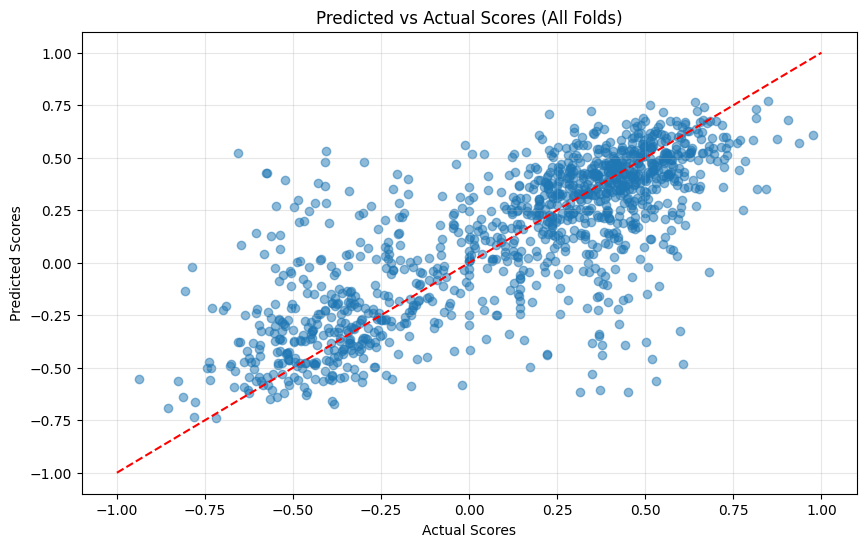

[I 2025-04-23 05:44:37,815] Trial 1 finished with value: 0.06647978867593973 and parameters: {'learning_rate': 1.7823820184543283e-05, 'batch_size': 16, 'epochs': 10}. Best is trial 1 with value: 0.06647978867593973.



Starting Fold 1/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.74it/s, loss=0.0943]


Epoch 1/10 - Train Loss: 0.1383, Val MSE: 0.0674, Val MAE: 0.1870


Training: 100%|██████████| 33/33 [00:02<00:00, 11.74it/s, loss=0.0748]


Epoch 2/10 - Train Loss: 0.0491, Val MSE: 0.0627, Val MAE: 0.1872


Training: 100%|██████████| 33/33 [00:02<00:00, 11.75it/s, loss=0.0230]


Epoch 3/10 - Train Loss: 0.0267, Val MSE: 0.0715, Val MAE: 0.1977


Training: 100%|██████████| 33/33 [00:02<00:00, 11.75it/s, loss=0.0143]


Epoch 4/10 - Train Loss: 0.0164, Val MSE: 0.0681, Val MAE: 0.1864


Training: 100%|██████████| 33/33 [00:02<00:00, 11.73it/s, loss=0.0152]


Epoch 5/10 - Train Loss: 0.0128, Val MSE: 0.0602, Val MAE: 0.1805


Training: 100%|██████████| 33/33 [00:02<00:00, 11.74it/s, loss=0.0201]


Epoch 6/10 - Train Loss: 0.0118, Val MSE: 0.0553, Val MAE: 0.1719


Training: 100%|██████████| 33/33 [00:02<00:00, 11.73it/s, loss=0.0094]


Epoch 7/10 - Train Loss: 0.0101, Val MSE: 0.0546, Val MAE: 0.1650


Training: 100%|██████████| 33/33 [00:02<00:00, 11.75it/s, loss=0.0430]


Epoch 8/10 - Train Loss: 0.0095, Val MSE: 0.0557, Val MAE: 0.1701


Training: 100%|██████████| 33/33 [00:02<00:00, 11.71it/s, loss=0.0075]


Epoch 9/10 - Train Loss: 0.0076, Val MSE: 0.0563, Val MAE: 0.1738


Training: 100%|██████████| 33/33 [00:02<00:00, 11.68it/s, loss=0.0069]


Epoch 10/10 - Train Loss: 0.0078, Val MSE: 0.0546, Val MAE: 0.1687
Fold 1 Results - MSE: 0.0546, MAE: 0.1687

Starting Fold 2/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.72it/s, loss=0.0858]


Epoch 1/10 - Train Loss: 0.1034, Val MSE: 0.0763, Val MAE: 0.2068


Training: 100%|██████████| 33/33 [00:02<00:00, 11.71it/s, loss=0.0564]


Epoch 2/10 - Train Loss: 0.0438, Val MSE: 0.0852, Val MAE: 0.2071


Training: 100%|██████████| 33/33 [00:02<00:00, 11.69it/s, loss=0.0352]


Epoch 3/10 - Train Loss: 0.0243, Val MSE: 0.0694, Val MAE: 0.1855


Training: 100%|██████████| 33/33 [00:02<00:00, 11.69it/s, loss=0.0119]


Epoch 4/10 - Train Loss: 0.0156, Val MSE: 0.0728, Val MAE: 0.1904


Training: 100%|██████████| 33/33 [00:02<00:00, 11.74it/s, loss=0.0060]


Epoch 5/10 - Train Loss: 0.0132, Val MSE: 0.0741, Val MAE: 0.1967


Training: 100%|██████████| 33/33 [00:02<00:00, 11.72it/s, loss=0.0043]


Epoch 6/10 - Train Loss: 0.0106, Val MSE: 0.0691, Val MAE: 0.1878


Training: 100%|██████████| 33/33 [00:02<00:00, 11.69it/s, loss=0.0069]


Epoch 7/10 - Train Loss: 0.0081, Val MSE: 0.0704, Val MAE: 0.1877


Training: 100%|██████████| 33/33 [00:02<00:00, 11.70it/s, loss=0.0062]


Epoch 8/10 - Train Loss: 0.0080, Val MSE: 0.0705, Val MAE: 0.1882


Training: 100%|██████████| 33/33 [00:02<00:00, 11.70it/s, loss=0.0043]


Epoch 9/10 - Train Loss: 0.0066, Val MSE: 0.0666, Val MAE: 0.1839


Training: 100%|██████████| 33/33 [00:02<00:00, 11.63it/s, loss=0.0126]


Epoch 10/10 - Train Loss: 0.0071, Val MSE: 0.0701, Val MAE: 0.1844
Fold 2 Results - MSE: 0.0701, MAE: 0.1844

Starting Fold 3/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.71it/s, loss=0.0566]


Epoch 1/10 - Train Loss: 0.1037, Val MSE: 0.0835, Val MAE: 0.2012


Training: 100%|██████████| 33/33 [00:02<00:00, 11.66it/s, loss=0.0780]


Epoch 2/10 - Train Loss: 0.0446, Val MSE: 0.0805, Val MAE: 0.2134


Training: 100%|██████████| 33/33 [00:02<00:00, 11.65it/s, loss=0.0203]


Epoch 3/10 - Train Loss: 0.0255, Val MSE: 0.0729, Val MAE: 0.1927


Training: 100%|██████████| 33/33 [00:02<00:00, 11.72it/s, loss=0.0118]


Epoch 4/10 - Train Loss: 0.0158, Val MSE: 0.0733, Val MAE: 0.1856


Training: 100%|██████████| 33/33 [00:02<00:00, 11.72it/s, loss=0.0097]


Epoch 5/10 - Train Loss: 0.0119, Val MSE: 0.0703, Val MAE: 0.1816


Training: 100%|██████████| 33/33 [00:02<00:00, 11.73it/s, loss=0.0069]


Epoch 6/10 - Train Loss: 0.0110, Val MSE: 0.0722, Val MAE: 0.1862


Training: 100%|██████████| 33/33 [00:02<00:00, 11.71it/s, loss=0.0124]


Epoch 7/10 - Train Loss: 0.0108, Val MSE: 0.0703, Val MAE: 0.1832


Training: 100%|██████████| 33/33 [00:02<00:00, 11.73it/s, loss=0.0145]


Epoch 8/10 - Train Loss: 0.0094, Val MSE: 0.0701, Val MAE: 0.1877


Training: 100%|██████████| 33/33 [00:02<00:00, 11.73it/s, loss=0.0081]


Epoch 9/10 - Train Loss: 0.0082, Val MSE: 0.0649, Val MAE: 0.1726


Training: 100%|██████████| 33/33 [00:02<00:00, 11.74it/s, loss=0.0116]


Epoch 10/10 - Train Loss: 0.0072, Val MSE: 0.0662, Val MAE: 0.1787
Fold 3 Results - MSE: 0.0662, MAE: 0.1787

Starting Fold 4/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.70it/s, loss=0.0442]


Epoch 1/10 - Train Loss: 0.1004, Val MSE: 0.0752, Val MAE: 0.2067


Training: 100%|██████████| 33/33 [00:02<00:00, 11.68it/s, loss=0.0695]


Epoch 2/10 - Train Loss: 0.0353, Val MSE: 0.0685, Val MAE: 0.1947


Training: 100%|██████████| 33/33 [00:02<00:00, 11.70it/s, loss=0.0190]


Epoch 3/10 - Train Loss: 0.0217, Val MSE: 0.0745, Val MAE: 0.2001


Training: 100%|██████████| 33/33 [00:02<00:00, 11.71it/s, loss=0.0200]


Epoch 4/10 - Train Loss: 0.0162, Val MSE: 0.0691, Val MAE: 0.1884


Training: 100%|██████████| 33/33 [00:02<00:00, 11.74it/s, loss=0.0167]


Epoch 5/10 - Train Loss: 0.0125, Val MSE: 0.0643, Val MAE: 0.1836


Training: 100%|██████████| 33/33 [00:02<00:00, 11.73it/s, loss=0.0091]


Epoch 6/10 - Train Loss: 0.0108, Val MSE: 0.0732, Val MAE: 0.1889


Training: 100%|██████████| 33/33 [00:02<00:00, 11.69it/s, loss=0.0105]


Epoch 7/10 - Train Loss: 0.0102, Val MSE: 0.0743, Val MAE: 0.1946


Training: 100%|██████████| 33/33 [00:02<00:00, 11.72it/s, loss=0.0290]


Epoch 8/10 - Train Loss: 0.0100, Val MSE: 0.0676, Val MAE: 0.1859


Training: 100%|██████████| 33/33 [00:02<00:00, 11.71it/s, loss=0.0051]


Epoch 9/10 - Train Loss: 0.0093, Val MSE: 0.0715, Val MAE: 0.1875


Training: 100%|██████████| 33/33 [00:02<00:00, 11.74it/s, loss=0.0056]


Epoch 10/10 - Train Loss: 0.0081, Val MSE: 0.0706, Val MAE: 0.1862
Fold 4 Results - MSE: 0.0706, MAE: 0.1862

Starting Fold 5/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.71it/s, loss=0.0999]


Epoch 1/10 - Train Loss: 0.1066, Val MSE: 0.0532, Val MAE: 0.1799


Training: 100%|██████████| 33/33 [00:02<00:00, 11.67it/s, loss=0.0774]


Epoch 2/10 - Train Loss: 0.0472, Val MSE: 0.0421, Val MAE: 0.1542


Training: 100%|██████████| 33/33 [00:02<00:00, 11.73it/s, loss=0.0159]


Epoch 3/10 - Train Loss: 0.0221, Val MSE: 0.0420, Val MAE: 0.1602


Training: 100%|██████████| 33/33 [00:02<00:00, 11.68it/s, loss=0.0203]


Epoch 4/10 - Train Loss: 0.0160, Val MSE: 0.0400, Val MAE: 0.1551


Training: 100%|██████████| 33/33 [00:02<00:00, 11.71it/s, loss=0.0092]


Epoch 5/10 - Train Loss: 0.0122, Val MSE: 0.0399, Val MAE: 0.1521


Training: 100%|██████████| 33/33 [00:02<00:00, 11.72it/s, loss=0.0131]


Epoch 6/10 - Train Loss: 0.0113, Val MSE: 0.0380, Val MAE: 0.1491


Training: 100%|██████████| 33/33 [00:02<00:00, 11.73it/s, loss=0.0042]


Epoch 7/10 - Train Loss: 0.0119, Val MSE: 0.0452, Val MAE: 0.1619


Training: 100%|██████████| 33/33 [00:02<00:00, 11.81it/s, loss=0.0217]


Epoch 8/10 - Train Loss: 0.0095, Val MSE: 0.0389, Val MAE: 0.1557


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0064]


Epoch 9/10 - Train Loss: 0.0089, Val MSE: 0.0375, Val MAE: 0.1467


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0066]


Epoch 10/10 - Train Loss: 0.0076, Val MSE: 0.0383, Val MAE: 0.1507
Fold 5 Results - MSE: 0.0383, MAE: 0.1507

Starting Fold 6/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.88it/s, loss=0.1014]


Epoch 1/10 - Train Loss: 0.1145, Val MSE: 0.0825, Val MAE: 0.2208


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0350]


Epoch 2/10 - Train Loss: 0.0492, Val MSE: 0.0685, Val MAE: 0.1981


Training: 100%|██████████| 33/33 [00:02<00:00, 11.87it/s, loss=0.0188]


Epoch 3/10 - Train Loss: 0.0236, Val MSE: 0.0771, Val MAE: 0.2043


Training: 100%|██████████| 33/33 [00:02<00:00, 11.79it/s, loss=0.0161]


Epoch 4/10 - Train Loss: 0.0162, Val MSE: 0.0684, Val MAE: 0.2011


Training: 100%|██████████| 33/33 [00:02<00:00, 11.84it/s, loss=0.0120]


Epoch 5/10 - Train Loss: 0.0120, Val MSE: 0.0684, Val MAE: 0.1959


Training: 100%|██████████| 33/33 [00:02<00:00, 11.88it/s, loss=0.0122]


Epoch 6/10 - Train Loss: 0.0115, Val MSE: 0.0645, Val MAE: 0.1851


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0040]


Epoch 7/10 - Train Loss: 0.0093, Val MSE: 0.0651, Val MAE: 0.1837


Training: 100%|██████████| 33/33 [00:02<00:00, 11.88it/s, loss=0.0041]


Epoch 8/10 - Train Loss: 0.0086, Val MSE: 0.0705, Val MAE: 0.1946


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0112]


Epoch 9/10 - Train Loss: 0.0078, Val MSE: 0.0641, Val MAE: 0.1864


Training: 100%|██████████| 33/33 [00:02<00:00, 11.88it/s, loss=0.0055]


Epoch 10/10 - Train Loss: 0.0073, Val MSE: 0.0716, Val MAE: 0.1983
Fold 6 Results - MSE: 0.0716, MAE: 0.1983

Starting Fold 7/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.87it/s, loss=0.1413]


Epoch 1/10 - Train Loss: 0.0993, Val MSE: 0.1095, Val MAE: 0.2354


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0252]


Epoch 2/10 - Train Loss: 0.0401, Val MSE: 0.0856, Val MAE: 0.2111


Training: 100%|██████████| 33/33 [00:02<00:00, 11.86it/s, loss=0.0090]


Epoch 3/10 - Train Loss: 0.0228, Val MSE: 0.0913, Val MAE: 0.2114


Training: 100%|██████████| 33/33 [00:02<00:00, 11.85it/s, loss=0.0130]


Epoch 4/10 - Train Loss: 0.0170, Val MSE: 0.0868, Val MAE: 0.2038


Training: 100%|██████████| 33/33 [00:02<00:00, 11.85it/s, loss=0.0143]


Epoch 5/10 - Train Loss: 0.0138, Val MSE: 0.0928, Val MAE: 0.2135


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0078]


Epoch 6/10 - Train Loss: 0.0125, Val MSE: 0.0750, Val MAE: 0.1942


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0091]


Epoch 7/10 - Train Loss: 0.0105, Val MSE: 0.0868, Val MAE: 0.2081


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0058]


Epoch 8/10 - Train Loss: 0.0093, Val MSE: 0.0862, Val MAE: 0.2041


Training: 100%|██████████| 33/33 [00:02<00:00, 11.88it/s, loss=0.0082]


Epoch 9/10 - Train Loss: 0.0086, Val MSE: 0.0807, Val MAE: 0.1991


Training: 100%|██████████| 33/33 [00:02<00:00, 11.87it/s, loss=0.0068]


Epoch 10/10 - Train Loss: 0.0069, Val MSE: 0.0836, Val MAE: 0.1945
Fold 7 Results - MSE: 0.0836, MAE: 0.1945

Starting Fold 8/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0615]


Epoch 1/10 - Train Loss: 0.0984, Val MSE: 0.0809, Val MAE: 0.2131


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0463]


Epoch 2/10 - Train Loss: 0.0434, Val MSE: 0.0570, Val MAE: 0.1783


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0171]


Epoch 3/10 - Train Loss: 0.0227, Val MSE: 0.0651, Val MAE: 0.1838


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0148]


Epoch 4/10 - Train Loss: 0.0170, Val MSE: 0.0513, Val MAE: 0.1611


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0118]


Epoch 5/10 - Train Loss: 0.0131, Val MSE: 0.0639, Val MAE: 0.1916


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0140]


Epoch 6/10 - Train Loss: 0.0117, Val MSE: 0.0501, Val MAE: 0.1560


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0087]


Epoch 7/10 - Train Loss: 0.0099, Val MSE: 0.0593, Val MAE: 0.1741


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0067]


Epoch 8/10 - Train Loss: 0.0102, Val MSE: 0.0518, Val MAE: 0.1602


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0072]


Epoch 9/10 - Train Loss: 0.0081, Val MSE: 0.0519, Val MAE: 0.1637


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0052]


Epoch 10/10 - Train Loss: 0.0078, Val MSE: 0.0573, Val MAE: 0.1607
Fold 8 Results - MSE: 0.0573, MAE: 0.1607

Starting Fold 9/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0854]


Epoch 1/10 - Train Loss: 0.1003, Val MSE: 0.0828, Val MAE: 0.2120


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0381]


Epoch 2/10 - Train Loss: 0.0444, Val MSE: 0.0775, Val MAE: 0.1921


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0400]


Epoch 3/10 - Train Loss: 0.0234, Val MSE: 0.0749, Val MAE: 0.1879


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0159]


Epoch 4/10 - Train Loss: 0.0153, Val MSE: 0.0869, Val MAE: 0.2061


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0097]


Epoch 5/10 - Train Loss: 0.0133, Val MSE: 0.0732, Val MAE: 0.1825


Training: 100%|██████████| 33/33 [00:02<00:00, 11.88it/s, loss=0.0103]


Epoch 6/10 - Train Loss: 0.0106, Val MSE: 0.0703, Val MAE: 0.1799


Training: 100%|██████████| 33/33 [00:02<00:00, 11.86it/s, loss=0.0077]


Epoch 7/10 - Train Loss: 0.0092, Val MSE: 0.0753, Val MAE: 0.1771


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0061]


Epoch 8/10 - Train Loss: 0.0087, Val MSE: 0.0712, Val MAE: 0.1833


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0095]


Epoch 9/10 - Train Loss: 0.0075, Val MSE: 0.0734, Val MAE: 0.1823


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0059]


Epoch 10/10 - Train Loss: 0.0064, Val MSE: 0.0735, Val MAE: 0.1861
Fold 9 Results - MSE: 0.0735, MAE: 0.1861

Starting Fold 10/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0570]


Epoch 1/10 - Train Loss: 0.1162, Val MSE: 0.0770, Val MAE: 0.2084


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0524]


Epoch 2/10 - Train Loss: 0.0472, Val MSE: 0.0638, Val MAE: 0.1824


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0503]


Epoch 3/10 - Train Loss: 0.0266, Val MSE: 0.0640, Val MAE: 0.1775


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0114]


Epoch 4/10 - Train Loss: 0.0170, Val MSE: 0.0646, Val MAE: 0.1911


Training: 100%|██████████| 33/33 [00:02<00:00, 11.84it/s, loss=0.0145]


Epoch 5/10 - Train Loss: 0.0140, Val MSE: 0.0667, Val MAE: 0.1885


Training: 100%|██████████| 33/33 [00:02<00:00, 11.82it/s, loss=0.0107]


Epoch 6/10 - Train Loss: 0.0118, Val MSE: 0.0598, Val MAE: 0.1803


Training: 100%|██████████| 33/33 [00:02<00:00, 11.85it/s, loss=0.0123]


Epoch 7/10 - Train Loss: 0.0108, Val MSE: 0.0608, Val MAE: 0.1804


Training: 100%|██████████| 33/33 [00:02<00:00, 11.84it/s, loss=0.0167]


Epoch 8/10 - Train Loss: 0.0094, Val MSE: 0.0590, Val MAE: 0.1779


Training: 100%|██████████| 33/33 [00:02<00:00, 11.82it/s, loss=0.0032]


Epoch 9/10 - Train Loss: 0.0088, Val MSE: 0.0605, Val MAE: 0.1790


Training: 100%|██████████| 33/33 [00:02<00:00, 11.85it/s, loss=0.0076]


Epoch 10/10 - Train Loss: 0.0084, Val MSE: 0.0558, Val MAE: 0.1747
Fold 10 Results - MSE: 0.0558, MAE: 0.1747

Cross-Validation Results:
Average MSE: 0.0641 ± 0.0128
Average MAE: 0.1783 ± 0.0149


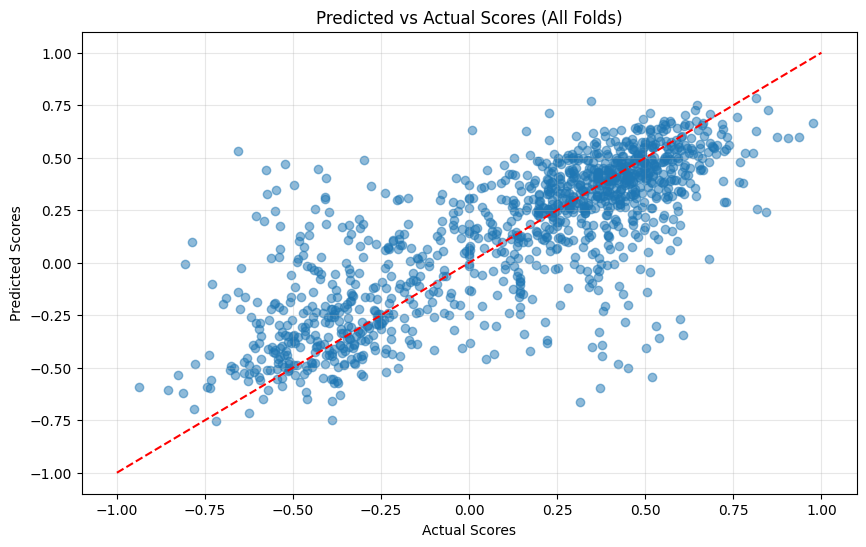

[I 2025-04-23 05:49:35,024] Trial 2 finished with value: 0.06414243366137881 and parameters: {'learning_rate': 4.3104895310519284e-05, 'batch_size': 32, 'epochs': 21}. Best is trial 2 with value: 0.06414243366137881.



Starting Fold 1/10


Training: 100%|██████████| 17/17 [00:01<00:00,  8.80it/s, loss=0.0931]


Epoch 1/10 - Train Loss: 0.1328, Val MSE: 0.0905, Val MAE: 0.2220


Training: 100%|██████████| 17/17 [00:01<00:00,  9.01it/s, loss=0.0401]


Epoch 2/10 - Train Loss: 0.0570, Val MSE: 0.0789, Val MAE: 0.2003


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0211]


Epoch 3/10 - Train Loss: 0.0335, Val MSE: 0.0713, Val MAE: 0.1922


Training: 100%|██████████| 17/17 [00:01<00:00,  9.01it/s, loss=0.0197]


Epoch 4/10 - Train Loss: 0.0215, Val MSE: 0.0718, Val MAE: 0.1902


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0204]


Epoch 5/10 - Train Loss: 0.0154, Val MSE: 0.0670, Val MAE: 0.1869


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0148]


Epoch 6/10 - Train Loss: 0.0130, Val MSE: 0.0679, Val MAE: 0.1862


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0159]


Epoch 7/10 - Train Loss: 0.0117, Val MSE: 0.0664, Val MAE: 0.1812


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0393]


Epoch 8/10 - Train Loss: 0.0110, Val MSE: 0.0688, Val MAE: 0.1846


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0419]


Epoch 9/10 - Train Loss: 0.0112, Val MSE: 0.0659, Val MAE: 0.1839


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0109]


Epoch 10/10 - Train Loss: 0.0094, Val MSE: 0.0634, Val MAE: 0.1791
Fold 1 Results - MSE: 0.0634, MAE: 0.1791

Starting Fold 2/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0620]


Epoch 1/10 - Train Loss: 0.1456, Val MSE: 0.1005, Val MAE: 0.2366


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0439]


Epoch 2/10 - Train Loss: 0.0628, Val MSE: 0.0805, Val MAE: 0.2070


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0125]


Epoch 3/10 - Train Loss: 0.0351, Val MSE: 0.0796, Val MAE: 0.1997


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0247]


Epoch 4/10 - Train Loss: 0.0228, Val MSE: 0.0807, Val MAE: 0.2017


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0158]


Epoch 5/10 - Train Loss: 0.0174, Val MSE: 0.0862, Val MAE: 0.2045


Training: 100%|██████████| 17/17 [00:01<00:00,  9.02it/s, loss=0.0075]


Epoch 6/10 - Train Loss: 0.0125, Val MSE: 0.0787, Val MAE: 0.2009


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0174]


Epoch 7/10 - Train Loss: 0.0115, Val MSE: 0.0796, Val MAE: 0.1976


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0083]


Epoch 8/10 - Train Loss: 0.0101, Val MSE: 0.0800, Val MAE: 0.1987


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0057]


Epoch 9/10 - Train Loss: 0.0092, Val MSE: 0.0761, Val MAE: 0.1929


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0094]


Epoch 10/10 - Train Loss: 0.0083, Val MSE: 0.0779, Val MAE: 0.2009
Fold 2 Results - MSE: 0.0779, MAE: 0.2009

Starting Fold 3/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0934]


Epoch 1/10 - Train Loss: 0.1067, Val MSE: 0.0862, Val MAE: 0.2162


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0666]


Epoch 2/10 - Train Loss: 0.0511, Val MSE: 0.0803, Val MAE: 0.2057


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0198]


Epoch 3/10 - Train Loss: 0.0330, Val MSE: 0.0840, Val MAE: 0.1984


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0237]


Epoch 4/10 - Train Loss: 0.0226, Val MSE: 0.0808, Val MAE: 0.1960


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0107]


Epoch 5/10 - Train Loss: 0.0160, Val MSE: 0.0795, Val MAE: 0.1929


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0107]


Epoch 6/10 - Train Loss: 0.0133, Val MSE: 0.0824, Val MAE: 0.1983


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0155]


Epoch 7/10 - Train Loss: 0.0126, Val MSE: 0.0751, Val MAE: 0.1863


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0227]


Epoch 8/10 - Train Loss: 0.0118, Val MSE: 0.0785, Val MAE: 0.1967


Training: 100%|██████████| 17/17 [00:01<00:00,  9.02it/s, loss=0.0101]


Epoch 9/10 - Train Loss: 0.0102, Val MSE: 0.0773, Val MAE: 0.1873


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0136]


Epoch 10/10 - Train Loss: 0.0104, Val MSE: 0.0777, Val MAE: 0.1912
Fold 3 Results - MSE: 0.0777, MAE: 0.1912

Starting Fold 4/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.02it/s, loss=0.1009]


Epoch 1/10 - Train Loss: 0.1036, Val MSE: 0.0828, Val MAE: 0.2260


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0699]


Epoch 2/10 - Train Loss: 0.0511, Val MSE: 0.0774, Val MAE: 0.2055


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0290]


Epoch 3/10 - Train Loss: 0.0324, Val MSE: 0.0728, Val MAE: 0.1978


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0164]


Epoch 4/10 - Train Loss: 0.0199, Val MSE: 0.0680, Val MAE: 0.1893


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0213]


Epoch 5/10 - Train Loss: 0.0156, Val MSE: 0.0656, Val MAE: 0.1808


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0198]


Epoch 6/10 - Train Loss: 0.0145, Val MSE: 0.0703, Val MAE: 0.1845


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0107]


Epoch 7/10 - Train Loss: 0.0118, Val MSE: 0.0749, Val MAE: 0.1935


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0107]


Epoch 8/10 - Train Loss: 0.0117, Val MSE: 0.0690, Val MAE: 0.1820


Training: 100%|██████████| 17/17 [00:01<00:00,  9.01it/s, loss=0.0103]


Epoch 9/10 - Train Loss: 0.0102, Val MSE: 0.0679, Val MAE: 0.1772


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0349]


Epoch 10/10 - Train Loss: 0.0102, Val MSE: 0.0647, Val MAE: 0.1722
Fold 4 Results - MSE: 0.0647, MAE: 0.1722

Starting Fold 5/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0869]


Epoch 1/10 - Train Loss: 0.1012, Val MSE: 0.0592, Val MAE: 0.1825


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0219]


Epoch 2/10 - Train Loss: 0.0514, Val MSE: 0.0496, Val MAE: 0.1726


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0291]


Epoch 3/10 - Train Loss: 0.0345, Val MSE: 0.0512, Val MAE: 0.1736


Training: 100%|██████████| 17/17 [00:01<00:00,  9.02it/s, loss=0.0282]


Epoch 4/10 - Train Loss: 0.0265, Val MSE: 0.0528, Val MAE: 0.1748


Training: 100%|██████████| 17/17 [00:01<00:00,  9.00it/s, loss=0.0172]


Epoch 5/10 - Train Loss: 0.0187, Val MSE: 0.0420, Val MAE: 0.1594


Training: 100%|██████████| 17/17 [00:01<00:00,  8.99it/s, loss=0.0149]


Epoch 6/10 - Train Loss: 0.0149, Val MSE: 0.0438, Val MAE: 0.1577


Training: 100%|██████████| 17/17 [00:01<00:00,  9.02it/s, loss=0.0139]


Epoch 7/10 - Train Loss: 0.0135, Val MSE: 0.0415, Val MAE: 0.1562


Training: 100%|██████████| 17/17 [00:01<00:00,  8.99it/s, loss=0.0091]


Epoch 8/10 - Train Loss: 0.0119, Val MSE: 0.0415, Val MAE: 0.1586


Training: 100%|██████████| 17/17 [00:01<00:00,  9.00it/s, loss=0.0087]


Epoch 9/10 - Train Loss: 0.0103, Val MSE: 0.0474, Val MAE: 0.1690


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0199]


Epoch 10/10 - Train Loss: 0.0097, Val MSE: 0.0440, Val MAE: 0.1647
Fold 5 Results - MSE: 0.0440, MAE: 0.1647

Starting Fold 6/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0861]


Epoch 1/10 - Train Loss: 0.1180, Val MSE: 0.0753, Val MAE: 0.2008


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0399]


Epoch 2/10 - Train Loss: 0.0532, Val MSE: 0.0725, Val MAE: 0.1972


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0356]


Epoch 3/10 - Train Loss: 0.0336, Val MSE: 0.0663, Val MAE: 0.1819


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0125]


Epoch 4/10 - Train Loss: 0.0202, Val MSE: 0.0664, Val MAE: 0.1839


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0184]


Epoch 5/10 - Train Loss: 0.0160, Val MSE: 0.0671, Val MAE: 0.1813


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0108]


Epoch 6/10 - Train Loss: 0.0136, Val MSE: 0.0649, Val MAE: 0.1807


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0354]


Epoch 7/10 - Train Loss: 0.0115, Val MSE: 0.0631, Val MAE: 0.1769


Training: 100%|██████████| 17/17 [00:01<00:00,  9.02it/s, loss=0.0083]


Epoch 8/10 - Train Loss: 0.0095, Val MSE: 0.0641, Val MAE: 0.1811


Training: 100%|██████████| 17/17 [00:01<00:00,  8.97it/s, loss=0.0108]


Epoch 9/10 - Train Loss: 0.0088, Val MSE: 0.0664, Val MAE: 0.1831


Training: 100%|██████████| 17/17 [00:01<00:00,  8.97it/s, loss=0.0119]


Epoch 10/10 - Train Loss: 0.0086, Val MSE: 0.0698, Val MAE: 0.1885
Fold 6 Results - MSE: 0.0698, MAE: 0.1885

Starting Fold 7/10


Training: 100%|██████████| 17/17 [00:01<00:00,  8.96it/s, loss=0.0516]


Epoch 1/10 - Train Loss: 0.1179, Val MSE: 0.1146, Val MAE: 0.2497


Training: 100%|██████████| 17/17 [00:01<00:00,  9.01it/s, loss=0.0801]


Epoch 2/10 - Train Loss: 0.0530, Val MSE: 0.1128, Val MAE: 0.2483


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0300]


Epoch 3/10 - Train Loss: 0.0343, Val MSE: 0.0989, Val MAE: 0.2204


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0286]


Epoch 4/10 - Train Loss: 0.0213, Val MSE: 0.0929, Val MAE: 0.2137


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0120]


Epoch 5/10 - Train Loss: 0.0160, Val MSE: 0.0950, Val MAE: 0.2154


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0084]


Epoch 6/10 - Train Loss: 0.0127, Val MSE: 0.0952, Val MAE: 0.2144


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0158]


Epoch 7/10 - Train Loss: 0.0119, Val MSE: 0.0933, Val MAE: 0.2090


Training: 100%|██████████| 17/17 [00:01<00:00,  9.02it/s, loss=0.0090]


Epoch 8/10 - Train Loss: 0.0110, Val MSE: 0.0992, Val MAE: 0.2161


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0072]


Epoch 9/10 - Train Loss: 0.0098, Val MSE: 0.0920, Val MAE: 0.2089


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0054]


Epoch 10/10 - Train Loss: 0.0096, Val MSE: 0.0912, Val MAE: 0.2070
Fold 7 Results - MSE: 0.0912, MAE: 0.2070

Starting Fold 8/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0961]


Epoch 1/10 - Train Loss: 0.1081, Val MSE: 0.0614, Val MAE: 0.1978


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0307]


Epoch 2/10 - Train Loss: 0.0531, Val MSE: 0.0570, Val MAE: 0.1789


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0163]


Epoch 3/10 - Train Loss: 0.0328, Val MSE: 0.0621, Val MAE: 0.1812


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0333]


Epoch 4/10 - Train Loss: 0.0247, Val MSE: 0.0564, Val MAE: 0.1680


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0468]


Epoch 5/10 - Train Loss: 0.0190, Val MSE: 0.0589, Val MAE: 0.1727


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0126]


Epoch 6/10 - Train Loss: 0.0133, Val MSE: 0.0521, Val MAE: 0.1631


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0187]


Epoch 7/10 - Train Loss: 0.0126, Val MSE: 0.0519, Val MAE: 0.1642


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0134]


Epoch 8/10 - Train Loss: 0.0111, Val MSE: 0.0623, Val MAE: 0.1761


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0110]


Epoch 9/10 - Train Loss: 0.0097, Val MSE: 0.0563, Val MAE: 0.1669


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0088]


Epoch 10/10 - Train Loss: 0.0095, Val MSE: 0.0511, Val MAE: 0.1580
Fold 8 Results - MSE: 0.0511, MAE: 0.1580

Starting Fold 9/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0891]


Epoch 1/10 - Train Loss: 0.1422, Val MSE: 0.0950, Val MAE: 0.2299


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0384]


Epoch 2/10 - Train Loss: 0.0637, Val MSE: 0.0801, Val MAE: 0.2045


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0531]


Epoch 3/10 - Train Loss: 0.0389, Val MSE: 0.0771, Val MAE: 0.2010


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0272]


Epoch 4/10 - Train Loss: 0.0243, Val MSE: 0.0821, Val MAE: 0.2029


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0177]


Epoch 5/10 - Train Loss: 0.0182, Val MSE: 0.0835, Val MAE: 0.2015


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0170]


Epoch 6/10 - Train Loss: 0.0140, Val MSE: 0.0756, Val MAE: 0.1935


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0180]


Epoch 7/10 - Train Loss: 0.0116, Val MSE: 0.0762, Val MAE: 0.1961


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0132]


Epoch 8/10 - Train Loss: 0.0107, Val MSE: 0.0740, Val MAE: 0.1852


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0094]


Epoch 9/10 - Train Loss: 0.0091, Val MSE: 0.0725, Val MAE: 0.1831


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0101]


Epoch 10/10 - Train Loss: 0.0079, Val MSE: 0.0730, Val MAE: 0.1831
Fold 9 Results - MSE: 0.0730, MAE: 0.1831

Starting Fold 10/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.1071]


Epoch 1/10 - Train Loss: 0.1080, Val MSE: 0.0655, Val MAE: 0.1896


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0548]


Epoch 2/10 - Train Loss: 0.0525, Val MSE: 0.0626, Val MAE: 0.1830


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0286]


Epoch 3/10 - Train Loss: 0.0328, Val MSE: 0.0573, Val MAE: 0.1735


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0171]


Epoch 4/10 - Train Loss: 0.0189, Val MSE: 0.0569, Val MAE: 0.1744


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0143]


Epoch 5/10 - Train Loss: 0.0144, Val MSE: 0.0598, Val MAE: 0.1790


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0111]


Epoch 6/10 - Train Loss: 0.0130, Val MSE: 0.0655, Val MAE: 0.1888


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0134]


Epoch 7/10 - Train Loss: 0.0111, Val MSE: 0.0618, Val MAE: 0.1826


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0069]


Epoch 8/10 - Train Loss: 0.0104, Val MSE: 0.0604, Val MAE: 0.1802


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0075]


Epoch 9/10 - Train Loss: 0.0099, Val MSE: 0.0568, Val MAE: 0.1708


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0074]


Epoch 10/10 - Train Loss: 0.0086, Val MSE: 0.0598, Val MAE: 0.1820
Fold 10 Results - MSE: 0.0598, MAE: 0.1820

Cross-Validation Results:
Average MSE: 0.0673 ± 0.0138
Average MAE: 0.1827 ± 0.0152


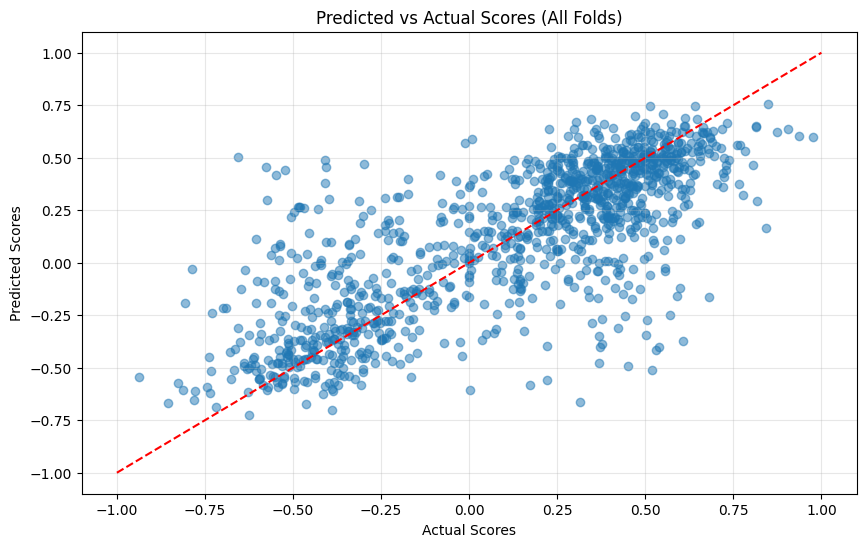

[I 2025-04-23 05:52:55,856] Trial 3 finished with value: 0.06726579556760877 and parameters: {'learning_rate': 2.8445234089739034e-05, 'batch_size': 64, 'epochs': 23}. Best is trial 2 with value: 0.06414243366137881.



Starting Fold 1/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0893]


Epoch 1/10 - Train Loss: 0.1225, Val MSE: 0.0751, Val MAE: 0.2078


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0457]


Epoch 2/10 - Train Loss: 0.0482, Val MSE: 0.0703, Val MAE: 0.1994


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0192]


Epoch 3/10 - Train Loss: 0.0283, Val MSE: 0.0542, Val MAE: 0.1667


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0215]


Epoch 4/10 - Train Loss: 0.0187, Val MSE: 0.0515, Val MAE: 0.1590


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0118]


Epoch 5/10 - Train Loss: 0.0132, Val MSE: 0.0481, Val MAE: 0.1639


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0069]


Epoch 6/10 - Train Loss: 0.0102, Val MSE: 0.0614, Val MAE: 0.1765


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0055]


Epoch 7/10 - Train Loss: 0.0099, Val MSE: 0.0522, Val MAE: 0.1630


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0086]


Epoch 8/10 - Train Loss: 0.0089, Val MSE: 0.0581, Val MAE: 0.1717


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0042]


Epoch 9/10 - Train Loss: 0.0081, Val MSE: 0.0564, Val MAE: 0.1669


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0074]


Epoch 10/10 - Train Loss: 0.0072, Val MSE: 0.0588, Val MAE: 0.1753
Fold 1 Results - MSE: 0.0588, MAE: 0.1753

Starting Fold 2/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0634]


Epoch 1/10 - Train Loss: 0.1074, Val MSE: 0.0672, Val MAE: 0.1850


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0455]


Epoch 2/10 - Train Loss: 0.0457, Val MSE: 0.0668, Val MAE: 0.1868


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0232]


Epoch 3/10 - Train Loss: 0.0239, Val MSE: 0.0676, Val MAE: 0.1769


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0127]


Epoch 4/10 - Train Loss: 0.0152, Val MSE: 0.0668, Val MAE: 0.1779


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0151]


Epoch 5/10 - Train Loss: 0.0130, Val MSE: 0.0673, Val MAE: 0.1784


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0111]


Epoch 6/10 - Train Loss: 0.0104, Val MSE: 0.0664, Val MAE: 0.1755


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0095]


Epoch 7/10 - Train Loss: 0.0093, Val MSE: 0.0668, Val MAE: 0.1811


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0151]


Epoch 8/10 - Train Loss: 0.0084, Val MSE: 0.0658, Val MAE: 0.1769


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0379]


Epoch 9/10 - Train Loss: 0.0083, Val MSE: 0.0632, Val MAE: 0.1773


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0091]


Epoch 10/10 - Train Loss: 0.0080, Val MSE: 0.0633, Val MAE: 0.1792
Fold 2 Results - MSE: 0.0633, MAE: 0.1792

Starting Fold 3/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0824]


Epoch 1/10 - Train Loss: 0.1000, Val MSE: 0.0899, Val MAE: 0.2116


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0606]


Epoch 2/10 - Train Loss: 0.0447, Val MSE: 0.0939, Val MAE: 0.2171


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0305]


Epoch 3/10 - Train Loss: 0.0273, Val MSE: 0.0804, Val MAE: 0.1959


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0248]


Epoch 4/10 - Train Loss: 0.0184, Val MSE: 0.0729, Val MAE: 0.1869


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0111]


Epoch 5/10 - Train Loss: 0.0134, Val MSE: 0.0734, Val MAE: 0.1844


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0102]


Epoch 6/10 - Train Loss: 0.0107, Val MSE: 0.0703, Val MAE: 0.1814


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0100]


Epoch 7/10 - Train Loss: 0.0095, Val MSE: 0.0719, Val MAE: 0.1837


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0121]


Epoch 8/10 - Train Loss: 0.0096, Val MSE: 0.0717, Val MAE: 0.1817


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0061]


Epoch 9/10 - Train Loss: 0.0094, Val MSE: 0.0682, Val MAE: 0.1745


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0063]


Epoch 10/10 - Train Loss: 0.0089, Val MSE: 0.0732, Val MAE: 0.1868
Fold 3 Results - MSE: 0.0732, MAE: 0.1868

Starting Fold 4/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0507]


Epoch 1/10 - Train Loss: 0.1079, Val MSE: 0.0862, Val MAE: 0.2145


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0561]


Epoch 2/10 - Train Loss: 0.0439, Val MSE: 0.0715, Val MAE: 0.1948


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0261]


Epoch 3/10 - Train Loss: 0.0300, Val MSE: 0.0821, Val MAE: 0.2050


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0153]


Epoch 4/10 - Train Loss: 0.0189, Val MSE: 0.0755, Val MAE: 0.1976


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0104]


Epoch 5/10 - Train Loss: 0.0148, Val MSE: 0.0790, Val MAE: 0.1991


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0101]


Epoch 6/10 - Train Loss: 0.0125, Val MSE: 0.0695, Val MAE: 0.1869


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0165]


Epoch 7/10 - Train Loss: 0.0106, Val MSE: 0.0655, Val MAE: 0.1820


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0221]


Epoch 8/10 - Train Loss: 0.0092, Val MSE: 0.0732, Val MAE: 0.1882


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0087]


Epoch 9/10 - Train Loss: 0.0086, Val MSE: 0.0692, Val MAE: 0.1809


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0029]


Epoch 10/10 - Train Loss: 0.0081, Val MSE: 0.0732, Val MAE: 0.1879
Fold 4 Results - MSE: 0.0732, MAE: 0.1879

Starting Fold 5/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0682]


Epoch 1/10 - Train Loss: 0.0970, Val MSE: 0.0420, Val MAE: 0.1629


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0229]


Epoch 2/10 - Train Loss: 0.0421, Val MSE: 0.0478, Val MAE: 0.1729


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0245]


Epoch 3/10 - Train Loss: 0.0227, Val MSE: 0.0417, Val MAE: 0.1614


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0156]


Epoch 4/10 - Train Loss: 0.0156, Val MSE: 0.0472, Val MAE: 0.1706


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0090]


Epoch 5/10 - Train Loss: 0.0128, Val MSE: 0.0382, Val MAE: 0.1568


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0090]


Epoch 6/10 - Train Loss: 0.0117, Val MSE: 0.0385, Val MAE: 0.1537


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0074]


Epoch 7/10 - Train Loss: 0.0112, Val MSE: 0.0383, Val MAE: 0.1554


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0097]


Epoch 8/10 - Train Loss: 0.0095, Val MSE: 0.0407, Val MAE: 0.1554


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0104]


Epoch 9/10 - Train Loss: 0.0092, Val MSE: 0.0395, Val MAE: 0.1547


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0068]


Epoch 10/10 - Train Loss: 0.0085, Val MSE: 0.0419, Val MAE: 0.1614
Fold 5 Results - MSE: 0.0419, MAE: 0.1614

Starting Fold 6/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0637]


Epoch 1/10 - Train Loss: 0.1026, Val MSE: 0.0804, Val MAE: 0.2067


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0468]


Epoch 2/10 - Train Loss: 0.0435, Val MSE: 0.0718, Val MAE: 0.1925


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0227]


Epoch 3/10 - Train Loss: 0.0242, Val MSE: 0.0701, Val MAE: 0.1910


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0089]


Epoch 4/10 - Train Loss: 0.0146, Val MSE: 0.0738, Val MAE: 0.1868


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0158]


Epoch 5/10 - Train Loss: 0.0128, Val MSE: 0.0725, Val MAE: 0.1917


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0138]


Epoch 6/10 - Train Loss: 0.0110, Val MSE: 0.0626, Val MAE: 0.1772


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0090]


Epoch 7/10 - Train Loss: 0.0088, Val MSE: 0.0666, Val MAE: 0.1799


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0100]


Epoch 8/10 - Train Loss: 0.0085, Val MSE: 0.0658, Val MAE: 0.1783


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0068]


Epoch 9/10 - Train Loss: 0.0079, Val MSE: 0.0648, Val MAE: 0.1741


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0054]


Epoch 10/10 - Train Loss: 0.0075, Val MSE: 0.0627, Val MAE: 0.1745
Fold 6 Results - MSE: 0.0627, MAE: 0.1745

Starting Fold 7/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0947]


Epoch 1/10 - Train Loss: 0.0961, Val MSE: 0.0974, Val MAE: 0.2104


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0627]


Epoch 2/10 - Train Loss: 0.0416, Val MSE: 0.1038, Val MAE: 0.2212


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0145]


Epoch 3/10 - Train Loss: 0.0255, Val MSE: 0.1004, Val MAE: 0.2197


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0175]


Epoch 4/10 - Train Loss: 0.0166, Val MSE: 0.0942, Val MAE: 0.2111


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0304]


Epoch 5/10 - Train Loss: 0.0142, Val MSE: 0.0934, Val MAE: 0.2079


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0095]


Epoch 6/10 - Train Loss: 0.0124, Val MSE: 0.0892, Val MAE: 0.2045


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0099]


Epoch 7/10 - Train Loss: 0.0108, Val MSE: 0.0888, Val MAE: 0.2036


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0064]


Epoch 8/10 - Train Loss: 0.0088, Val MSE: 0.0883, Val MAE: 0.2015


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0092]


Epoch 9/10 - Train Loss: 0.0084, Val MSE: 0.0946, Val MAE: 0.2091


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0111]


Epoch 10/10 - Train Loss: 0.0076, Val MSE: 0.0852, Val MAE: 0.1979
Fold 7 Results - MSE: 0.0852, MAE: 0.1979

Starting Fold 8/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0694]


Epoch 1/10 - Train Loss: 0.1053, Val MSE: 0.0736, Val MAE: 0.2093


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0392]


Epoch 2/10 - Train Loss: 0.0443, Val MSE: 0.0730, Val MAE: 0.2025


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0297]


Epoch 3/10 - Train Loss: 0.0253, Val MSE: 0.0607, Val MAE: 0.1790


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0176]


Epoch 4/10 - Train Loss: 0.0180, Val MSE: 0.0735, Val MAE: 0.2028


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0172]


Epoch 5/10 - Train Loss: 0.0139, Val MSE: 0.0673, Val MAE: 0.1819


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0097]


Epoch 6/10 - Train Loss: 0.0129, Val MSE: 0.0668, Val MAE: 0.1786


Training: 100%|██████████| 33/33 [00:02<00:00, 11.98it/s, loss=0.0066]


Epoch 7/10 - Train Loss: 0.0110, Val MSE: 0.0628, Val MAE: 0.1835


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0065]


Epoch 8/10 - Train Loss: 0.0097, Val MSE: 0.0678, Val MAE: 0.1863


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0072]


Epoch 9/10 - Train Loss: 0.0110, Val MSE: 0.0611, Val MAE: 0.1788


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0071]


Epoch 10/10 - Train Loss: 0.0088, Val MSE: 0.0623, Val MAE: 0.1782
Fold 8 Results - MSE: 0.0623, MAE: 0.1782

Starting Fold 9/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0975]


Epoch 1/10 - Train Loss: 0.1063, Val MSE: 0.0833, Val MAE: 0.2083


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0394]


Epoch 2/10 - Train Loss: 0.0408, Val MSE: 0.0836, Val MAE: 0.1974


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0177]


Epoch 3/10 - Train Loss: 0.0225, Val MSE: 0.0755, Val MAE: 0.1871


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0181]


Epoch 4/10 - Train Loss: 0.0161, Val MSE: 0.0787, Val MAE: 0.1881


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0223]


Epoch 5/10 - Train Loss: 0.0120, Val MSE: 0.0750, Val MAE: 0.1864


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0117]


Epoch 6/10 - Train Loss: 0.0103, Val MSE: 0.0739, Val MAE: 0.1884


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0094]


Epoch 7/10 - Train Loss: 0.0093, Val MSE: 0.0744, Val MAE: 0.1852


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0141]


Epoch 8/10 - Train Loss: 0.0085, Val MSE: 0.0743, Val MAE: 0.1824


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0087]


Epoch 9/10 - Train Loss: 0.0074, Val MSE: 0.0755, Val MAE: 0.1873


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0086]


Epoch 10/10 - Train Loss: 0.0072, Val MSE: 0.0767, Val MAE: 0.1825
Fold 9 Results - MSE: 0.0767, MAE: 0.1825

Starting Fold 10/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0663]


Epoch 1/10 - Train Loss: 0.1369, Val MSE: 0.0576, Val MAE: 0.1748


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0403]


Epoch 2/10 - Train Loss: 0.0506, Val MSE: 0.0632, Val MAE: 0.1806


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0323]


Epoch 3/10 - Train Loss: 0.0234, Val MSE: 0.0571, Val MAE: 0.1739


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0148]


Epoch 4/10 - Train Loss: 0.0150, Val MSE: 0.0549, Val MAE: 0.1694


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0064]


Epoch 5/10 - Train Loss: 0.0120, Val MSE: 0.0615, Val MAE: 0.1742


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0102]


Epoch 6/10 - Train Loss: 0.0117, Val MSE: 0.0564, Val MAE: 0.1726


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0095]


Epoch 7/10 - Train Loss: 0.0110, Val MSE: 0.0540, Val MAE: 0.1641


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0100]


Epoch 8/10 - Train Loss: 0.0095, Val MSE: 0.0580, Val MAE: 0.1663


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0186]


Epoch 9/10 - Train Loss: 0.0085, Val MSE: 0.0579, Val MAE: 0.1693


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0085]


Epoch 10/10 - Train Loss: 0.0088, Val MSE: 0.0619, Val MAE: 0.1872
Fold 10 Results - MSE: 0.0619, MAE: 0.1872

Cross-Validation Results:
Average MSE: 0.0659 ± 0.0119
Average MAE: 0.1811 ± 0.0099


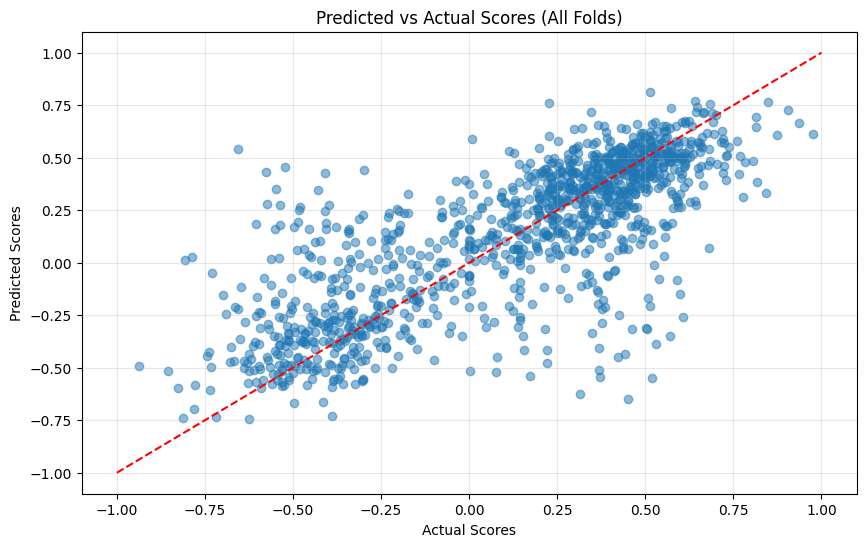

[I 2025-04-23 05:57:49,211] Trial 4 finished with value: 0.06591515904582021 and parameters: {'learning_rate': 3.5962825334672545e-05, 'batch_size': 32, 'epochs': 15}. Best is trial 2 with value: 0.06414243366137881.



Starting Fold 1/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0970]


Epoch 1/10 - Train Loss: 0.1086, Val MSE: 0.0677, Val MAE: 0.1987


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0439]


Epoch 2/10 - Train Loss: 0.0435, Val MSE: 0.0667, Val MAE: 0.1904


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0264]


Epoch 3/10 - Train Loss: 0.0233, Val MSE: 0.0790, Val MAE: 0.2074


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0095]


Epoch 4/10 - Train Loss: 0.0180, Val MSE: 0.0621, Val MAE: 0.1811


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0159]


Epoch 5/10 - Train Loss: 0.0131, Val MSE: 0.0571, Val MAE: 0.1765


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0522]


Epoch 6/10 - Train Loss: 0.0111, Val MSE: 0.0584, Val MAE: 0.1751


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0078]


Epoch 7/10 - Train Loss: 0.0108, Val MSE: 0.0638, Val MAE: 0.1840


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0060]


Epoch 8/10 - Train Loss: 0.0091, Val MSE: 0.0584, Val MAE: 0.1739


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0096]


Epoch 9/10 - Train Loss: 0.0082, Val MSE: 0.0582, Val MAE: 0.1772


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0089]


Epoch 10/10 - Train Loss: 0.0082, Val MSE: 0.0599, Val MAE: 0.1793
Fold 1 Results - MSE: 0.0599, MAE: 0.1793

Starting Fold 2/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0741]


Epoch 1/10 - Train Loss: 0.0966, Val MSE: 0.0667, Val MAE: 0.1845


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0419]


Epoch 2/10 - Train Loss: 0.0436, Val MSE: 0.0670, Val MAE: 0.1898


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0213]


Epoch 3/10 - Train Loss: 0.0255, Val MSE: 0.0661, Val MAE: 0.1881


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0172]


Epoch 4/10 - Train Loss: 0.0162, Val MSE: 0.0705, Val MAE: 0.1980


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0235]


Epoch 5/10 - Train Loss: 0.0133, Val MSE: 0.0698, Val MAE: 0.1945


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0120]


Epoch 6/10 - Train Loss: 0.0114, Val MSE: 0.0704, Val MAE: 0.1968


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0083]


Epoch 7/10 - Train Loss: 0.0101, Val MSE: 0.0683, Val MAE: 0.1888


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0057]


Epoch 8/10 - Train Loss: 0.0080, Val MSE: 0.0661, Val MAE: 0.1881


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0093]


Epoch 9/10 - Train Loss: 0.0073, Val MSE: 0.0683, Val MAE: 0.1877


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0055]


Epoch 10/10 - Train Loss: 0.0072, Val MSE: 0.0667, Val MAE: 0.1848
Fold 2 Results - MSE: 0.0667, MAE: 0.1848

Starting Fold 3/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0754]


Epoch 1/10 - Train Loss: 0.1058, Val MSE: 0.0794, Val MAE: 0.1938


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0389]


Epoch 2/10 - Train Loss: 0.0438, Val MSE: 0.0746, Val MAE: 0.1888


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0350]


Epoch 3/10 - Train Loss: 0.0226, Val MSE: 0.0717, Val MAE: 0.1812


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0113]


Epoch 4/10 - Train Loss: 0.0155, Val MSE: 0.0717, Val MAE: 0.1833


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0070]


Epoch 5/10 - Train Loss: 0.0133, Val MSE: 0.0651, Val MAE: 0.1751


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0132]


Epoch 6/10 - Train Loss: 0.0117, Val MSE: 0.0656, Val MAE: 0.1753


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0061]


Epoch 7/10 - Train Loss: 0.0102, Val MSE: 0.0587, Val MAE: 0.1621


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0070]


Epoch 8/10 - Train Loss: 0.0090, Val MSE: 0.0608, Val MAE: 0.1682


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0065]


Epoch 9/10 - Train Loss: 0.0080, Val MSE: 0.0579, Val MAE: 0.1620


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0085]


Epoch 10/10 - Train Loss: 0.0082, Val MSE: 0.0579, Val MAE: 0.1667
Fold 3 Results - MSE: 0.0579, MAE: 0.1667

Starting Fold 4/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0913]


Epoch 1/10 - Train Loss: 0.1036, Val MSE: 0.0806, Val MAE: 0.2148


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0220]


Epoch 2/10 - Train Loss: 0.0459, Val MSE: 0.0699, Val MAE: 0.2015


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0181]


Epoch 3/10 - Train Loss: 0.0212, Val MSE: 0.0653, Val MAE: 0.1891


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0201]


Epoch 4/10 - Train Loss: 0.0157, Val MSE: 0.0728, Val MAE: 0.1945


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0093]


Epoch 5/10 - Train Loss: 0.0133, Val MSE: 0.0743, Val MAE: 0.1991


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0114]


Epoch 6/10 - Train Loss: 0.0112, Val MSE: 0.0695, Val MAE: 0.1910


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0161]


Epoch 7/10 - Train Loss: 0.0107, Val MSE: 0.0716, Val MAE: 0.1951


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0211]


Epoch 8/10 - Train Loss: 0.0089, Val MSE: 0.0672, Val MAE: 0.1845


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0229]


Epoch 9/10 - Train Loss: 0.0086, Val MSE: 0.0651, Val MAE: 0.1804


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0032]


Epoch 10/10 - Train Loss: 0.0075, Val MSE: 0.0657, Val MAE: 0.1866
Fold 4 Results - MSE: 0.0657, MAE: 0.1866

Starting Fold 5/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0480]


Epoch 1/10 - Train Loss: 0.1102, Val MSE: 0.0513, Val MAE: 0.1752


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0453]


Epoch 2/10 - Train Loss: 0.0441, Val MSE: 0.0426, Val MAE: 0.1583


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0252]


Epoch 3/10 - Train Loss: 0.0225, Val MSE: 0.0408, Val MAE: 0.1555


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0110]


Epoch 4/10 - Train Loss: 0.0153, Val MSE: 0.0381, Val MAE: 0.1472


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0096]


Epoch 5/10 - Train Loss: 0.0128, Val MSE: 0.0405, Val MAE: 0.1623


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0107]


Epoch 6/10 - Train Loss: 0.0120, Val MSE: 0.0395, Val MAE: 0.1541


Training: 100%|██████████| 33/33 [00:02<00:00, 11.88it/s, loss=0.0058]


Epoch 7/10 - Train Loss: 0.0104, Val MSE: 0.0415, Val MAE: 0.1607


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0043]


Epoch 8/10 - Train Loss: 0.0101, Val MSE: 0.0389, Val MAE: 0.1548


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0044]


Epoch 9/10 - Train Loss: 0.0095, Val MSE: 0.0410, Val MAE: 0.1587


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0038]


Epoch 10/10 - Train Loss: 0.0089, Val MSE: 0.0367, Val MAE: 0.1479
Fold 5 Results - MSE: 0.0367, MAE: 0.1479

Starting Fold 6/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.1046]


Epoch 1/10 - Train Loss: 0.1175, Val MSE: 0.0854, Val MAE: 0.2226


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0367]


Epoch 2/10 - Train Loss: 0.0447, Val MSE: 0.0592, Val MAE: 0.1771


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0179]


Epoch 3/10 - Train Loss: 0.0214, Val MSE: 0.0625, Val MAE: 0.1727


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0184]


Epoch 4/10 - Train Loss: 0.0134, Val MSE: 0.0652, Val MAE: 0.1806


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0117]


Epoch 5/10 - Train Loss: 0.0116, Val MSE: 0.0671, Val MAE: 0.1799


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0081]


Epoch 6/10 - Train Loss: 0.0109, Val MSE: 0.0587, Val MAE: 0.1671


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0087]


Epoch 7/10 - Train Loss: 0.0084, Val MSE: 0.0663, Val MAE: 0.1834


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0077]


Epoch 8/10 - Train Loss: 0.0079, Val MSE: 0.0650, Val MAE: 0.1784


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0080]


Epoch 9/10 - Train Loss: 0.0078, Val MSE: 0.0674, Val MAE: 0.1859


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0112]


Epoch 10/10 - Train Loss: 0.0083, Val MSE: 0.0630, Val MAE: 0.1805
Fold 6 Results - MSE: 0.0630, MAE: 0.1805

Starting Fold 7/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0362]


Epoch 1/10 - Train Loss: 0.1015, Val MSE: 0.0967, Val MAE: 0.2258


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0373]


Epoch 2/10 - Train Loss: 0.0455, Val MSE: 0.0872, Val MAE: 0.2037


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0270]


Epoch 3/10 - Train Loss: 0.0234, Val MSE: 0.0913, Val MAE: 0.2085


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0147]


Epoch 4/10 - Train Loss: 0.0153, Val MSE: 0.0907, Val MAE: 0.2033


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0110]


Epoch 5/10 - Train Loss: 0.0136, Val MSE: 0.0995, Val MAE: 0.2194


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0061]


Epoch 6/10 - Train Loss: 0.0113, Val MSE: 0.0826, Val MAE: 0.2002


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0067]


Epoch 7/10 - Train Loss: 0.0114, Val MSE: 0.0783, Val MAE: 0.1985


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0037]


Epoch 8/10 - Train Loss: 0.0102, Val MSE: 0.0841, Val MAE: 0.2030


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0198]


Epoch 9/10 - Train Loss: 0.0103, Val MSE: 0.0830, Val MAE: 0.1967


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0067]


Epoch 10/10 - Train Loss: 0.0082, Val MSE: 0.0863, Val MAE: 0.1992
Fold 7 Results - MSE: 0.0863, MAE: 0.1992

Starting Fold 8/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.1033]


Epoch 1/10 - Train Loss: 0.1039, Val MSE: 0.0715, Val MAE: 0.2044


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0439]


Epoch 2/10 - Train Loss: 0.0462, Val MSE: 0.0601, Val MAE: 0.1823


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0402]


Epoch 3/10 - Train Loss: 0.0260, Val MSE: 0.0616, Val MAE: 0.1806


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0107]


Epoch 4/10 - Train Loss: 0.0172, Val MSE: 0.0628, Val MAE: 0.1742


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0109]


Epoch 5/10 - Train Loss: 0.0130, Val MSE: 0.0547, Val MAE: 0.1647


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0092]


Epoch 6/10 - Train Loss: 0.0122, Val MSE: 0.0718, Val MAE: 0.1822


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0370]


Epoch 7/10 - Train Loss: 0.0107, Val MSE: 0.0630, Val MAE: 0.1744


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0128]


Epoch 8/10 - Train Loss: 0.0093, Val MSE: 0.0682, Val MAE: 0.1761


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0045]


Epoch 9/10 - Train Loss: 0.0083, Val MSE: 0.0645, Val MAE: 0.1723


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0123]


Epoch 10/10 - Train Loss: 0.0077, Val MSE: 0.0618, Val MAE: 0.1726
Fold 8 Results - MSE: 0.0618, MAE: 0.1726

Starting Fold 9/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0767]


Epoch 1/10 - Train Loss: 0.0997, Val MSE: 0.0903, Val MAE: 0.2119


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0432]


Epoch 2/10 - Train Loss: 0.0423, Val MSE: 0.0931, Val MAE: 0.2226


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0086]


Epoch 3/10 - Train Loss: 0.0279, Val MSE: 0.0795, Val MAE: 0.1935


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0226]


Epoch 4/10 - Train Loss: 0.0167, Val MSE: 0.0759, Val MAE: 0.1831


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0125]


Epoch 5/10 - Train Loss: 0.0130, Val MSE: 0.0762, Val MAE: 0.1863


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0131]


Epoch 6/10 - Train Loss: 0.0108, Val MSE: 0.0764, Val MAE: 0.1838


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0058]


Epoch 7/10 - Train Loss: 0.0092, Val MSE: 0.0757, Val MAE: 0.1787


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0051]


Epoch 8/10 - Train Loss: 0.0088, Val MSE: 0.0755, Val MAE: 0.1815


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0059]


Epoch 9/10 - Train Loss: 0.0075, Val MSE: 0.0791, Val MAE: 0.1892


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0105]


Epoch 10/10 - Train Loss: 0.0066, Val MSE: 0.0827, Val MAE: 0.1913
Fold 9 Results - MSE: 0.0827, MAE: 0.1913

Starting Fold 10/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.87it/s, loss=0.0760]


Epoch 1/10 - Train Loss: 0.1037, Val MSE: 0.0612, Val MAE: 0.1681


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0482]


Epoch 2/10 - Train Loss: 0.0468, Val MSE: 0.0646, Val MAE: 0.1753


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0124]


Epoch 3/10 - Train Loss: 0.0265, Val MSE: 0.0673, Val MAE: 0.1844


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0217]


Epoch 4/10 - Train Loss: 0.0193, Val MSE: 0.0655, Val MAE: 0.1747


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0097]


Epoch 5/10 - Train Loss: 0.0132, Val MSE: 0.0627, Val MAE: 0.1795


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0132]


Epoch 6/10 - Train Loss: 0.0127, Val MSE: 0.0631, Val MAE: 0.1805


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0101]


Epoch 7/10 - Train Loss: 0.0118, Val MSE: 0.0618, Val MAE: 0.1746


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0136]


Epoch 8/10 - Train Loss: 0.0102, Val MSE: 0.0609, Val MAE: 0.1766


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0060]


Epoch 9/10 - Train Loss: 0.0097, Val MSE: 0.0596, Val MAE: 0.1692


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0112]


Epoch 10/10 - Train Loss: 0.0079, Val MSE: 0.0615, Val MAE: 0.1788
Fold 10 Results - MSE: 0.0615, MAE: 0.1788

Cross-Validation Results:
Average MSE: 0.0642 ± 0.0136
Average MAE: 0.1788 ± 0.0142


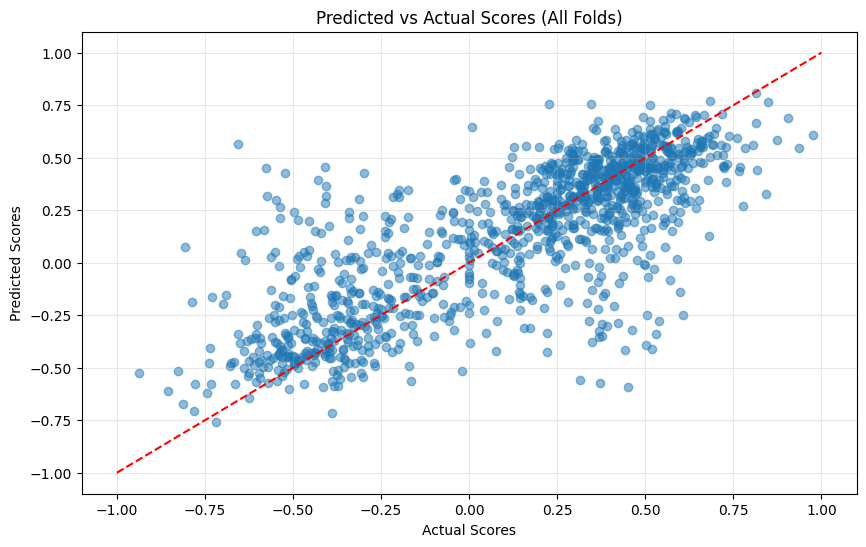

[I 2025-04-23 06:02:42,653] Trial 5 finished with value: 0.06421493148215504 and parameters: {'learning_rate': 3.8690234796295895e-05, 'batch_size': 32, 'epochs': 18}. Best is trial 2 with value: 0.06414243366137881.



Starting Fold 1/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.1059]


Epoch 1/10 - Train Loss: 0.0993, Val MSE: 0.0894, Val MAE: 0.2186


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0410]


Epoch 2/10 - Train Loss: 0.0478, Val MSE: 0.0672, Val MAE: 0.1914


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0208]


Epoch 3/10 - Train Loss: 0.0260, Val MSE: 0.0669, Val MAE: 0.1883


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0179]


Epoch 4/10 - Train Loss: 0.0170, Val MSE: 0.0653, Val MAE: 0.1825


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0103]


Epoch 5/10 - Train Loss: 0.0143, Val MSE: 0.0609, Val MAE: 0.1787


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0109]


Epoch 6/10 - Train Loss: 0.0111, Val MSE: 0.0607, Val MAE: 0.1774


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0081]


Epoch 7/10 - Train Loss: 0.0084, Val MSE: 0.0613, Val MAE: 0.1766


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0094]


Epoch 8/10 - Train Loss: 0.0076, Val MSE: 0.0589, Val MAE: 0.1751


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0041]


Epoch 9/10 - Train Loss: 0.0073, Val MSE: 0.0578, Val MAE: 0.1724


Training: 100%|██████████| 17/17 [00:01<00:00,  9.11it/s, loss=0.0053]


Epoch 10/10 - Train Loss: 0.0071, Val MSE: 0.0618, Val MAE: 0.1783
Fold 1 Results - MSE: 0.0618, MAE: 0.1783

Starting Fold 2/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0727]


Epoch 1/10 - Train Loss: 0.1100, Val MSE: 0.0792, Val MAE: 0.2043


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0222]


Epoch 2/10 - Train Loss: 0.0438, Val MSE: 0.0684, Val MAE: 0.1856


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0235]


Epoch 3/10 - Train Loss: 0.0251, Val MSE: 0.0694, Val MAE: 0.1885


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0094]


Epoch 4/10 - Train Loss: 0.0168, Val MSE: 0.0692, Val MAE: 0.1848


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0079]


Epoch 5/10 - Train Loss: 0.0110, Val MSE: 0.0650, Val MAE: 0.1828


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0115]


Epoch 6/10 - Train Loss: 0.0108, Val MSE: 0.0678, Val MAE: 0.1849


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0105]


Epoch 7/10 - Train Loss: 0.0104, Val MSE: 0.0686, Val MAE: 0.1815


Training: 100%|██████████| 17/17 [00:01<00:00,  9.11it/s, loss=0.0126]


Epoch 8/10 - Train Loss: 0.0085, Val MSE: 0.0678, Val MAE: 0.1831


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0063]


Epoch 9/10 - Train Loss: 0.0078, Val MSE: 0.0708, Val MAE: 0.1837


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0052]


Epoch 10/10 - Train Loss: 0.0065, Val MSE: 0.0677, Val MAE: 0.1787
Fold 2 Results - MSE: 0.0677, MAE: 0.1787

Starting Fold 3/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0868]


Epoch 1/10 - Train Loss: 0.1263, Val MSE: 0.0859, Val MAE: 0.2079


Training: 100%|██████████| 17/17 [00:01<00:00,  9.11it/s, loss=0.0644]


Epoch 2/10 - Train Loss: 0.0521, Val MSE: 0.0689, Val MAE: 0.1876


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0295]


Epoch 3/10 - Train Loss: 0.0249, Val MSE: 0.0677, Val MAE: 0.1782


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0417]


Epoch 4/10 - Train Loss: 0.0173, Val MSE: 0.0607, Val MAE: 0.1756


Training: 100%|██████████| 17/17 [00:01<00:00,  9.11it/s, loss=0.0103]


Epoch 5/10 - Train Loss: 0.0136, Val MSE: 0.0638, Val MAE: 0.1769


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0155]


Epoch 6/10 - Train Loss: 0.0115, Val MSE: 0.0649, Val MAE: 0.1829


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0069]


Epoch 7/10 - Train Loss: 0.0096, Val MSE: 0.0611, Val MAE: 0.1755


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0049]


Epoch 8/10 - Train Loss: 0.0095, Val MSE: 0.0605, Val MAE: 0.1772


Training: 100%|██████████| 17/17 [00:01<00:00,  9.11it/s, loss=0.0064]


Epoch 9/10 - Train Loss: 0.0077, Val MSE: 0.0594, Val MAE: 0.1762


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0044]


Epoch 10/10 - Train Loss: 0.0081, Val MSE: 0.0615, Val MAE: 0.1786
Fold 3 Results - MSE: 0.0615, MAE: 0.1786

Starting Fold 4/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0681]


Epoch 1/10 - Train Loss: 0.1160, Val MSE: 0.0692, Val MAE: 0.1981


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0279]


Epoch 2/10 - Train Loss: 0.0426, Val MSE: 0.0727, Val MAE: 0.2022


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0210]


Epoch 3/10 - Train Loss: 0.0235, Val MSE: 0.0655, Val MAE: 0.1911


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0202]


Epoch 4/10 - Train Loss: 0.0148, Val MSE: 0.0663, Val MAE: 0.1932


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0070]


Epoch 5/10 - Train Loss: 0.0115, Val MSE: 0.0717, Val MAE: 0.1933


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0061]


Epoch 6/10 - Train Loss: 0.0095, Val MSE: 0.0658, Val MAE: 0.1879


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0059]


Epoch 7/10 - Train Loss: 0.0084, Val MSE: 0.0673, Val MAE: 0.1866


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0046]


Epoch 8/10 - Train Loss: 0.0080, Val MSE: 0.0652, Val MAE: 0.1798


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0072]


Epoch 9/10 - Train Loss: 0.0079, Val MSE: 0.0686, Val MAE: 0.1904


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0103]


Epoch 10/10 - Train Loss: 0.0072, Val MSE: 0.0701, Val MAE: 0.1911
Fold 4 Results - MSE: 0.0701, MAE: 0.1911

Starting Fold 5/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0794]


Epoch 1/10 - Train Loss: 0.1186, Val MSE: 0.0679, Val MAE: 0.2051


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0547]


Epoch 2/10 - Train Loss: 0.0483, Val MSE: 0.0568, Val MAE: 0.1832


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0238]


Epoch 3/10 - Train Loss: 0.0255, Val MSE: 0.0452, Val MAE: 0.1599


Training: 100%|██████████| 17/17 [00:01<00:00,  9.02it/s, loss=0.0108]


Epoch 4/10 - Train Loss: 0.0167, Val MSE: 0.0433, Val MAE: 0.1538


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0095]


Epoch 5/10 - Train Loss: 0.0136, Val MSE: 0.0447, Val MAE: 0.1603


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0104]


Epoch 6/10 - Train Loss: 0.0105, Val MSE: 0.0459, Val MAE: 0.1637


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0112]


Epoch 7/10 - Train Loss: 0.0099, Val MSE: 0.0440, Val MAE: 0.1607


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0058]


Epoch 8/10 - Train Loss: 0.0086, Val MSE: 0.0447, Val MAE: 0.1641


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0086]


Epoch 9/10 - Train Loss: 0.0078, Val MSE: 0.0450, Val MAE: 0.1632


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0065]


Epoch 10/10 - Train Loss: 0.0074, Val MSE: 0.0430, Val MAE: 0.1583
Fold 5 Results - MSE: 0.0430, MAE: 0.1583

Starting Fold 6/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0787]


Epoch 1/10 - Train Loss: 0.1346, Val MSE: 0.0769, Val MAE: 0.2030


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0545]


Epoch 2/10 - Train Loss: 0.0533, Val MSE: 0.0703, Val MAE: 0.1915


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0179]


Epoch 3/10 - Train Loss: 0.0308, Val MSE: 0.0659, Val MAE: 0.1806


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0114]


Epoch 4/10 - Train Loss: 0.0161, Val MSE: 0.0672, Val MAE: 0.1733


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0097]


Epoch 5/10 - Train Loss: 0.0118, Val MSE: 0.0678, Val MAE: 0.1795


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0082]


Epoch 6/10 - Train Loss: 0.0092, Val MSE: 0.0673, Val MAE: 0.1774


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0060]


Epoch 7/10 - Train Loss: 0.0077, Val MSE: 0.0736, Val MAE: 0.1948


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0110]


Epoch 8/10 - Train Loss: 0.0081, Val MSE: 0.0686, Val MAE: 0.1782


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0098]


Epoch 9/10 - Train Loss: 0.0075, Val MSE: 0.0670, Val MAE: 0.1803


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0050]


Epoch 10/10 - Train Loss: 0.0064, Val MSE: 0.0699, Val MAE: 0.1844
Fold 6 Results - MSE: 0.0699, MAE: 0.1844

Starting Fold 7/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0783]


Epoch 1/10 - Train Loss: 0.1194, Val MSE: 0.0875, Val MAE: 0.2038


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0493]


Epoch 2/10 - Train Loss: 0.0501, Val MSE: 0.0943, Val MAE: 0.2148


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0451]


Epoch 3/10 - Train Loss: 0.0283, Val MSE: 0.0959, Val MAE: 0.2174


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0257]


Epoch 4/10 - Train Loss: 0.0179, Val MSE: 0.0827, Val MAE: 0.1943


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0230]


Epoch 5/10 - Train Loss: 0.0128, Val MSE: 0.0924, Val MAE: 0.2077


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0089]


Epoch 6/10 - Train Loss: 0.0118, Val MSE: 0.0938, Val MAE: 0.2122


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0100]


Epoch 7/10 - Train Loss: 0.0100, Val MSE: 0.0869, Val MAE: 0.2043


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0087]


Epoch 8/10 - Train Loss: 0.0086, Val MSE: 0.0883, Val MAE: 0.2054


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0037]


Epoch 9/10 - Train Loss: 0.0077, Val MSE: 0.0807, Val MAE: 0.1884


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0091]


Epoch 10/10 - Train Loss: 0.0069, Val MSE: 0.0863, Val MAE: 0.2032
Fold 7 Results - MSE: 0.0863, MAE: 0.2032

Starting Fold 8/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0644]


Epoch 1/10 - Train Loss: 0.1214, Val MSE: 0.0609, Val MAE: 0.1877


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0560]


Epoch 2/10 - Train Loss: 0.0571, Val MSE: 0.0684, Val MAE: 0.2062


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0184]


Epoch 3/10 - Train Loss: 0.0285, Val MSE: 0.0545, Val MAE: 0.1663


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0095]


Epoch 4/10 - Train Loss: 0.0182, Val MSE: 0.0582, Val MAE: 0.1694


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0110]


Epoch 5/10 - Train Loss: 0.0131, Val MSE: 0.0599, Val MAE: 0.1753


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0095]


Epoch 6/10 - Train Loss: 0.0108, Val MSE: 0.0703, Val MAE: 0.1866


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0081]


Epoch 7/10 - Train Loss: 0.0092, Val MSE: 0.0537, Val MAE: 0.1630


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0062]


Epoch 8/10 - Train Loss: 0.0078, Val MSE: 0.0598, Val MAE: 0.1703


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0069]


Epoch 9/10 - Train Loss: 0.0075, Val MSE: 0.0580, Val MAE: 0.1685


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0044]


Epoch 10/10 - Train Loss: 0.0067, Val MSE: 0.0528, Val MAE: 0.1604
Fold 8 Results - MSE: 0.0528, MAE: 0.1604

Starting Fold 9/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0911]


Epoch 1/10 - Train Loss: 0.1213, Val MSE: 0.0978, Val MAE: 0.2305


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0281]


Epoch 2/10 - Train Loss: 0.0478, Val MSE: 0.0762, Val MAE: 0.1929


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0343]


Epoch 3/10 - Train Loss: 0.0286, Val MSE: 0.0754, Val MAE: 0.1797


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0154]


Epoch 4/10 - Train Loss: 0.0161, Val MSE: 0.0754, Val MAE: 0.1788


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0102]


Epoch 5/10 - Train Loss: 0.0112, Val MSE: 0.0709, Val MAE: 0.1727


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0114]


Epoch 6/10 - Train Loss: 0.0089, Val MSE: 0.0739, Val MAE: 0.1758


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0129]


Epoch 7/10 - Train Loss: 0.0088, Val MSE: 0.0793, Val MAE: 0.1792


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0074]


Epoch 8/10 - Train Loss: 0.0078, Val MSE: 0.0762, Val MAE: 0.1825


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0074]


Epoch 9/10 - Train Loss: 0.0076, Val MSE: 0.0761, Val MAE: 0.1823


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0043]


Epoch 10/10 - Train Loss: 0.0062, Val MSE: 0.0748, Val MAE: 0.1755
Fold 9 Results - MSE: 0.0748, MAE: 0.1755

Starting Fold 10/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0651]


Epoch 1/10 - Train Loss: 0.1312, Val MSE: 0.0757, Val MAE: 0.1993


Training: 100%|██████████| 17/17 [00:01<00:00,  8.99it/s, loss=0.0344]


Epoch 2/10 - Train Loss: 0.0548, Val MSE: 0.0607, Val MAE: 0.1725


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0267]


Epoch 3/10 - Train Loss: 0.0292, Val MSE: 0.0609, Val MAE: 0.1764


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0169]


Epoch 4/10 - Train Loss: 0.0179, Val MSE: 0.0628, Val MAE: 0.1778


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0242]


Epoch 5/10 - Train Loss: 0.0137, Val MSE: 0.0635, Val MAE: 0.1838


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0123]


Epoch 6/10 - Train Loss: 0.0096, Val MSE: 0.0597, Val MAE: 0.1747


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0108]


Epoch 7/10 - Train Loss: 0.0091, Val MSE: 0.0619, Val MAE: 0.1752


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0084]


Epoch 8/10 - Train Loss: 0.0077, Val MSE: 0.0599, Val MAE: 0.1759


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0053]


Epoch 9/10 - Train Loss: 0.0077, Val MSE: 0.0596, Val MAE: 0.1784


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0048]


Epoch 10/10 - Train Loss: 0.0074, Val MSE: 0.0568, Val MAE: 0.1734
Fold 10 Results - MSE: 0.0568, MAE: 0.1734

Cross-Validation Results:
Average MSE: 0.0645 ± 0.0121
Average MAE: 0.1782 ± 0.0132


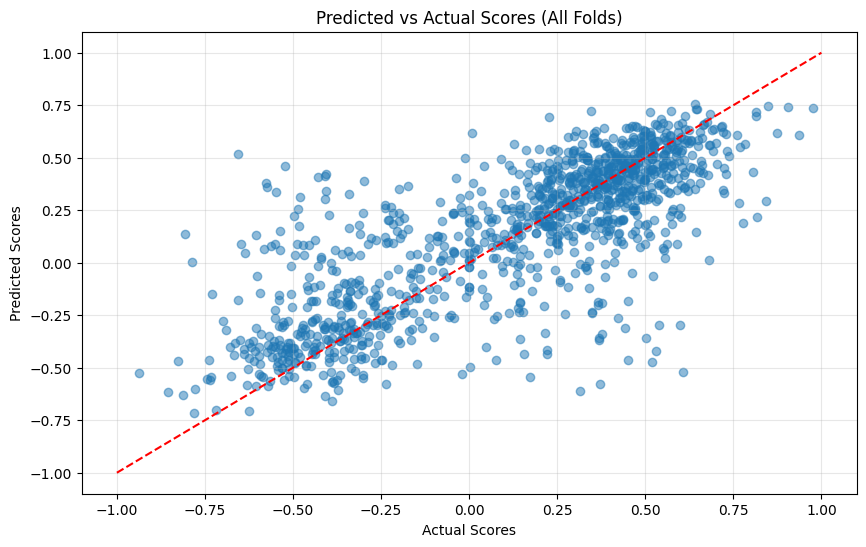

[I 2025-04-23 06:06:02,678] Trial 6 finished with value: 0.06447189499056653 and parameters: {'learning_rate': 6.010978345977156e-05, 'batch_size': 64, 'epochs': 6}. Best is trial 2 with value: 0.06414243366137881.



Starting Fold 1/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0457]


Epoch 1/10 - Train Loss: 0.1113, Val MSE: 0.0798, Val MAE: 0.2146


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0447]


Epoch 2/10 - Train Loss: 0.0593, Val MSE: 0.0665, Val MAE: 0.1930


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0349]


Epoch 3/10 - Train Loss: 0.0429, Val MSE: 0.0675, Val MAE: 0.1897


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0207]


Epoch 4/10 - Train Loss: 0.0286, Val MSE: 0.0713, Val MAE: 0.1909


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0120]


Epoch 5/10 - Train Loss: 0.0225, Val MSE: 0.0704, Val MAE: 0.1872


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0145]


Epoch 6/10 - Train Loss: 0.0187, Val MSE: 0.0723, Val MAE: 0.1899


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0144]


Epoch 7/10 - Train Loss: 0.0158, Val MSE: 0.0724, Val MAE: 0.1929


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0099]


Epoch 8/10 - Train Loss: 0.0126, Val MSE: 0.0734, Val MAE: 0.1923


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0087]


Epoch 9/10 - Train Loss: 0.0118, Val MSE: 0.0724, Val MAE: 0.1945


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0156]


Epoch 10/10 - Train Loss: 0.0122, Val MSE: 0.0702, Val MAE: 0.1880
Fold 1 Results - MSE: 0.0702, MAE: 0.1880

Starting Fold 2/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.1057]


Epoch 1/10 - Train Loss: 0.1236, Val MSE: 0.1038, Val MAE: 0.2419


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0407]


Epoch 2/10 - Train Loss: 0.0589, Val MSE: 0.0790, Val MAE: 0.2044


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0298]


Epoch 3/10 - Train Loss: 0.0431, Val MSE: 0.0763, Val MAE: 0.1905


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0178]


Epoch 4/10 - Train Loss: 0.0310, Val MSE: 0.0714, Val MAE: 0.1844


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0162]


Epoch 5/10 - Train Loss: 0.0215, Val MSE: 0.0730, Val MAE: 0.1885


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0115]


Epoch 6/10 - Train Loss: 0.0171, Val MSE: 0.0722, Val MAE: 0.1845


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0078]


Epoch 7/10 - Train Loss: 0.0142, Val MSE: 0.0736, Val MAE: 0.1860


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0139]


Epoch 8/10 - Train Loss: 0.0147, Val MSE: 0.0745, Val MAE: 0.1857


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0113]


Epoch 9/10 - Train Loss: 0.0107, Val MSE: 0.0751, Val MAE: 0.1877


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0065]


Epoch 10/10 - Train Loss: 0.0103, Val MSE: 0.0715, Val MAE: 0.1840
Fold 2 Results - MSE: 0.0715, MAE: 0.1840

Starting Fold 3/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0637]


Epoch 1/10 - Train Loss: 0.1140, Val MSE: 0.1164, Val MAE: 0.2614


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0458]


Epoch 2/10 - Train Loss: 0.0621, Val MSE: 0.0901, Val MAE: 0.2191


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0279]


Epoch 3/10 - Train Loss: 0.0396, Val MSE: 0.0908, Val MAE: 0.2177


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0249]


Epoch 4/10 - Train Loss: 0.0282, Val MSE: 0.0867, Val MAE: 0.2052


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0166]


Epoch 5/10 - Train Loss: 0.0214, Val MSE: 0.0838, Val MAE: 0.2014


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0247]


Epoch 6/10 - Train Loss: 0.0174, Val MSE: 0.0862, Val MAE: 0.2046


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0162]


Epoch 7/10 - Train Loss: 0.0146, Val MSE: 0.0831, Val MAE: 0.2026


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0050]


Epoch 8/10 - Train Loss: 0.0119, Val MSE: 0.0821, Val MAE: 0.1988


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0069]


Epoch 9/10 - Train Loss: 0.0114, Val MSE: 0.0817, Val MAE: 0.1958


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0118]


Epoch 10/10 - Train Loss: 0.0114, Val MSE: 0.0823, Val MAE: 0.1988
Fold 3 Results - MSE: 0.0823, MAE: 0.1988

Starting Fold 4/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.1362]


Epoch 1/10 - Train Loss: 0.1344, Val MSE: 0.0915, Val MAE: 0.2441


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0838]


Epoch 2/10 - Train Loss: 0.0681, Val MSE: 0.0835, Val MAE: 0.2270


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0547]


Epoch 3/10 - Train Loss: 0.0478, Val MSE: 0.0812, Val MAE: 0.2191


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0282]


Epoch 4/10 - Train Loss: 0.0344, Val MSE: 0.0828, Val MAE: 0.2187


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0229]


Epoch 5/10 - Train Loss: 0.0259, Val MSE: 0.0747, Val MAE: 0.2015


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0268]


Epoch 6/10 - Train Loss: 0.0197, Val MSE: 0.0781, Val MAE: 0.2061


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0204]


Epoch 7/10 - Train Loss: 0.0153, Val MSE: 0.0822, Val MAE: 0.2076


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0121]


Epoch 8/10 - Train Loss: 0.0139, Val MSE: 0.0788, Val MAE: 0.2043


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0122]


Epoch 9/10 - Train Loss: 0.0122, Val MSE: 0.0792, Val MAE: 0.2038


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0079]


Epoch 10/10 - Train Loss: 0.0109, Val MSE: 0.0795, Val MAE: 0.2041
Fold 4 Results - MSE: 0.0795, MAE: 0.2041

Starting Fold 5/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0962]


Epoch 1/10 - Train Loss: 0.1238, Val MSE: 0.0784, Val MAE: 0.2188


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0484]


Epoch 2/10 - Train Loss: 0.0715, Val MSE: 0.0564, Val MAE: 0.1855


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0631]


Epoch 3/10 - Train Loss: 0.0464, Val MSE: 0.0480, Val MAE: 0.1766


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0406]


Epoch 4/10 - Train Loss: 0.0320, Val MSE: 0.0471, Val MAE: 0.1719


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0190]


Epoch 5/10 - Train Loss: 0.0232, Val MSE: 0.0454, Val MAE: 0.1721


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0219]


Epoch 6/10 - Train Loss: 0.0184, Val MSE: 0.0453, Val MAE: 0.1718


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0092]


Epoch 7/10 - Train Loss: 0.0148, Val MSE: 0.0456, Val MAE: 0.1688


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0434]


Epoch 8/10 - Train Loss: 0.0140, Val MSE: 0.0438, Val MAE: 0.1644


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0101]


Epoch 9/10 - Train Loss: 0.0121, Val MSE: 0.0415, Val MAE: 0.1611


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0118]


Epoch 10/10 - Train Loss: 0.0112, Val MSE: 0.0419, Val MAE: 0.1605
Fold 5 Results - MSE: 0.0419, MAE: 0.1605

Starting Fold 6/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0748]


Epoch 1/10 - Train Loss: 0.1207, Val MSE: 0.0891, Val MAE: 0.2324


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0609]


Epoch 2/10 - Train Loss: 0.0688, Val MSE: 0.0644, Val MAE: 0.1926


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0306]


Epoch 3/10 - Train Loss: 0.0446, Val MSE: 0.0615, Val MAE: 0.1818


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0187]


Epoch 4/10 - Train Loss: 0.0305, Val MSE: 0.0646, Val MAE: 0.1841


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0157]


Epoch 5/10 - Train Loss: 0.0224, Val MSE: 0.0683, Val MAE: 0.1886


Training: 100%|██████████| 17/17 [00:01<00:00,  8.97it/s, loss=0.0168]


Epoch 6/10 - Train Loss: 0.0169, Val MSE: 0.0665, Val MAE: 0.1866


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0207]


Epoch 7/10 - Train Loss: 0.0146, Val MSE: 0.0683, Val MAE: 0.1901


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0092]


Epoch 8/10 - Train Loss: 0.0119, Val MSE: 0.0671, Val MAE: 0.1897


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0131]


Epoch 9/10 - Train Loss: 0.0119, Val MSE: 0.0680, Val MAE: 0.1898


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0127]


Epoch 10/10 - Train Loss: 0.0109, Val MSE: 0.0723, Val MAE: 0.1892
Fold 6 Results - MSE: 0.0723, MAE: 0.1892

Starting Fold 7/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0712]


Epoch 1/10 - Train Loss: 0.1271, Val MSE: 0.1179, Val MAE: 0.2452


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0879]


Epoch 2/10 - Train Loss: 0.0633, Val MSE: 0.0919, Val MAE: 0.2160


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0248]


Epoch 3/10 - Train Loss: 0.0411, Val MSE: 0.0979, Val MAE: 0.2199


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0331]


Epoch 4/10 - Train Loss: 0.0300, Val MSE: 0.0907, Val MAE: 0.2069


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0179]


Epoch 5/10 - Train Loss: 0.0234, Val MSE: 0.1016, Val MAE: 0.2214


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0266]


Epoch 6/10 - Train Loss: 0.0185, Val MSE: 0.0959, Val MAE: 0.2139


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0138]


Epoch 7/10 - Train Loss: 0.0152, Val MSE: 0.0937, Val MAE: 0.2115


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0145]


Epoch 8/10 - Train Loss: 0.0157, Val MSE: 0.0927, Val MAE: 0.2109


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0143]


Epoch 9/10 - Train Loss: 0.0137, Val MSE: 0.0941, Val MAE: 0.2110


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0096]


Epoch 10/10 - Train Loss: 0.0124, Val MSE: 0.0921, Val MAE: 0.2117
Fold 7 Results - MSE: 0.0921, MAE: 0.2117

Starting Fold 8/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.1026]


Epoch 1/10 - Train Loss: 0.1165, Val MSE: 0.0776, Val MAE: 0.2116


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0683]


Epoch 2/10 - Train Loss: 0.0628, Val MSE: 0.0656, Val MAE: 0.1956


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0414]


Epoch 3/10 - Train Loss: 0.0428, Val MSE: 0.0727, Val MAE: 0.2049


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0285]


Epoch 4/10 - Train Loss: 0.0315, Val MSE: 0.0725, Val MAE: 0.2003


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0177]


Epoch 5/10 - Train Loss: 0.0219, Val MSE: 0.0721, Val MAE: 0.1994


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0172]


Epoch 6/10 - Train Loss: 0.0186, Val MSE: 0.0698, Val MAE: 0.1952


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0221]


Epoch 7/10 - Train Loss: 0.0162, Val MSE: 0.0733, Val MAE: 0.1990


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0110]


Epoch 8/10 - Train Loss: 0.0132, Val MSE: 0.0712, Val MAE: 0.1957


Training: 100%|██████████| 17/17 [00:01<00:00,  9.02it/s, loss=0.0098]


Epoch 9/10 - Train Loss: 0.0117, Val MSE: 0.0709, Val MAE: 0.1924


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0094]


Epoch 10/10 - Train Loss: 0.0112, Val MSE: 0.0766, Val MAE: 0.2032
Fold 8 Results - MSE: 0.0766, MAE: 0.2032

Starting Fold 9/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.1022]


Epoch 1/10 - Train Loss: 0.1319, Val MSE: 0.1036, Val MAE: 0.2480


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0458]


Epoch 2/10 - Train Loss: 0.0672, Val MSE: 0.0816, Val MAE: 0.1995


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0279]


Epoch 3/10 - Train Loss: 0.0434, Val MSE: 0.0813, Val MAE: 0.1967


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0435]


Epoch 4/10 - Train Loss: 0.0319, Val MSE: 0.0803, Val MAE: 0.1961


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0170]


Epoch 5/10 - Train Loss: 0.0221, Val MSE: 0.0794, Val MAE: 0.1911


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0170]


Epoch 6/10 - Train Loss: 0.0179, Val MSE: 0.0763, Val MAE: 0.1888


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0071]


Epoch 7/10 - Train Loss: 0.0146, Val MSE: 0.0857, Val MAE: 0.1983


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0082]


Epoch 8/10 - Train Loss: 0.0123, Val MSE: 0.0789, Val MAE: 0.1888


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0107]


Epoch 9/10 - Train Loss: 0.0117, Val MSE: 0.0790, Val MAE: 0.1873


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0081]


Epoch 10/10 - Train Loss: 0.0100, Val MSE: 0.0783, Val MAE: 0.1875
Fold 9 Results - MSE: 0.0783, MAE: 0.1875

Starting Fold 10/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0648]


Epoch 1/10 - Train Loss: 0.1178, Val MSE: 0.0994, Val MAE: 0.2411


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0703]


Epoch 2/10 - Train Loss: 0.0685, Val MSE: 0.0822, Val MAE: 0.2210


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0461]


Epoch 3/10 - Train Loss: 0.0448, Val MSE: 0.0761, Val MAE: 0.1983


Training: 100%|██████████| 17/17 [00:01<00:00,  9.11it/s, loss=0.0273]


Epoch 4/10 - Train Loss: 0.0295, Val MSE: 0.0689, Val MAE: 0.1841


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0251]


Epoch 5/10 - Train Loss: 0.0241, Val MSE: 0.0669, Val MAE: 0.1894


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0158]


Epoch 6/10 - Train Loss: 0.0185, Val MSE: 0.0661, Val MAE: 0.1785


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0146]


Epoch 7/10 - Train Loss: 0.0150, Val MSE: 0.0654, Val MAE: 0.1756


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0107]


Epoch 8/10 - Train Loss: 0.0134, Val MSE: 0.0650, Val MAE: 0.1782


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0084]


Epoch 9/10 - Train Loss: 0.0119, Val MSE: 0.0642, Val MAE: 0.1817


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0125]


Epoch 10/10 - Train Loss: 0.0112, Val MSE: 0.0612, Val MAE: 0.1761
Fold 10 Results - MSE: 0.0612, MAE: 0.1761

Cross-Validation Results:
Average MSE: 0.0726 ± 0.0135
Average MAE: 0.1903 ± 0.0150


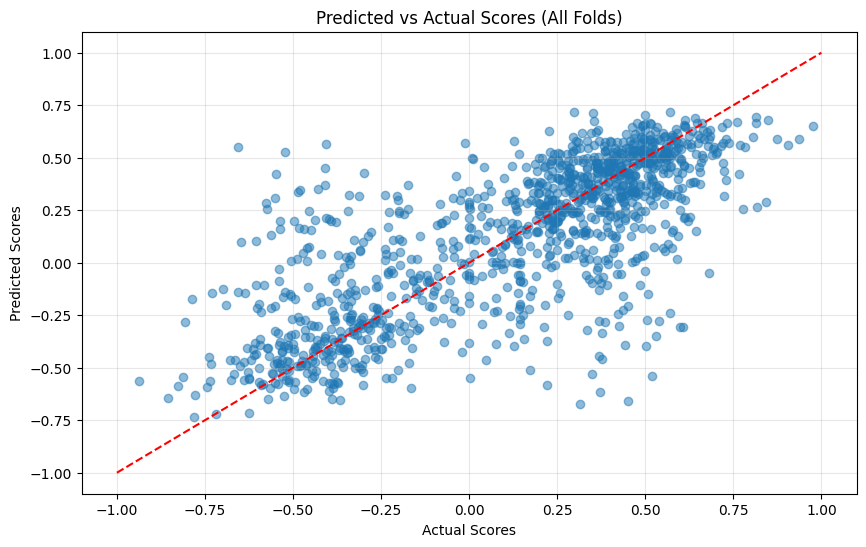

[I 2025-04-23 06:09:22,882] Trial 7 finished with value: 0.07259358424978928 and parameters: {'learning_rate': 1.7559736205683587e-05, 'batch_size': 64, 'epochs': 8}. Best is trial 2 with value: 0.06414243366137881.



Starting Fold 1/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.1010]


Epoch 1/10 - Train Loss: 0.1343, Val MSE: 0.0719, Val MAE: 0.2016


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0615]


Epoch 2/10 - Train Loss: 0.0500, Val MSE: 0.0759, Val MAE: 0.1925


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0162]


Epoch 3/10 - Train Loss: 0.0265, Val MSE: 0.0735, Val MAE: 0.1912


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0249]


Epoch 4/10 - Train Loss: 0.0157, Val MSE: 0.0723, Val MAE: 0.1967


Training: 100%|██████████| 33/33 [00:02<00:00, 11.99it/s, loss=0.0140]


Epoch 5/10 - Train Loss: 0.0136, Val MSE: 0.0699, Val MAE: 0.1936


Training: 100%|██████████| 33/33 [00:02<00:00, 11.97it/s, loss=0.0075]


Epoch 6/10 - Train Loss: 0.0108, Val MSE: 0.0652, Val MAE: 0.1888


Training: 100%|██████████| 33/33 [00:02<00:00, 11.98it/s, loss=0.0196]


Epoch 7/10 - Train Loss: 0.0100, Val MSE: 0.0648, Val MAE: 0.1829


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0092]


Epoch 8/10 - Train Loss: 0.0093, Val MSE: 0.0705, Val MAE: 0.1943


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0055]


Epoch 9/10 - Train Loss: 0.0083, Val MSE: 0.0627, Val MAE: 0.1851


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0070]


Epoch 10/10 - Train Loss: 0.0073, Val MSE: 0.0606, Val MAE: 0.1829
Fold 1 Results - MSE: 0.0606, MAE: 0.1829

Starting Fold 2/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0738]


Epoch 1/10 - Train Loss: 0.1046, Val MSE: 0.0690, Val MAE: 0.1863


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0509]


Epoch 2/10 - Train Loss: 0.0440, Val MSE: 0.0728, Val MAE: 0.1913


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0245]


Epoch 3/10 - Train Loss: 0.0230, Val MSE: 0.0795, Val MAE: 0.1905


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0081]


Epoch 4/10 - Train Loss: 0.0151, Val MSE: 0.0699, Val MAE: 0.1854


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0187]


Epoch 5/10 - Train Loss: 0.0111, Val MSE: 0.0690, Val MAE: 0.1842


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0084]


Epoch 6/10 - Train Loss: 0.0102, Val MSE: 0.0693, Val MAE: 0.1841


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0099]


Epoch 7/10 - Train Loss: 0.0096, Val MSE: 0.0808, Val MAE: 0.2025


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0085]


Epoch 8/10 - Train Loss: 0.0088, Val MSE: 0.0728, Val MAE: 0.1845


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0068]


Epoch 9/10 - Train Loss: 0.0089, Val MSE: 0.0703, Val MAE: 0.1872


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0135]


Epoch 10/10 - Train Loss: 0.0075, Val MSE: 0.0733, Val MAE: 0.1908
Fold 2 Results - MSE: 0.0733, MAE: 0.1908

Starting Fold 3/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0736]


Epoch 1/10 - Train Loss: 0.1121, Val MSE: 0.0885, Val MAE: 0.2246


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0392]


Epoch 2/10 - Train Loss: 0.0468, Val MSE: 0.0763, Val MAE: 0.1986


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0228]


Epoch 3/10 - Train Loss: 0.0237, Val MSE: 0.0751, Val MAE: 0.1884


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0196]


Epoch 4/10 - Train Loss: 0.0166, Val MSE: 0.0711, Val MAE: 0.1907


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0238]


Epoch 5/10 - Train Loss: 0.0131, Val MSE: 0.0656, Val MAE: 0.1824


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0091]


Epoch 6/10 - Train Loss: 0.0118, Val MSE: 0.0696, Val MAE: 0.1837


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0105]


Epoch 7/10 - Train Loss: 0.0097, Val MSE: 0.0651, Val MAE: 0.1783


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0070]


Epoch 8/10 - Train Loss: 0.0092, Val MSE: 0.0656, Val MAE: 0.1802


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0058]


Epoch 9/10 - Train Loss: 0.0085, Val MSE: 0.0650, Val MAE: 0.1742


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0217]


Epoch 10/10 - Train Loss: 0.0079, Val MSE: 0.0617, Val MAE: 0.1733
Fold 3 Results - MSE: 0.0617, MAE: 0.1733

Starting Fold 4/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0892]


Epoch 1/10 - Train Loss: 0.0973, Val MSE: 0.0670, Val MAE: 0.1942


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0605]


Epoch 2/10 - Train Loss: 0.0404, Val MSE: 0.0652, Val MAE: 0.1923


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0128]


Epoch 3/10 - Train Loss: 0.0226, Val MSE: 0.0616, Val MAE: 0.1753


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0119]


Epoch 4/10 - Train Loss: 0.0148, Val MSE: 0.0664, Val MAE: 0.1827


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0133]


Epoch 5/10 - Train Loss: 0.0122, Val MSE: 0.0664, Val MAE: 0.1828


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0107]


Epoch 6/10 - Train Loss: 0.0108, Val MSE: 0.0661, Val MAE: 0.1841


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0061]


Epoch 7/10 - Train Loss: 0.0100, Val MSE: 0.0647, Val MAE: 0.1821


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0087]


Epoch 8/10 - Train Loss: 0.0083, Val MSE: 0.0639, Val MAE: 0.1805


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0066]


Epoch 9/10 - Train Loss: 0.0082, Val MSE: 0.0659, Val MAE: 0.1855


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0043]


Epoch 10/10 - Train Loss: 0.0070, Val MSE: 0.0665, Val MAE: 0.1795
Fold 4 Results - MSE: 0.0665, MAE: 0.1795

Starting Fold 5/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.1010]


Epoch 1/10 - Train Loss: 0.1043, Val MSE: 0.0493, Val MAE: 0.1710


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0339]


Epoch 2/10 - Train Loss: 0.0455, Val MSE: 0.0416, Val MAE: 0.1606


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0125]


Epoch 3/10 - Train Loss: 0.0221, Val MSE: 0.0512, Val MAE: 0.1752


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0131]


Epoch 4/10 - Train Loss: 0.0152, Val MSE: 0.0444, Val MAE: 0.1624


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0089]


Epoch 5/10 - Train Loss: 0.0129, Val MSE: 0.0445, Val MAE: 0.1604


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0102]


Epoch 6/10 - Train Loss: 0.0118, Val MSE: 0.0456, Val MAE: 0.1616


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0136]


Epoch 7/10 - Train Loss: 0.0105, Val MSE: 0.0456, Val MAE: 0.1642


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0133]


Epoch 8/10 - Train Loss: 0.0085, Val MSE: 0.0419, Val MAE: 0.1564


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0150]


Epoch 9/10 - Train Loss: 0.0084, Val MSE: 0.0445, Val MAE: 0.1595


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0078]


Epoch 10/10 - Train Loss: 0.0080, Val MSE: 0.0452, Val MAE: 0.1638
Fold 5 Results - MSE: 0.0452, MAE: 0.1638

Starting Fold 6/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.1596]


Epoch 1/10 - Train Loss: 0.1051, Val MSE: 0.0792, Val MAE: 0.2115


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0313]


Epoch 2/10 - Train Loss: 0.0438, Val MSE: 0.0665, Val MAE: 0.1833


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0308]


Epoch 3/10 - Train Loss: 0.0257, Val MSE: 0.0622, Val MAE: 0.1734


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0151]


Epoch 4/10 - Train Loss: 0.0178, Val MSE: 0.0619, Val MAE: 0.1761


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0112]


Epoch 5/10 - Train Loss: 0.0132, Val MSE: 0.0633, Val MAE: 0.1757


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0078]


Epoch 6/10 - Train Loss: 0.0097, Val MSE: 0.0644, Val MAE: 0.1756


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0055]


Epoch 7/10 - Train Loss: 0.0097, Val MSE: 0.0596, Val MAE: 0.1681


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0061]


Epoch 8/10 - Train Loss: 0.0085, Val MSE: 0.0664, Val MAE: 0.1780


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0082]


Epoch 9/10 - Train Loss: 0.0075, Val MSE: 0.0586, Val MAE: 0.1732


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0064]


Epoch 10/10 - Train Loss: 0.0068, Val MSE: 0.0625, Val MAE: 0.1720
Fold 6 Results - MSE: 0.0625, MAE: 0.1720

Starting Fold 7/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0499]


Epoch 1/10 - Train Loss: 0.1100, Val MSE: 0.1022, Val MAE: 0.2277


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0212]


Epoch 2/10 - Train Loss: 0.0481, Val MSE: 0.0933, Val MAE: 0.2185


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0153]


Epoch 3/10 - Train Loss: 0.0245, Val MSE: 0.0821, Val MAE: 0.1953


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0170]


Epoch 4/10 - Train Loss: 0.0165, Val MSE: 0.0832, Val MAE: 0.1992


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0129]


Epoch 5/10 - Train Loss: 0.0130, Val MSE: 0.0926, Val MAE: 0.2135


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0100]


Epoch 6/10 - Train Loss: 0.0119, Val MSE: 0.0869, Val MAE: 0.2057


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0099]


Epoch 7/10 - Train Loss: 0.0095, Val MSE: 0.0766, Val MAE: 0.1912


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0058]


Epoch 8/10 - Train Loss: 0.0093, Val MSE: 0.0834, Val MAE: 0.1989


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0095]


Epoch 9/10 - Train Loss: 0.0076, Val MSE: 0.0883, Val MAE: 0.2078


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0078]


Epoch 10/10 - Train Loss: 0.0086, Val MSE: 0.0824, Val MAE: 0.1986
Fold 7 Results - MSE: 0.0824, MAE: 0.1986

Starting Fold 8/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s, loss=0.0773]


Epoch 1/10 - Train Loss: 0.1083, Val MSE: 0.0592, Val MAE: 0.1853


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0698]


Epoch 2/10 - Train Loss: 0.0454, Val MSE: 0.0671, Val MAE: 0.1798


Training: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s, loss=0.0321]


Epoch 3/10 - Train Loss: 0.0252, Val MSE: 0.0608, Val MAE: 0.1833


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0166]


Epoch 4/10 - Train Loss: 0.0211, Val MSE: 0.0653, Val MAE: 0.1789


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0089]


Epoch 5/10 - Train Loss: 0.0131, Val MSE: 0.0578, Val MAE: 0.1753


Training: 100%|██████████| 33/33 [00:02<00:00, 11.91it/s, loss=0.0087]


Epoch 6/10 - Train Loss: 0.0102, Val MSE: 0.0618, Val MAE: 0.1785


Training: 100%|██████████| 33/33 [00:02<00:00, 11.92it/s, loss=0.0088]


Epoch 7/10 - Train Loss: 0.0089, Val MSE: 0.0614, Val MAE: 0.1782


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0050]


Epoch 8/10 - Train Loss: 0.0085, Val MSE: 0.0550, Val MAE: 0.1735


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0096]


Epoch 9/10 - Train Loss: 0.0075, Val MSE: 0.0589, Val MAE: 0.1722


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0047]


Epoch 10/10 - Train Loss: 0.0071, Val MSE: 0.0569, Val MAE: 0.1733
Fold 8 Results - MSE: 0.0569, MAE: 0.1733

Starting Fold 9/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0948]


Epoch 1/10 - Train Loss: 0.1057, Val MSE: 0.0920, Val MAE: 0.2231


Training: 100%|██████████| 33/33 [00:02<00:00, 11.93it/s, loss=0.0447]


Epoch 2/10 - Train Loss: 0.0447, Val MSE: 0.0835, Val MAE: 0.2000


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0411]


Epoch 3/10 - Train Loss: 0.0234, Val MSE: 0.0810, Val MAE: 0.1951


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0131]


Epoch 4/10 - Train Loss: 0.0148, Val MSE: 0.0772, Val MAE: 0.1819


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0135]


Epoch 5/10 - Train Loss: 0.0131, Val MSE: 0.0855, Val MAE: 0.1963


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0050]


Epoch 6/10 - Train Loss: 0.0101, Val MSE: 0.0769, Val MAE: 0.1807


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0072]


Epoch 7/10 - Train Loss: 0.0087, Val MSE: 0.0766, Val MAE: 0.1808


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0076]


Epoch 8/10 - Train Loss: 0.0081, Val MSE: 0.0793, Val MAE: 0.1826


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0138]


Epoch 9/10 - Train Loss: 0.0080, Val MSE: 0.0730, Val MAE: 0.1795


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0099]


Epoch 10/10 - Train Loss: 0.0073, Val MSE: 0.0786, Val MAE: 0.1803
Fold 9 Results - MSE: 0.0786, MAE: 0.1803

Starting Fold 10/10


Training: 100%|██████████| 33/33 [00:02<00:00, 11.65it/s, loss=0.1191]


Epoch 1/10 - Train Loss: 0.0994, Val MSE: 0.0939, Val MAE: 0.2396


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0292]


Epoch 2/10 - Train Loss: 0.0445, Val MSE: 0.0583, Val MAE: 0.1757


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0173]


Epoch 3/10 - Train Loss: 0.0217, Val MSE: 0.0612, Val MAE: 0.1797


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0201]


Epoch 4/10 - Train Loss: 0.0152, Val MSE: 0.0685, Val MAE: 0.1870


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0081]


Epoch 5/10 - Train Loss: 0.0132, Val MSE: 0.0641, Val MAE: 0.1939


Training: 100%|██████████| 33/33 [00:02<00:00, 11.96it/s, loss=0.0072]


Epoch 6/10 - Train Loss: 0.0111, Val MSE: 0.0627, Val MAE: 0.1809


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0093]


Epoch 7/10 - Train Loss: 0.0102, Val MSE: 0.0598, Val MAE: 0.1750


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0040]


Epoch 8/10 - Train Loss: 0.0095, Val MSE: 0.0597, Val MAE: 0.1775


Training: 100%|██████████| 33/33 [00:02<00:00, 11.94it/s, loss=0.0048]


Epoch 9/10 - Train Loss: 0.0075, Val MSE: 0.0571, Val MAE: 0.1740


Training: 100%|██████████| 33/33 [00:02<00:00, 11.95it/s, loss=0.0088]


Epoch 10/10 - Train Loss: 0.0073, Val MSE: 0.0531, Val MAE: 0.1665
Fold 10 Results - MSE: 0.0531, MAE: 0.1665

Cross-Validation Results:
Average MSE: 0.0641 ± 0.0115
Average MAE: 0.1781 ± 0.0107


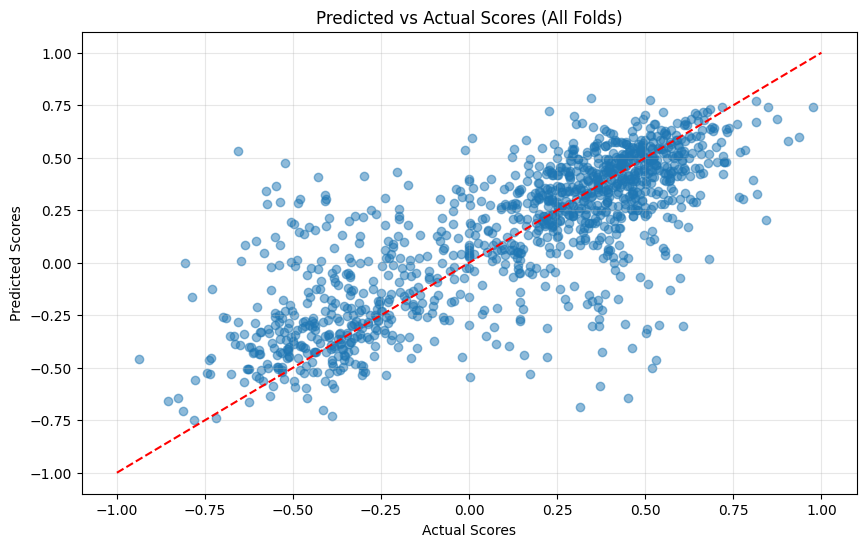

[I 2025-04-23 06:14:16,051] Trial 8 finished with value: 0.06407037475007263 and parameters: {'learning_rate': 3.9793313078986906e-05, 'batch_size': 32, 'epochs': 20}. Best is trial 8 with value: 0.06407037475007263.



Starting Fold 1/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.1039]


Epoch 1/10 - Train Loss: 0.1745, Val MSE: 0.0813, Val MAE: 0.2221


Training: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s, loss=0.0237]


Epoch 2/10 - Train Loss: 0.0593, Val MSE: 0.0743, Val MAE: 0.1997


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0175]


Epoch 3/10 - Train Loss: 0.0289, Val MSE: 0.0680, Val MAE: 0.1925


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0090]


Epoch 4/10 - Train Loss: 0.0174, Val MSE: 0.0626, Val MAE: 0.1834


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0106]


Epoch 5/10 - Train Loss: 0.0128, Val MSE: 0.0678, Val MAE: 0.1883


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0081]


Epoch 6/10 - Train Loss: 0.0098, Val MSE: 0.0617, Val MAE: 0.1767


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0077]


Epoch 7/10 - Train Loss: 0.0093, Val MSE: 0.0674, Val MAE: 0.1871


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0060]


Epoch 8/10 - Train Loss: 0.0089, Val MSE: 0.0571, Val MAE: 0.1763


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0059]


Epoch 9/10 - Train Loss: 0.0079, Val MSE: 0.0587, Val MAE: 0.1782


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0036]


Epoch 10/10 - Train Loss: 0.0076, Val MSE: 0.0606, Val MAE: 0.1763
Fold 1 Results - MSE: 0.0606, MAE: 0.1763

Starting Fold 2/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0903]


Epoch 1/10 - Train Loss: 0.1479, Val MSE: 0.0887, Val MAE: 0.2220


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0468]


Epoch 2/10 - Train Loss: 0.0503, Val MSE: 0.0859, Val MAE: 0.2115


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0276]


Epoch 3/10 - Train Loss: 0.0268, Val MSE: 0.0724, Val MAE: 0.1867


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0191]


Epoch 4/10 - Train Loss: 0.0161, Val MSE: 0.0714, Val MAE: 0.1875


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0098]


Epoch 5/10 - Train Loss: 0.0114, Val MSE: 0.0695, Val MAE: 0.1863


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0138]


Epoch 6/10 - Train Loss: 0.0099, Val MSE: 0.0712, Val MAE: 0.1894


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0058]


Epoch 7/10 - Train Loss: 0.0079, Val MSE: 0.0747, Val MAE: 0.1938


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0082]


Epoch 8/10 - Train Loss: 0.0072, Val MSE: 0.0669, Val MAE: 0.1825


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0064]


Epoch 9/10 - Train Loss: 0.0069, Val MSE: 0.0732, Val MAE: 0.1942


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0066]


Epoch 10/10 - Train Loss: 0.0074, Val MSE: 0.0691, Val MAE: 0.1850
Fold 2 Results - MSE: 0.0691, MAE: 0.1850

Starting Fold 3/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.1033]


Epoch 1/10 - Train Loss: 0.1275, Val MSE: 0.0709, Val MAE: 0.2082


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0703]


Epoch 2/10 - Train Loss: 0.0529, Val MSE: 0.0724, Val MAE: 0.1976


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0198]


Epoch 3/10 - Train Loss: 0.0266, Val MSE: 0.0658, Val MAE: 0.1787


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0229]


Epoch 4/10 - Train Loss: 0.0163, Val MSE: 0.0616, Val MAE: 0.1742


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0123]


Epoch 5/10 - Train Loss: 0.0128, Val MSE: 0.0630, Val MAE: 0.1792


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0089]


Epoch 6/10 - Train Loss: 0.0109, Val MSE: 0.0622, Val MAE: 0.1806


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0084]


Epoch 7/10 - Train Loss: 0.0092, Val MSE: 0.0602, Val MAE: 0.1746


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0083]


Epoch 8/10 - Train Loss: 0.0085, Val MSE: 0.0588, Val MAE: 0.1707


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0031]


Epoch 9/10 - Train Loss: 0.0077, Val MSE: 0.0576, Val MAE: 0.1689


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0058]


Epoch 10/10 - Train Loss: 0.0073, Val MSE: 0.0600, Val MAE: 0.1763
Fold 3 Results - MSE: 0.0600, MAE: 0.1763

Starting Fold 4/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0785]


Epoch 1/10 - Train Loss: 0.1459, Val MSE: 0.0759, Val MAE: 0.2092


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0606]


Epoch 2/10 - Train Loss: 0.0581, Val MSE: 0.0740, Val MAE: 0.2034


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0161]


Epoch 3/10 - Train Loss: 0.0300, Val MSE: 0.0695, Val MAE: 0.1910


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0167]


Epoch 4/10 - Train Loss: 0.0183, Val MSE: 0.0796, Val MAE: 0.2072


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0200]


Epoch 5/10 - Train Loss: 0.0139, Val MSE: 0.0755, Val MAE: 0.1978


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0085]


Epoch 6/10 - Train Loss: 0.0108, Val MSE: 0.0806, Val MAE: 0.2003


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0033]


Epoch 7/10 - Train Loss: 0.0083, Val MSE: 0.0754, Val MAE: 0.1925


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0061]


Epoch 8/10 - Train Loss: 0.0071, Val MSE: 0.0789, Val MAE: 0.1974


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0110]


Epoch 9/10 - Train Loss: 0.0074, Val MSE: 0.0758, Val MAE: 0.1921


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0242]


Epoch 10/10 - Train Loss: 0.0078, Val MSE: 0.0788, Val MAE: 0.1985
Fold 4 Results - MSE: 0.0788, MAE: 0.1985

Starting Fold 5/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.1008]


Epoch 1/10 - Train Loss: 0.1356, Val MSE: 0.0654, Val MAE: 0.1963


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0527]


Epoch 2/10 - Train Loss: 0.0540, Val MSE: 0.0503, Val MAE: 0.1729


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0298]


Epoch 3/10 - Train Loss: 0.0283, Val MSE: 0.0398, Val MAE: 0.1541


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0106]


Epoch 4/10 - Train Loss: 0.0168, Val MSE: 0.0404, Val MAE: 0.1594


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0111]


Epoch 5/10 - Train Loss: 0.0120, Val MSE: 0.0404, Val MAE: 0.1591


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0081]


Epoch 6/10 - Train Loss: 0.0107, Val MSE: 0.0369, Val MAE: 0.1522


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0076]


Epoch 7/10 - Train Loss: 0.0092, Val MSE: 0.0434, Val MAE: 0.1600


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0055]


Epoch 8/10 - Train Loss: 0.0086, Val MSE: 0.0398, Val MAE: 0.1519


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0076]


Epoch 9/10 - Train Loss: 0.0081, Val MSE: 0.0403, Val MAE: 0.1540


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0042]


Epoch 10/10 - Train Loss: 0.0074, Val MSE: 0.0376, Val MAE: 0.1505
Fold 5 Results - MSE: 0.0376, MAE: 0.1505

Starting Fold 6/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0743]


Epoch 1/10 - Train Loss: 0.1049, Val MSE: 0.0714, Val MAE: 0.1904


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0320]


Epoch 2/10 - Train Loss: 0.0420, Val MSE: 0.0644, Val MAE: 0.1844


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0275]


Epoch 3/10 - Train Loss: 0.0223, Val MSE: 0.0814, Val MAE: 0.2068


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0260]


Epoch 4/10 - Train Loss: 0.0151, Val MSE: 0.0595, Val MAE: 0.1755


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0253]


Epoch 5/10 - Train Loss: 0.0125, Val MSE: 0.0716, Val MAE: 0.1983


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0143]


Epoch 6/10 - Train Loss: 0.0119, Val MSE: 0.0593, Val MAE: 0.1791


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0148]


Epoch 7/10 - Train Loss: 0.0104, Val MSE: 0.0616, Val MAE: 0.1796


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0048]


Epoch 8/10 - Train Loss: 0.0091, Val MSE: 0.0613, Val MAE: 0.1737


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0101]


Epoch 9/10 - Train Loss: 0.0079, Val MSE: 0.0646, Val MAE: 0.1791


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0155]


Epoch 10/10 - Train Loss: 0.0079, Val MSE: 0.0595, Val MAE: 0.1750
Fold 6 Results - MSE: 0.0595, MAE: 0.1750

Starting Fold 7/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.1411]


Epoch 1/10 - Train Loss: 0.1070, Val MSE: 0.0852, Val MAE: 0.2098


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0472]


Epoch 2/10 - Train Loss: 0.0457, Val MSE: 0.0918, Val MAE: 0.2163


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0122]


Epoch 3/10 - Train Loss: 0.0244, Val MSE: 0.0915, Val MAE: 0.2075


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0103]


Epoch 4/10 - Train Loss: 0.0151, Val MSE: 0.0864, Val MAE: 0.1963


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0066]


Epoch 5/10 - Train Loss: 0.0112, Val MSE: 0.0887, Val MAE: 0.2005


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0070]


Epoch 6/10 - Train Loss: 0.0103, Val MSE: 0.0871, Val MAE: 0.1993


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0054]


Epoch 7/10 - Train Loss: 0.0083, Val MSE: 0.0809, Val MAE: 0.1875


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0051]


Epoch 8/10 - Train Loss: 0.0075, Val MSE: 0.0793, Val MAE: 0.1868


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0056]


Epoch 9/10 - Train Loss: 0.0085, Val MSE: 0.0845, Val MAE: 0.1924


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0110]


Epoch 10/10 - Train Loss: 0.0077, Val MSE: 0.0815, Val MAE: 0.1914
Fold 7 Results - MSE: 0.0815, MAE: 0.1914

Starting Fold 8/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0604]


Epoch 1/10 - Train Loss: 0.1194, Val MSE: 0.0652, Val MAE: 0.1769


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0417]


Epoch 2/10 - Train Loss: 0.0519, Val MSE: 0.0562, Val MAE: 0.1612


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0469]


Epoch 3/10 - Train Loss: 0.0277, Val MSE: 0.0567, Val MAE: 0.1624


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0165]


Epoch 4/10 - Train Loss: 0.0169, Val MSE: 0.0560, Val MAE: 0.1640


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0161]


Epoch 5/10 - Train Loss: 0.0130, Val MSE: 0.0579, Val MAE: 0.1687


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0103]


Epoch 6/10 - Train Loss: 0.0114, Val MSE: 0.0527, Val MAE: 0.1529


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0078]


Epoch 7/10 - Train Loss: 0.0097, Val MSE: 0.0581, Val MAE: 0.1638


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0285]


Epoch 8/10 - Train Loss: 0.0088, Val MSE: 0.0584, Val MAE: 0.1697


Training: 100%|██████████| 17/17 [00:01<00:00,  9.02it/s, loss=0.0054]


Epoch 9/10 - Train Loss: 0.0081, Val MSE: 0.0557, Val MAE: 0.1639


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0119]


Epoch 10/10 - Train Loss: 0.0077, Val MSE: 0.0547, Val MAE: 0.1555
Fold 8 Results - MSE: 0.0547, MAE: 0.1555

Starting Fold 9/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.1868]


Epoch 1/10 - Train Loss: 0.1435, Val MSE: 0.0991, Val MAE: 0.2356


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0414]


Epoch 2/10 - Train Loss: 0.0522, Val MSE: 0.0888, Val MAE: 0.2148


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0158]


Epoch 3/10 - Train Loss: 0.0288, Val MSE: 0.0755, Val MAE: 0.1929


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0171]


Epoch 4/10 - Train Loss: 0.0163, Val MSE: 0.0762, Val MAE: 0.1894


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0365]


Epoch 5/10 - Train Loss: 0.0122, Val MSE: 0.0778, Val MAE: 0.1961


Training: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s, loss=0.0208]


Epoch 6/10 - Train Loss: 0.0112, Val MSE: 0.0813, Val MAE: 0.1964


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0081]


Epoch 7/10 - Train Loss: 0.0093, Val MSE: 0.0811, Val MAE: 0.2010


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.0091]


Epoch 8/10 - Train Loss: 0.0089, Val MSE: 0.0759, Val MAE: 0.1905


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0053]


Epoch 9/10 - Train Loss: 0.0070, Val MSE: 0.0742, Val MAE: 0.1869


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0070]


Epoch 10/10 - Train Loss: 0.0068, Val MSE: 0.0733, Val MAE: 0.1860
Fold 9 Results - MSE: 0.0733, MAE: 0.1860

Starting Fold 10/10


Training: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s, loss=0.1088]


Epoch 1/10 - Train Loss: 0.1313, Val MSE: 0.0889, Val MAE: 0.2225


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0422]


Epoch 2/10 - Train Loss: 0.0568, Val MSE: 0.0705, Val MAE: 0.1921


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0343]


Epoch 3/10 - Train Loss: 0.0293, Val MSE: 0.0598, Val MAE: 0.1770


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0141]


Epoch 4/10 - Train Loss: 0.0188, Val MSE: 0.0661, Val MAE: 0.1842


Training: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s, loss=0.0105]


Epoch 5/10 - Train Loss: 0.0120, Val MSE: 0.0600, Val MAE: 0.1756


Training: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s, loss=0.0117]


Epoch 6/10 - Train Loss: 0.0107, Val MSE: 0.0578, Val MAE: 0.1796


Training: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s, loss=0.0097]


Epoch 7/10 - Train Loss: 0.0083, Val MSE: 0.0598, Val MAE: 0.1796


Training: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s, loss=0.0064]


Epoch 8/10 - Train Loss: 0.0086, Val MSE: 0.0596, Val MAE: 0.1794


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0044]


Epoch 9/10 - Train Loss: 0.0077, Val MSE: 0.0579, Val MAE: 0.1792


Training: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s, loss=0.0084]


Epoch 10/10 - Train Loss: 0.0080, Val MSE: 0.0576, Val MAE: 0.1805
Fold 10 Results - MSE: 0.0576, MAE: 0.1805

Cross-Validation Results:
Average MSE: 0.0633 ± 0.0129
Average MAE: 0.1775 ± 0.0149


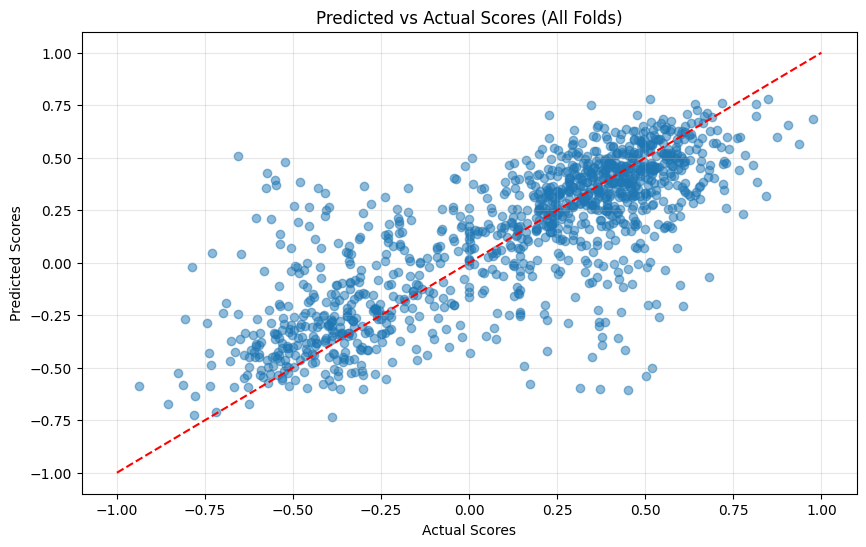

[I 2025-04-23 06:17:36,396] Trial 9 finished with value: 0.06328469902074586 and parameters: {'learning_rate': 6.0702439706973085e-05, 'batch_size': 64, 'epochs': 27}. Best is trial 9 with value: 0.06328469902074586.


🏆 Best trial:
Params: {'learning_rate': 6.0702439706973085e-05, 'batch_size': 64, 'epochs': 27}
Best MSE: 0.06328469902074586


In [42]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("🏆 Best trial:")
print("Params:", study.best_trial.params)
print("Best MSE:", study.best_trial.value)
with open("output.txt", "w") as f:
    f.write(f"Params: {study.best_trial.params}\n")
    f.write(f"Best MSE: {study.best_trial.value}\n")

### Training the different model architectures

*   FinBERTRegressor 2 layers with a tanh activation function and no dropout.
*   FINBERTRegressorB is a deeper NN with drouput.

Later, we also experiment with less number of folds as we use k-fold cross validation in the training process.

In [28]:
# Run cross-validation (assuming combined_df is your dataframe)
results, predictions, actuals = run_k_fold_cross_validation(combined_df, k=NUM_FOLDS)

TypeError: run_k_fold_cross_validation() missing 1 required positional argument: 'df'


Starting Fold 1/10


Training: 100%|██████████| 66/66 [00:13<00:00,  4.85it/s, loss=0.0350]


Epoch 1/10 - Train Loss: 0.0971, Val MSE: 0.0637, Val MAE: 0.1868


Training: 100%|██████████| 66/66 [00:13<00:00,  4.79it/s, loss=0.0584]


Epoch 2/10 - Train Loss: 0.0501, Val MSE: 0.0715, Val MAE: 0.1913


Training: 100%|██████████| 66/66 [00:14<00:00,  4.71it/s, loss=0.0428]


Epoch 3/10 - Train Loss: 0.0283, Val MSE: 0.0622, Val MAE: 0.1778


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0145]


Epoch 4/10 - Train Loss: 0.0201, Val MSE: 0.0602, Val MAE: 0.1707


Training: 100%|██████████| 66/66 [00:14<00:00,  4.54it/s, loss=0.0153]


Epoch 5/10 - Train Loss: 0.0160, Val MSE: 0.0574, Val MAE: 0.1648


Training: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.0045]


Epoch 6/10 - Train Loss: 0.0144, Val MSE: 0.0541, Val MAE: 0.1676


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0099]


Epoch 7/10 - Train Loss: 0.0118, Val MSE: 0.0590, Val MAE: 0.1742


Training: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s, loss=0.0186]


Epoch 8/10 - Train Loss: 0.0107, Val MSE: 0.0572, Val MAE: 0.1770


Training: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s, loss=0.0055]


Epoch 9/10 - Train Loss: 0.0096, Val MSE: 0.0593, Val MAE: 0.1776


Training: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.0065]


Epoch 10/10 - Train Loss: 0.0087, Val MSE: 0.0520, Val MAE: 0.1578
Fold 1 Results - MSE: 0.0520, MAE: 0.1578

Starting Fold 2/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.58it/s, loss=0.0330]


Epoch 1/10 - Train Loss: 0.1001, Val MSE: 0.0729, Val MAE: 0.2028


Training: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.0723]


Epoch 2/10 - Train Loss: 0.0526, Val MSE: 0.0716, Val MAE: 0.1945


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0101]


Epoch 3/10 - Train Loss: 0.0309, Val MSE: 0.0730, Val MAE: 0.1891


Training: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.0185]


Epoch 4/10 - Train Loss: 0.0222, Val MSE: 0.0784, Val MAE: 0.1953


Training: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.0169]


Epoch 5/10 - Train Loss: 0.0167, Val MSE: 0.0776, Val MAE: 0.1972


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0178]


Epoch 6/10 - Train Loss: 0.0156, Val MSE: 0.0752, Val MAE: 0.1921


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0078]


Epoch 7/10 - Train Loss: 0.0123, Val MSE: 0.0764, Val MAE: 0.1953


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0096]


Epoch 8/10 - Train Loss: 0.0107, Val MSE: 0.0742, Val MAE: 0.1876


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0071]


Epoch 9/10 - Train Loss: 0.0093, Val MSE: 0.0686, Val MAE: 0.1845


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0045]


Epoch 10/10 - Train Loss: 0.0086, Val MSE: 0.0686, Val MAE: 0.1840
Fold 2 Results - MSE: 0.0686, MAE: 0.1840

Starting Fold 3/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.1045]


Epoch 1/10 - Train Loss: 0.0941, Val MSE: 0.0747, Val MAE: 0.2018


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0295]


Epoch 2/10 - Train Loss: 0.0477, Val MSE: 0.0773, Val MAE: 0.1999


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0320]


Epoch 3/10 - Train Loss: 0.0293, Val MSE: 0.0771, Val MAE: 0.1960


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0260]


Epoch 4/10 - Train Loss: 0.0234, Val MSE: 0.0803, Val MAE: 0.1919


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0219]


Epoch 5/10 - Train Loss: 0.0166, Val MSE: 0.0768, Val MAE: 0.1874


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0199]


Epoch 6/10 - Train Loss: 0.0148, Val MSE: 0.0744, Val MAE: 0.1852


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0060]


Epoch 7/10 - Train Loss: 0.0116, Val MSE: 0.0727, Val MAE: 0.1870


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0164]


Epoch 8/10 - Train Loss: 0.0119, Val MSE: 0.0662, Val MAE: 0.1830


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0092]


Epoch 9/10 - Train Loss: 0.0098, Val MSE: 0.0671, Val MAE: 0.1804


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0060]


Epoch 10/10 - Train Loss: 0.0093, Val MSE: 0.0690, Val MAE: 0.1831
Fold 3 Results - MSE: 0.0690, MAE: 0.1831

Starting Fold 4/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0920]


Epoch 1/10 - Train Loss: 0.0999, Val MSE: 0.0760, Val MAE: 0.2034


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0470]


Epoch 2/10 - Train Loss: 0.0515, Val MSE: 0.0639, Val MAE: 0.1912


Training: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.0251]


Epoch 3/10 - Train Loss: 0.0310, Val MSE: 0.0729, Val MAE: 0.1920


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0232]


Epoch 4/10 - Train Loss: 0.0197, Val MSE: 0.0804, Val MAE: 0.2026


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0512]


Epoch 5/10 - Train Loss: 0.0153, Val MSE: 0.0656, Val MAE: 0.1786


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0080]


Epoch 6/10 - Train Loss: 0.0124, Val MSE: 0.0707, Val MAE: 0.1814


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0113]


Epoch 7/10 - Train Loss: 0.0119, Val MSE: 0.0731, Val MAE: 0.1867


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0062]


Epoch 8/10 - Train Loss: 0.0114, Val MSE: 0.0754, Val MAE: 0.1914


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0117]


Epoch 9/10 - Train Loss: 0.0100, Val MSE: 0.0706, Val MAE: 0.1904


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0032]


Epoch 10/10 - Train Loss: 0.0090, Val MSE: 0.0694, Val MAE: 0.1846
Fold 4 Results - MSE: 0.0694, MAE: 0.1846

Starting Fold 5/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0514]


Epoch 1/10 - Train Loss: 0.1012, Val MSE: 0.0484, Val MAE: 0.1702


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0640]


Epoch 2/10 - Train Loss: 0.0509, Val MSE: 0.0423, Val MAE: 0.1610


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0183]


Epoch 3/10 - Train Loss: 0.0322, Val MSE: 0.0447, Val MAE: 0.1582


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0097]


Epoch 4/10 - Train Loss: 0.0218, Val MSE: 0.0446, Val MAE: 0.1597


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0137]


Epoch 5/10 - Train Loss: 0.0168, Val MSE: 0.0405, Val MAE: 0.1521


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0045]


Epoch 6/10 - Train Loss: 0.0145, Val MSE: 0.0433, Val MAE: 0.1610


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0051]


Epoch 7/10 - Train Loss: 0.0126, Val MSE: 0.0425, Val MAE: 0.1573


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0106]


Epoch 8/10 - Train Loss: 0.0107, Val MSE: 0.0391, Val MAE: 0.1546


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0611]


Epoch 9/10 - Train Loss: 0.0102, Val MSE: 0.0411, Val MAE: 0.1522


Training: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.0047]


Epoch 10/10 - Train Loss: 0.0082, Val MSE: 0.0414, Val MAE: 0.1553
Fold 5 Results - MSE: 0.0414, MAE: 0.1553

Starting Fold 6/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0788]


Epoch 1/10 - Train Loss: 0.0909, Val MSE: 0.0718, Val MAE: 0.2012


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.1155]


Epoch 2/10 - Train Loss: 0.0478, Val MSE: 0.0671, Val MAE: 0.1765


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0195]


Epoch 3/10 - Train Loss: 0.0299, Val MSE: 0.0662, Val MAE: 0.1771


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0103]


Epoch 4/10 - Train Loss: 0.0205, Val MSE: 0.0612, Val MAE: 0.1715


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0114]


Epoch 5/10 - Train Loss: 0.0154, Val MSE: 0.0667, Val MAE: 0.1800


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0087]


Epoch 6/10 - Train Loss: 0.0135, Val MSE: 0.0685, Val MAE: 0.1753


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0102]


Epoch 7/10 - Train Loss: 0.0121, Val MSE: 0.0591, Val MAE: 0.1659


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0086]


Epoch 8/10 - Train Loss: 0.0113, Val MSE: 0.0597, Val MAE: 0.1680


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0070]


Epoch 9/10 - Train Loss: 0.0089, Val MSE: 0.0652, Val MAE: 0.1792


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0136]


Epoch 10/10 - Train Loss: 0.0079, Val MSE: 0.0603, Val MAE: 0.1688
Fold 6 Results - MSE: 0.0603, MAE: 0.1688

Starting Fold 7/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0726]


Epoch 1/10 - Train Loss: 0.0938, Val MSE: 0.1027, Val MAE: 0.2208


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0762]


Epoch 2/10 - Train Loss: 0.0475, Val MSE: 0.0997, Val MAE: 0.2208


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0184]


Epoch 3/10 - Train Loss: 0.0310, Val MSE: 0.0991, Val MAE: 0.2138


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0113]


Epoch 4/10 - Train Loss: 0.0222, Val MSE: 0.0902, Val MAE: 0.1988


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0152]


Epoch 5/10 - Train Loss: 0.0186, Val MSE: 0.0847, Val MAE: 0.1973


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0155]


Epoch 6/10 - Train Loss: 0.0145, Val MSE: 0.0913, Val MAE: 0.2062


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0171]


Epoch 7/10 - Train Loss: 0.0115, Val MSE: 0.0973, Val MAE: 0.2176


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0129]


Epoch 8/10 - Train Loss: 0.0108, Val MSE: 0.0957, Val MAE: 0.2139


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0164]


Epoch 9/10 - Train Loss: 0.0106, Val MSE: 0.0886, Val MAE: 0.2028


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0076]


Epoch 10/10 - Train Loss: 0.0098, Val MSE: 0.0940, Val MAE: 0.2123
Fold 7 Results - MSE: 0.0940, MAE: 0.2123

Starting Fold 8/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0427]


Epoch 1/10 - Train Loss: 0.0964, Val MSE: 0.0614, Val MAE: 0.1794


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0515]


Epoch 2/10 - Train Loss: 0.0489, Val MSE: 0.0672, Val MAE: 0.1855


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0278]


Epoch 3/10 - Train Loss: 0.0298, Val MSE: 0.0582, Val MAE: 0.1717


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0120]


Epoch 4/10 - Train Loss: 0.0203, Val MSE: 0.0597, Val MAE: 0.1697


Training: 100%|██████████| 66/66 [00:14<00:00,  4.53it/s, loss=0.0206]


Epoch 5/10 - Train Loss: 0.0164, Val MSE: 0.0614, Val MAE: 0.1717


Training: 100%|██████████| 66/66 [00:14<00:00,  4.46it/s, loss=0.0092]


Epoch 6/10 - Train Loss: 0.0153, Val MSE: 0.0535, Val MAE: 0.1587


Training: 100%|██████████| 66/66 [00:14<00:00,  4.55it/s, loss=0.0143]


Epoch 7/10 - Train Loss: 0.0122, Val MSE: 0.0592, Val MAE: 0.1690


Training: 100%|██████████| 66/66 [00:14<00:00,  4.52it/s, loss=0.0154]


Epoch 8/10 - Train Loss: 0.0119, Val MSE: 0.0582, Val MAE: 0.1691


Training: 100%|██████████| 66/66 [00:15<00:00,  4.38it/s, loss=0.0094]


Epoch 9/10 - Train Loss: 0.0116, Val MSE: 0.0542, Val MAE: 0.1596


Training: 100%|██████████| 66/66 [00:14<00:00,  4.52it/s, loss=0.0127]


Epoch 10/10 - Train Loss: 0.0099, Val MSE: 0.0536, Val MAE: 0.1632
Fold 8 Results - MSE: 0.0536, MAE: 0.1632

Starting Fold 9/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.0541]


Epoch 1/10 - Train Loss: 0.0918, Val MSE: 0.0892, Val MAE: 0.2222


Training: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.0618]


Epoch 2/10 - Train Loss: 0.0488, Val MSE: 0.0747, Val MAE: 0.1861


Training: 100%|██████████| 66/66 [00:14<00:00,  4.58it/s, loss=0.0344]


Epoch 3/10 - Train Loss: 0.0276, Val MSE: 0.0678, Val MAE: 0.1790


Training: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=0.0246]


Epoch 4/10 - Train Loss: 0.0196, Val MSE: 0.0743, Val MAE: 0.1885


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0056]


Epoch 5/10 - Train Loss: 0.0152, Val MSE: 0.0759, Val MAE: 0.1831


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0138]


Epoch 6/10 - Train Loss: 0.0138, Val MSE: 0.0754, Val MAE: 0.1854


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0114]


Epoch 7/10 - Train Loss: 0.0122, Val MSE: 0.0759, Val MAE: 0.1798


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0153]


Epoch 8/10 - Train Loss: 0.0113, Val MSE: 0.0752, Val MAE: 0.1879


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0085]


Epoch 9/10 - Train Loss: 0.0102, Val MSE: 0.0678, Val MAE: 0.1761


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0045]


Epoch 10/10 - Train Loss: 0.0086, Val MSE: 0.0740, Val MAE: 0.1789
Fold 9 Results - MSE: 0.0740, MAE: 0.1789

Starting Fold 10/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0751]


Epoch 1/10 - Train Loss: 0.0976, Val MSE: 0.0756, Val MAE: 0.1893


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0362]


Epoch 2/10 - Train Loss: 0.0479, Val MSE: 0.0672, Val MAE: 0.1917


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0331]


Epoch 3/10 - Train Loss: 0.0298, Val MSE: 0.0587, Val MAE: 0.1661


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0094]


Epoch 4/10 - Train Loss: 0.0203, Val MSE: 0.0616, Val MAE: 0.1733


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0146]


Epoch 5/10 - Train Loss: 0.0154, Val MSE: 0.0574, Val MAE: 0.1691


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0077]


Epoch 6/10 - Train Loss: 0.0132, Val MSE: 0.0593, Val MAE: 0.1724


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0108]


Epoch 7/10 - Train Loss: 0.0112, Val MSE: 0.0588, Val MAE: 0.1746


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0119]


Epoch 8/10 - Train Loss: 0.0105, Val MSE: 0.0595, Val MAE: 0.1747


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0139]


Epoch 9/10 - Train Loss: 0.0096, Val MSE: 0.0606, Val MAE: 0.1743


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0057]


Epoch 10/10 - Train Loss: 0.0086, Val MSE: 0.0566, Val MAE: 0.1751
Fold 10 Results - MSE: 0.0566, MAE: 0.1751

Cross-Validation Results:
Average MSE: 0.0639 ± 0.0146
Average MAE: 0.1763 ± 0.0166


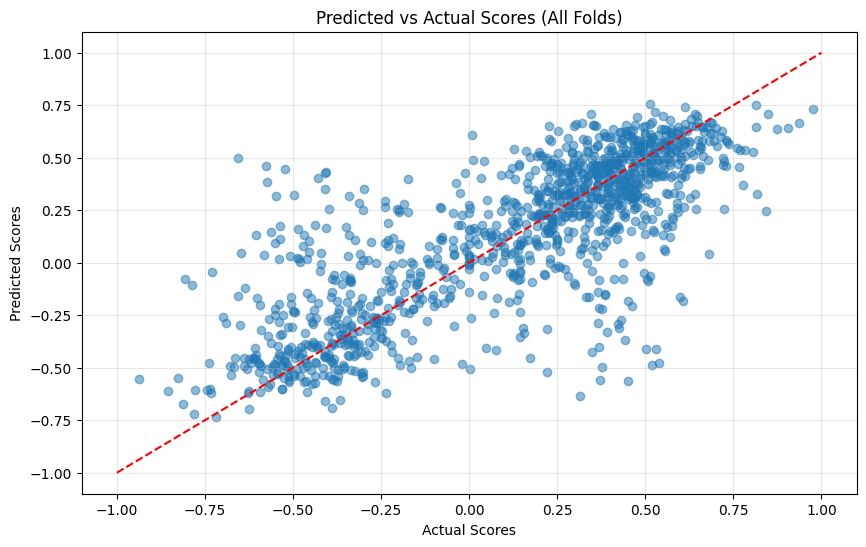

In [ ]:
#Training the alternate model architecture
results_b, predictions_b, actuals_b = run_k_fold_cross_validation("FinBERTRegressorB", combined_df, k=NUM_FOLDS)